In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

In [4]:
!python -m pip install git+https://github.com/nirum/jetplot


  Cloning https://github.com/nirum/jetplot to c:\users\iryna.yavorska\appdata\local\temp\pip-req-build-9aldp9rf
  Resolved https://github.com/nirum/jetplot to commit 7e2fc15049870523acb3318a38ffeec73c0dfb67


  Running command git clone -q https://github.com/nirum/jetplot 'C:\Users\iryna.yavorska\AppData\Local\Temp\pip-req-build-9aldp9rf'


In [5]:
import jetplot
import matplotlib.colors


### get original clustering outputs

In [6]:
glm_version = '24_events_all_L2_optimize_by_session'

In [7]:
# base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
# data_folder = '220622_across_session_norm_10_5_10'

# filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
# feature_matrix = pd.read_hdf(os.path.join(base_dir, data_folder, filename), key='df')

# filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
# df_meta = pd.read_hdf(os.path.join(base_dir, data_folder, filename))

# filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
# original_cluster_labels = pd.read_hdf(os.path.join(base_dir, data_folder, filename))

In [8]:
# # plot feature matrix sorted by cluster ID
# plotting.plot_feature_matrix_sorted(feature_matrix, df_meta, sort_col='cluster_id', save_dir=None,
#                                     folder=None)

### get GLM results (not across session normalized)

In [9]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat

In [10]:
version = '24_events_all_L2_optimize_by_session'

run_params, results, results_pivoted, weights_df = gfd.load_analysis_dfs(version)

loading run_params
loading results df
loading results_pivoted df
loading weights_df


### get across session normalized dropout scores

In [11]:
import visual_behavior_glm.GLM_across_session as gas

# get across session normalized dropout scores
df, failed_cells = gas.load_cells(glm_version, clean_df=True)
df = df.set_index('identifier')

Loading list of matched cells


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [02:20<00:00, 27.87it/s]


0 cells could not be loaded


In [12]:
df.keys()

Index(['omissions_within', 'all-images_within', 'behavioral_within',
       'task_within', 'omissions_across', 'all-images_across',
       'behavioral_across', 'task_across', 'cell_roi_id', 'cell_specimen_id',
       'ophys_experiment_id', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type', 'depth', 'binned_depth',
       'area_depth', 'area_binned_depth', 'layer', 'area_layer', 'date',
       'first_novel', 'n_relative_to_first_novel', 'last_familiar',
       'last_familiar_active', 'second_novel', 'second_novel_active',
     

In [13]:
# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')

11763 len(results_pivoted)


### get experiment and cell metadata

In [14]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


#### limit GLM results to matched cells and reformat

In [15]:
len(results_pivoted)

11763

In [16]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [17]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [18]:
len(results_pivoted)

11763

# cluster on all cells 

I had to pull out and adapt bits of code from VBA to run on all cre lines because most VBA code loops through cre lines within the main functions - needs to be modularized

In [19]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
folder = 'figs'

In [20]:
feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

No duplicated cells found
3921


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->axis1] [items->None]

  f(store)


In [21]:
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)

3921 cells in cell_metadata for feature_matrix



## load or generate clustering results


In [22]:
n_clusters = 14 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
# otherwise run it and save it
else: 
    # run spectral clustering and get co-clustering matrix
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(100))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_path = os.path.join(save_dir, 'coclustering_matrix_n_'+str(n_clusters)+'_clusters.h5')
    coclustering_df.to_hdf(coclust_save_path, key='df', format='table')


    # plot coclustering matrix - need to hack it since it assumes cre lines
    coclustering_dict = {}
    coclustering_dict['all'] = coclustering_df
    cluster_meta_tmp = cluster_meta.copy()
    cluster_meta_tmp['cre_line'] = 'all'
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
                                                    save_dir=save_dir, folder=folder, ax=None)


    # run agglomerative clustering on co-clustering matrix to identify cluster labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                    linkage='average')
    labels = cluster.fit_predict(X)
    cell_specimen_ids = coclustering_df.index.values
    # make dictionary with labels for each cell specimen ID in this cre line
    labels_dict = {'labels': labels, 'cell_specimen_id': cell_specimen_ids}
    # turn it into a dataframe
    labels_df = pd.DataFrame(data=labels_dict, columns=['labels', 'cell_specimen_id'])
    # get new cluster_ids based on size of clusters and add to labels_df
    cluster_size_order = labels_df['labels'].value_counts().index.values
    # translate between original labels and new IDS based on cluster size
    labels_df['cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in labels_df.labels.values]
    # concatenate with df for all cre lines
    cluster_labels = labels_df

    # add metadata to cluster labels
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)

    cluster_meta = cluster_labels[['cell_specimen_id', 'cluster_id', 'labels']].merge(cell_metadata, on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
    # annotate & clean cluster metadata
    cluster_meta = processing.clean_cluster_meta(cluster_meta)  # drop cluster IDs with fewer than 5 cells in them
    cluster_meta['original_cluster_id'] = cluster_meta.cluster_id

    # add within cluster correlation
    cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=True)

    # save clustering results
    cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')
    cluster_data = cluster_meta.reset_index()[['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'cluster_id', 'labels', 'within_cluster_correlation']]
    cluster_data.to_hdf(cluster_meta_save_path, key='df', format='table')



3921 cells in cell_metadata for feature_matrix


## Kyles plot

In [23]:

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] #v6

def get_coding_score_matrix(coding_scores):
    coding_scores_np = []

    for cluster_idx in range(len(coding_scores)):
        if len(coding_scores[cluster_idx]) == 0:
            continue

        # print(np.array(coding_scores[cluster_idx]).shape)
        coding_scores_np.append(np.array(coding_scores[cluster_idx]))

    return np.concatenate(coding_scores_np, axis=0)

def plot_coding_score_matrix(coding_scores, name='', plot_mode='v', session_colors=False, plot_cluster_means=False):
    """
    INPUT:
        coding_scores: nested list of coding score values
            len(coding_scores) = n_clusters
            len(coding_score[0]) = n_cells in cluster 0
    """

    N_COLUMNS = 12

    n_clusters = len(coding_scores)

    coding_scores_np = get_coding_score_matrix(coding_scores)

    coding_scores_np_unmod = np.copy(coding_scores_np)
    if session_colors:
        max_cs = 5.0
        coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", c_vals[0], "white", c_vals[1], "white", c_vals[3]])

        for idx in (1, 4, 7, 10): # Remap certain sessions to new values
            coding_scores_np[:, idx] = coding_scores_np[:, idx] + 2
        for idx in (2, 5, 8, 11):
            coding_scores_np[:, idx] = coding_scores_np[:, idx] + 4
    else:
        coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", c_vals_dl[5]])
        max_cs = 1.0


    cluster_means = []
    for cluster_idx in range(len(coding_scores)):
        if len(coding_scores[cluster_idx]) == 0:
            continue

        cluster_means.append(np.mean(np.array(coding_scores[cluster_idx]), axis=0))

    if plot_mode == 'v':
        fig, (ax, ax1) = plt.subplots(1, 1, figsize=(2, 5))
        ax.matshow(coding_scores_np, aspect='auto', vmin=0.0, vmax=max_cs, cmap=coding_score_cmap)
    elif plot_mode == 'h':
        if plot_cluster_means:
            fig, (ax, ax3, ax1) = plt.subplots(1, 3, figsize=(5.25, 2), gridspec_kw={'width_ratios': [5, 2, 0.5]})
        else:
            fig, (ax, ax1) = plt.subplots(1, 2, figsize=(5.25, 2), gridspec_kw={'width_ratios': [5, 0.25]})
        ax.matshow(coding_scores_np.T, aspect='auto', vmin=0.0, vmax=max_cs, cmap=coding_score_cmap)

        if plot_cluster_means:
            cluster_means = np.array(cluster_means)
            if session_colors:
                for idx in (1, 4, 7, 10): # Remap certain sessions to new values
                    cluster_means[:, idx] = cluster_means[:, idx] + 2
                for idx in (2, 5, 8, 11):
                    cluster_means[:, idx] = cluster_means[:, idx] + 4

            ax3.matshow(cluster_means.T, aspect='auto', vmin=0.0, vmax=max_cs, cmap=coding_score_cmap)

        ax1.matshow(np.mean(coding_scores_np, axis=0, keepdims=True).T, aspect='auto', vmin=0.0, vmax=max_cs, cmap=coding_score_cmap)

        for i in range(coding_scores_np.shape[1]):
            text_str = '{:.2f}'.format(np.mean(coding_scores_np_unmod, axis=0)[i])
            ax1.text(0, i, text_str, va='center', ha='center', size=4)

        fig.tight_layout()

    n_clusters = 0
    total_cells = 0
    cluster_ticks = []
    for cluster_idx in range(len(coding_scores)):
        if len(coding_scores[cluster_idx]) == 0:
            continue

        n_clusters += 1
        cluster_ticks.append(total_cells + len(coding_scores[cluster_idx])/2)
        total_cells += len(coding_scores[cluster_idx])

        if cluster_idx == len(coding_scores)-1: # Skip this for last cluster
            continue
        if len(coding_scores[cluster_idx + 1]) == 0: # Or if next cluster has no elements
            continue
        if plot_mode == 'v':
            ax.axhline(total_cells, color='grey', linewidth=0.5)
        elif plot_mode == 'h':
            ax.axvline(total_cells, color='grey', linewidth=0.5)


    if plot_mode == 'v':
        ax.set_ylabel('{} Cluster ID'.format(name))
        ax.set_yticks(cluster_ticks)
        ax.set_yticklabels(np.arange(1, n_clusters+1))

        ax.axvline(2.5, color='grey', linestyle='dashed', linewidth=0.5)
        ax.axvline(5.5, color='grey', linestyle='dashed', linewidth=0.5)
        ax.axvline(8.5, color='grey', linestyle='dashed', linewidth=0.5)

        ax.set_xticks(np.arange(N_COLUMNS+1)-0.5)
        ax.set_xticklabels([None for _ in range(N_COLUMNS+1)])

        ax.xaxis.tick_top()
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=4)

    elif plot_mode == 'h':
        # ax.xaxis.set_label_position('top')
        ax.set_xticks((0, coding_scores_np.shape[0]))
        ax.set_xlabel('Cells', fontsize=8)

        ax.axhline(2.5, color='grey', linestyle='dashed', linewidth=0.5)
        ax.axhline(5.5, color='grey', linestyle='dashed', linewidth=0.5)
        ax.axhline(8.5, color='grey', linestyle='dashed', linewidth=0.5)

        # ax.set_yticks(np.arange(N_COLUMNS+1)-0.5)
        # ax.set_yticklabels([None for _ in range(N_COLUMNS+1)])

        ax.set_yticks(np.arange(N_COLUMNS))
        ax.set_yticklabels(['F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+'], ha='left')
        [
            t.set_color(i) for (i,t) in zip([
                c_vals[0], c_vals[1], c_vals[3], c_vals[0], c_vals[1], c_vals[3],
                c_vals[0], c_vals[1], c_vals[3], c_vals[0], c_vals[1], c_vals[3]
            ], ax.yaxis.get_ticklabels())
        ]
        ax.tick_params(axis='y', which='major', pad=10)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=4)

        ax2 = ax.twiny()

        ax2.set_xlim(ax.get_xlim())
        ax2.tick_params(axis='both', which='major', labelsize=6)
        ax2.tick_params(axis='both', which='minor', labelsize=4)
        ax2.set_xlabel('{} Cluster ID'.format(name), fontsize=8)
        ax2.set_xticks(cluster_ticks)
        ax2.set_xticklabels(np.arange(1, n_clusters+1))
        # ax2.xaxis.set_label_position('bottom')

        # ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        ax1.set_xticks([0,])
        ax1.set_xticklabels(['mean'])
        ax1.set_yticks([])
        ax1.tick_params(axis='both', which='major', labelsize=6, bottom=False)

        ax1.set_xlabel('{} cells'.format(name), fontsize=6)
        ax1.xaxis.set_label_position('top')

        if plot_cluster_means:
            ax3.axhline(2.5, color='grey', linestyle='dashed', linewidth=0.5)
            ax3.axhline(5.5, color='grey', linestyle='dashed', linewidth=0.5)
            ax3.axhline(8.5, color='grey', linestyle='dashed', linewidth=0.5)

            ax3.set_xlabel('{} cluster means'.format(name), fontsize=6)
            ax3.set_xticks(np.arange(n_clusters))
            ax3.set_xticklabels(np.arange(n_clusters)+1)
            ax3.set_yticks([])
            ax3.xaxis.set_label_position('top')
            ax3.tick_params(axis='both', which='major', labelsize=6, bottom=False)



In [24]:
sorted_cluster_meta = cluster_meta.sort_values(by='cluster_id')
cell_order = sorted_cluster_meta.index.values
label_values = sorted_cluster_meta['cluster_id'].values

# get data from feature matrix for this set of cells
data = feature_matrix.loc[cell_order]


In [25]:
coding_scores = []
for cluster_id in np.sort(sorted_cluster_meta.cluster_id.unique()):
    cell_order = sorted_cluster_meta[sorted_cluster_meta.cluster_id==cluster_id].index.values
    cluster_cells = feature_matrix.loc[cell_order]
    coding_scores.append(cluster_cells)

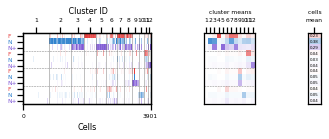

In [26]:
plot_mode = 'h'
session_colors = True
plot_cluster_means = True

plot_coding_score_matrix(coding_scores, name='', plot_mode=plot_mode, session_colors=session_colors, plot_cluster_means=plot_cluster_means)
# plot_coding_score_matrix(vip_coding_scores, name='VIP', plot_mode=plot_mode, session_colors=session_colors, plot_cluster_means=plot_cluster_means)
# plot_coding_score_matrix(sst_coding_scores, name='SST', plot_mode=plot_mode, session_colors=session_colors, plot_cluster_means=plot_cluster_means)

## plot coding scores sorted by cluster labels

In [27]:
# c_vals = ['#e53e3e', '#3182ce', '#805ad5',] #v6

# sns.palplot(c_vals)

In [28]:
def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', orient='horiz', session_colors=True,
                                    save_dir=None, folder=None, ax=None):
    """
    Plot heatmap of all cells coding scores, sorted by cluster_id (or some other column of cluster_meta)
    with lines between clusters. 
    cluster_meta: dataframe of cell metadata, indexed by cell_specimen_id, with the cluster_id for each cell_specimen_id
    feature_matrix: dataframe of coding score values, indexed by cell_specimen_id
    sort_by: column in cluster_meta to sort the cells by, should be 'cluster_id' or similar identifier for what cluster / group a cell belongs to
    orient: 'horiz' or 'vert'; whether to orient the plot vertically (cells on y axis, coding socres on x) or horizontally (cells on x axis, coding scores on y)
    session_colors: if True, will plot the coding score values using the color of the experience level for that coding score
                    if False, default colormap will be used ("Blues_r")
    """

    sorted_cluster_meta = cluster_meta.sort_values(by=sort_by)
    cell_order = sorted_cluster_meta.index.values
    label_values = sorted_cluster_meta[sort_by].values
    n_clusters = len(sorted_cluster_meta[sort_by].unique())

    # get data from feature matrix for this set of cells
    data = feature_matrix.loc[cell_order].copy()

    # Kyle's colors
    c_vals = ['#e53e3e', '#3182ce', '#805ad5',] #v6

    # orient = 'horiz'
    # session_colors = False

    if orient == 'vert':
        figsize = (5,10)
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(data.values, cmap='Blues', ax=ax, vmin=0, vmax=1, 
                            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

        for x in [3, 6, 9]:
            ax.axvline(x=x, ymin=0, ymax=data.shape[0], color='gray', linestyle='--', linewidth=1)
        # ax.set_title('n = '+str(n_clusters)+' clusters')
        ax.set_ylabel('cells')
        ax.set_ylim(0, data.shape[0])
        ax.set_yticks([0, data.shape[0]])
        ax.set_yticklabels((0, data.shape[0]), fontsize=14)
        ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
        ax.set_xlabel('')
        ax.set_xlim(0, data.shape[1])
        ax.set_xticks(np.arange(0, data.shape[1]) + 0.5)
        # if use_abbreviated_labels:
        #     xticklabels = [get_abbreviated_experience_levels([key[1]])[0] + ' -  ' + get_abbreviated_features([key[0]])[0].upper() for key in list(data.keys())]
        #     ax.set_xticklabels(xticklabels, rotation=90, fontsize=14)
        # else:
        ax.set_xticklabels([key[1] + ' -  ' + key[0] for key in list(data.keys())], rotation=90, fontsize=14)

        # plot a line at the division point between clusters
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for y in cluster_divisions:
            ax.hlines(y, xmin=0, xmax=data.shape[1], color='k')

    elif orient == 'horiz':
        figsize = (6.5,3.5)
        fig, ax = plt.subplots(figsize=figsize)

        # remap coding scores to experience level colors
        # coding_scores_unmod = data.values.copy()
        coding_scores_remapped = data.values.copy()

        if session_colors:
            vmax = 5
            colors = experience_level_colors
            # colors = c_vals # Kyle's colors
            coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0], "white", colors[1], "white", colors[2]])

            # familiar sessions are in scale of 0-1 already
            # add 2 to novel sessions to make them in the scale of colors[1]
            for idx in (1, 4, 7, 10): # Remap certain sessions to new values
                coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 2
            # add 4 to novel + sessions to make them in the scale of colors[2]
            for idx in (2, 5, 8, 11):
                coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 4
        else:
            vmax = 1
            coding_score_cmap = 'Blues'

        # data = data.T.copy()
        coding_scores_remapped = coding_scores_remapped.T.copy()


        ax = sns.heatmap(coding_scores_remapped, cmap=coding_score_cmap, ax=ax, vmin=0, vmax=vmax, 
                            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

        for y in [3, 6, 9]:
            ax.axhline(y=y, xmin=0, xmax=coding_scores_remapped.shape[0], color='gray', linestyle='--', linewidth=1)
        # ax.set_title('n = '+str(n_clusters)+' clusters')
        ax.set_xlabel('cells')
        ax.set_xlim(0, coding_scores_remapped.shape[1])
        ax.set_xticks([0, coding_scores_remapped.shape[1]])
        ax.set_xticklabels((0, coding_scores_remapped.shape[1]))
        # ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
        ax.set_ylabel('')
        ax.set_ylim(0, coding_scores_remapped.shape[0])

        # set y ticks to F, N, N+ with correct colors
        ax.set_yticks(np.arange(n_clusters)+0.5)
        ax.set_yticklabels(['F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+'], va='center')
        c_vals = experience_level_colors.copy()
        [
            t.set_color(i) for (i,t) in zip([
                c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2],
                c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2]
            ], ax.yaxis.get_ticklabels())
        ]
        ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so image clusters are on top

        # iterate through clusters, get size of cluster, set tick location for middle of cluster
        cell_count = 0
        cluster_ticks = []
        for cluster_id in range(n_clusters):
            n_cells_in_cluster = len(cluster_meta[cluster_meta[sort_by]==cluster_id])
            cluster_ticks.append(cell_count + n_cells_in_cluster/2)
            cell_count += n_cells_in_cluster
        # plot labels for cluster IDS
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel('Cluster ID')
        ax2.set_xticks(cluster_ticks)
        ax2.set_xticklabels(np.arange(1, n_clusters+1))

        # plot a line at the division point between clusters
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for x in cluster_divisions:
            ax.vlines(x, ymin=0, ymax=coding_scores_remapped.shape[1], color='k')

    if save_dir:
        fig.subplots_adjust(wspace=0.7)
        utils.save_figure(fig, figsize, save_dir, folder, 'feature_matrix_n_clusters_'+str(n_clusters)+'_'+orient+'_'+sort_by+'_sort')

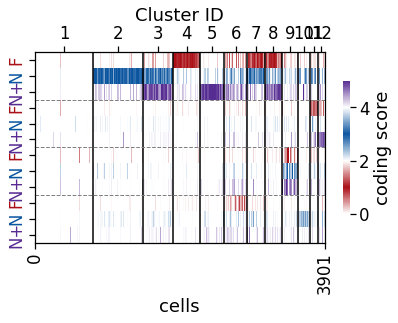

In [29]:
plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', orient='horiz', session_colors=True,
                                    save_dir=save_dir, folder=folder, ax=None)

### cluster averages

In [30]:
cluster_means = feature_matrix.merge(cluster_meta[['cluster_id']], on='cell_specimen_id').groupby('cluster_id').mean()
columns = pd.MultiIndex.from_tuples(cluster_means.columns)
cluster_means.columns = columns
cluster_means

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


all-images                     omissions                      \
             Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cluster_id                                                                
0            0.008245  0.003125  0.003918  0.003412  0.006359  0.003516   
1            0.026374  0.885535  0.090434  0.009872  0.030257  0.012025   
2            0.080408  0.787501  0.772291  0.011749  0.030253  0.024485   
3            0.912700  0.063783  0.062232  0.027475  0.007509  0.007982   
4            0.027436  0.098206  0.899775  0.010326  0.008291  0.018363   
5            0.304873  0.321134  0.352912  0.047576  0.051155  0.044890   
6            0.725841  0.737746  0.250362  0.034035  0.038424  0.020644   
7            0.722273  0.302357  0.740893  0.028666  0.018656  0.032498   
8            0.149195  0.177314  0.145936  0.071048  0.037982  0.043887   
9            0.044669  0.367929  0.129072  0.020546  0.022731  0.024079   
10           0.224085  0.394340  0.105247  0.637385  0.109848  0.155919   
11           0.115085  0.225764  0.190126  0.131063  0.081760  0.688202   

           behavioral                          task                      
             Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cluster_id                                                               
0            0.007489  0.002918  0.004299  0.002150  0.006699  0.007353  
1            0.009004  0.031560  0.018400  0.010832  0.045034  0.023359  
2            0.009143  0.020873  0.023867  0.016797  0.044318  0.036193  
3            0.023732  0.011571  0.014162  0.041011  0.021859  0.023019  
4            0.007914  0.009790  0.030107  0.013372  0.021541  0.037306  
5            0.071373  0.054951  0.069023  0.229685  0.082826  0.140430  
6            0.024960  0.025498  0.023931  0.055912  0.049027  0.033506  
7            0.024364  0.018608  0.031396  0.042247  0.032020  0.052703  
8            0.308668  0.395623  0.422146  0.029086  0.048292  0.042771  
9            0.017601  0.043198  0.028428  0.017495  0.407519  0.079671  
10           0.075131  0.117091  0.059593  0.031294  0.076533  0.015242  
11           0.094494  0.077583  0.075618  0.032947  0.070935  0.050241

In [31]:
# def remap_coding_scores_to_session_colors(coding_scores):
#     """
#     coding_scores is an array where rows are cells (or cluster)ids and columns are experience level / coding feature combinations
#     """
#     coding_scores_remapped = coding_scores.values.copy()
#     vmax = 5
#     colors = experience_level_colors
#     # colors = c_vals # Kyle's colors
#     coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0], "white", colors[1], "white", colors[2]])

#     # familiar sessions are in scale of 0-1 already
#     # add 2 to novel sessions to make them in the scale of colors[1]
#     for idx in (1, 4, 7, 10): # Remap certain sessions to new values
#         coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 2
#     # add 4 to novel + sessions to make them in the scale of colors[2]
#     for idx in (2, 5, 8, 11):
#         coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 4

#     return coding_scores_remapped, coding_score_cmap

In [32]:
def remap_coding_scores_to_session_colors(coding_scores):
    """
    coding_scores is an array where rows are cells (or cluster ids) and columns are experience level / coding feature combinations
    """
    coding_scores_remapped = coding_scores.copy()
    
    colors = experience_level_colors.copy()
    # colors = c_vals # Kyle's colors
    coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0], "white", colors[1], "white", colors[2]])

    # familiar sessions are in scale of 0-1 already
    # add 2 to novel sessions to make them in the scale of colors[1]
    coding_scores_remapped.loc[:, (slice(None), "Novel 1")] += 2
    coding_scores_remapped.loc[:, (slice(None), "Novel >1")] += 4

    # return max value for plotting
    vmax = 5

    return coding_scores_remapped, coding_score_cmap, vmax

In [33]:
def get_cluster_means(feature_matrix, cluster_meta):
    """
    adds cluster_id column to feature_matrix then groups by the cluster ID to compute the mean of each cluster
    """
    cluster_means = feature_matrix.merge(cluster_meta[['cluster_id']], on='cell_specimen_id').groupby('cluster_id').mean()
    # reset column values so they arent tuples
    columns = pd.MultiIndex.from_tuples(cluster_means.columns)
    cluster_means.columns = columns
    return cluster_means

In [34]:
def get_cre_line_means(feature_matrix, cluster_meta):
    """
    adds cluster_id column to feature_matrix then groups by the cre line to compute the mean of each cre line
    """
    cre_line_means = feature_matrix.merge(cluster_meta[['cre_line']], on='cell_specimen_id').groupby('cre_line').mean()
    # reset column values so they arent tuples
    columns = pd.MultiIndex.from_tuples(cre_line_means.columns)
    cre_line_means.columns = columns
    return cre_line_means

In [35]:
def get_clean_labels_for_coding_scores_df(coding_scores, columns=False): 
    """
    coding_scores should be a data frame with cells or clusters as colums (or indices) and 
    (coding score category - experience level) as multi-index columms (or indices)
    specify axis to transform by setting columns to True or False
    """
    if columns:
        experience_level_labels = coding_scores.columns.get_level_values(1)
    else:
        experience_level_labels = coding_scores.index.get_level_values(1)
    exp_level_abbreviations = [exp_level.split(' ')[0][0] if len(exp_level.split(' ')) == 1 else exp_level.split(' ')[0][0] + exp_level.split(' ')[1][:2] for exp_level in experience_level_labels]
    # manually label feature categories
    # feature_labels = ['', 'images', '', '', 'omissions', '', '', 'behavioral', '', '', 'task', '']
    # new_labels = pd.MultiIndex.from_arrays((feature_labels, exp_level_abbreviations))
    new_labels = exp_level_abbreviations
    return new_labels

In [36]:
def color_yaxis_labels_by_experience(ax):
    """
    iterates through y-axis tick labels and sets them to experience level colors in an alternating way,
    assuming that the labels are in [F, N, N+] order for the 4 feature categories (images, omission, behvaioral, task)
    """
    c_vals = utils.get_experience_level_colors()
    [t.set_color(i) for (i,t) in zip([
            c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2],
            c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2]
        ], ax.yaxis.get_ticklabels())]


In [37]:
def plot_cre_line_means_heatmap(cre_line_means, cmap, vmax, colorbar=False, ax=None):
    """
    plots a heatmap of mean coding score values for each cre line with a given colormap and vmax
    cre_line_means: dataframe with cre lines as columns and feature-experience combinations as rows 
    """
    if ax is None: 
        figsize = (8,5)
        fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cre_line_means, cmap=cmap, vmin=0, vmax=vmax, square=True, cbar=colorbar, ax=ax)
    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    ax.set_ylabel('')
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_line_means.columns.values])
    ax.set_xlabel('')
    ax.set_title('avg.\ncoding')
    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=cre_line_means.shape[0], color='gray', linestyle='--', linewidth=1)

    # # label feature categories on right
    # fontsize = 12
    # rotation = -90
    # ax.text(s='images', x=3.25, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    # ax.text(s='omissions', x=3.28, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    # ax.text(s='behavioral', x=3.25, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    # ax.text(s='task', x=3.28, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')

    # colorize y axis labels
    color_yaxis_labels_by_experience(ax)

    return ax


In [38]:
def plot_cre_line_means_remapped(feature_matrix, cluster_meta):
    """
    Get the average coding score values for each cre line, remap the colormap to use session colors, 
    Translate the dataframe so that cre lines are columns and rows are feature-experience combos, 
    abbreviate the labels for aesthetics, then plot
    """
    cre_line_means = get_cre_line_means(feature_matrix, cluster_meta)

    cre_line_means_remapped, coding_score_cmap, vmax = remap_coding_scores_to_session_colors(cre_line_means)
    cre_line_means_remapped = cre_line_means_remapped.T.copy()

    # relabel dataframe indices to be abbreviated
    new_labels = get_clean_labels_for_coding_scores_df(cre_line_means_remapped, columns=False)
    cre_line_means_remapped.index = new_labels

    plot_cre_line_means_heatmap(cre_line_means_remapped, coding_score_cmap, vmax, colorbar=False, ax=None)

In [39]:
def plot_cluster_means_heatmap(cluster_means, cmap, vmax, colorbar=False, ax=None):
    """
    plots a heatmap of cluster mean value with a given colormap and vmax
    cluster_means: dataframe with clusters as columns and feature-experience combinations as rows 
    """
    if ax is None: 
        figsize = (8,5)
        fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cluster_means, cmap=cmap, vmin=0, vmax=vmax, square=True, cbar=colorbar, ax=ax)
    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    ax.set_ylabel('')
    ax.set_xlabel('cluster ID')
    ax.set_title('cluster averages')
    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=cluster_means.shape[0], color='gray', linestyle='--', linewidth=1)

    # dotted gray lines every 3rd cluster
    for x in [3, 6, 9]:
        ax.axvline(x=x, ymin=0, ymax=cluster_means.shape[0], color='gray', linestyle='--', linewidth=1)

    # label feature categories on right
    fontsize = 14
    rotation = -90
    ax.text(s='images', x=12.25, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='omissions', x=12.28, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='behavioral', x=12.25, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='task', x=12.28, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')

    # colorize y axis labels
    color_yaxis_labels_by_experience(ax)

    return ax


In [40]:
def plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=None, folder=None, ax=None): 
    """
    Get the average coding score values for each cluster, remap the colormap to use session colors, 
    Translate the dataframe so that clusters are columns and rows are feature-experience combos, 
    abbreviate the labels for aesthetics, then plot
    """
    # compute cluster means
    cluster_means = get_cluster_means(feature_matrix, cluster_meta)
    # remap to session colors
    cluster_means_remapped, coding_score_cmap, vmax = remap_coding_scores_to_session_colors(cluster_means)
    # translate the df so clusters are cols and feature-exp are rows
    cluster_means_remapped = cluster_means_remapped.T.copy()
    # relabel dataframe indices to be abbreviated
    new_labels = get_clean_labels_for_coding_scores_df(cluster_means_remapped, columns=False)
    cluster_means_remapped.index = new_labels
    # make the plot
    if ax is None:
        figsize = (8,5)
        fig, ax = plt.subplots(figsize=figsize)
    ax = plot_cluster_means_heatmap(cluster_means_remapped, coding_score_cmap, vmax, colorbar=False, ax=ax)    
    # save
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder, 'cluster_means_remapped')
    return ax




C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


AttributeError: module 'visual_behavior.visualization.utils' has no attribute 'get_abbreviated_cell_type'

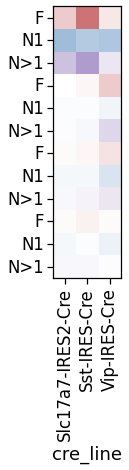

In [39]:
plot_cre_line_means_remapped(feature_matrix, cluster_meta)

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


<AxesSubplot:title={'center':'cluster averages'}, xlabel='cluster ID'>

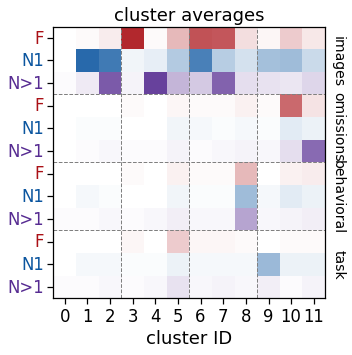

In [40]:
plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=None, folder=None, ax=None)

In [41]:
def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=None, folder=None, ax=None):
    """
    Plot heatmap of all cells coding scores, sorted by cluster_id (or some other column of cluster_meta)
    with lines between clusters. 
    cluster_meta: dataframe of cell metadata, indexed by cell_specimen_id, with the cluster_id for each cell_specimen_id
    feature_matrix: dataframe of coding score values, indexed by cell_specimen_id
    sort_by: column in cluster_meta to sort the cells by, should be 'cluster_id' or similar identifier for what cluster / group a cell belongs to
    orient: 'horiz' or 'vert'; whether to orient the plot vertically (cells on y axis, coding socres on x) or horizontally (cells on x axis, coding scores on y)
    session_colors: if True, will plot the coding score values using the color of the experience level for that coding score
                    if False, default colormap will be used ("Blues_r")
    """

    if sort_by is not None: 
        sorted_cluster_meta = cluster_meta.sort_values(by=sort_by)
        label_values = sorted_cluster_meta[sort_by].values
        n_clusters = len(sorted_cluster_meta[sort_by].unique())
    else: 
        sorted_cluster_meta = cluster_meta.copy()
    cell_order = sorted_cluster_meta.index.values

    # get data from feature matrix for this set of cells
    coding_scores_sorted = feature_matrix.loc[cell_order].copy()

    # Kyle's colors
    # c_vals = ['#e53e3e', '#3182ce', '#805ad5',] #v6

    # remap coding scores to experience level colors
    if session_colors:
        coding_scores_remapped, coding_score_cmap, vmax = remap_coding_scores_to_session_colors(coding_scores_sorted)
        cbar = False
    else:
        vmax = 1
        coding_score_cmap = 'Blues'
        cbar = True

    # translate so rows are feature-exp combos and columns are cells
    coding_scores_remapped = coding_scores_remapped.T.copy()

    # relabel dataframe indices to be abbreviated experience labels (without feature categories)
    new_labels = get_clean_labels_for_coding_scores_df(coding_scores_remapped, columns=False)
    coding_scores_remapped.index = new_labels

    figsize = (12,5)
    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.heatmap(coding_scores_remapped, cmap=coding_score_cmap, ax=ax, vmin=0, vmax=vmax, 
                        robust=True, cbar=cbar, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=coding_scores_remapped.shape[0], color='gray', linestyle='--', linewidth=1)

    # y-axis formtting
    # ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
    ax.set_ylabel('')
    ax.set_ylim(0, coding_scores_remapped.shape[0])
    # set y ticks to F, N, N+ with correct colors
    # ax.set_yticks(np.arange(n_clusters)+0.5)
    # ax.set_yticklabels(rotation=90)
    ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so image clusters are on top

    if session_colors: # colorize y axis labels
        color_yaxis_labels_by_experience(ax)

    # x-axis formatting
    # iterate through clusters, get size of cluster, set tick location for middle of cluster
    if sort_by is not None:
        cell_count = 0
        cluster_ticks = []
        for cluster_id in range(n_clusters):
            n_cells_in_cluster = len(cluster_meta[cluster_meta[sort_by]==cluster_id])
            cluster_ticks.append(cell_count + n_cells_in_cluster/2)
            cell_count += n_cells_in_cluster
        # plot bottom x labels for cluster IDS
        ax.set_xlabel('cluster ID')
        ax.set_xticks(cluster_ticks)
        ax.set_xticklabels(np.sort(cluster_meta.cluster_id.unique()), rotation=0)
        ax.set_xlim(0, coding_scores_remapped.shape[1])

        # top x labels for cells
        ax2 = ax.twiny()
        # ax2.set_xlabel('cells')
        ax2.text(s='cells', x=coding_scores_remapped.shape[1]/2, y=-0.5, ha='center')
        # ax.set_xlim(ax.get_xlim())
        ax2.set_xlim(0, coding_scores_remapped.shape[1])
        ax2.set_xticks([0, coding_scores_remapped.shape[1]])
        ax2.set_xticklabels((0, coding_scores_remapped.shape[1]), rotation=0)
    else: 
        ax.set_xlim(0, coding_scores_remapped.shape[1])
        ax.set_xticks([0, coding_scores_remapped.shape[1]])
        ax.set_xticklabels((0, coding_scores_remapped.shape[1]), rotation=0)
        ax.set_xlabel('cells')

    # plot a line at the division point between clusters
    if sort_by is not None:
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for x in cluster_divisions:
            ax.vlines(x, ymin=0, ymax=coding_scores_remapped.shape[1], color='k')

    # label feature categories on left
    rotation = 0
    fontsize = 16
    ax.text(s='images', x=-300.25, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='omissions', x=-300.28, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='behavioral', x=-300.25, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='task', x=-300.28, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')

    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

    if save_dir:
        fig.subplots_adjust(wspace=0.7)
        utils.save_figure(fig, figsize, save_dir, folder, 'feature_matrix_n_clusters_'+str(n_clusters)+'_remapped_'+sort_by+'_sort')

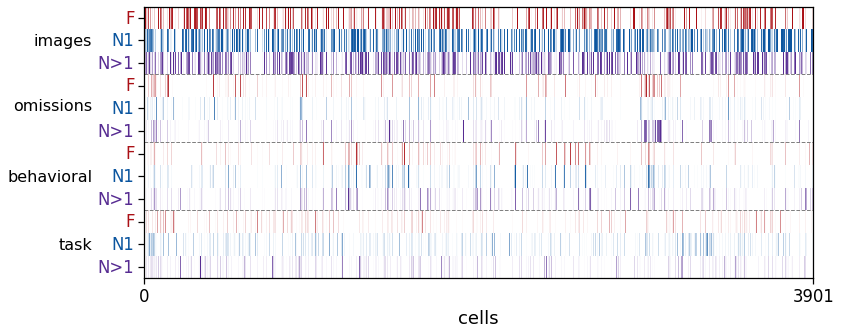

In [42]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=None, folder=None, ax=None)

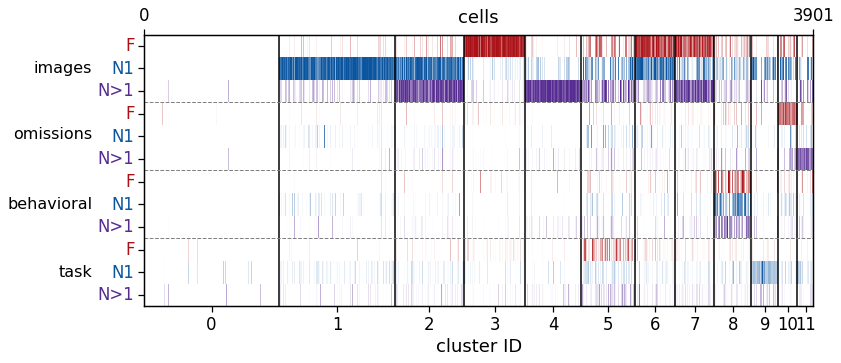

In [43]:
plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=None, folder=None, ax=None)

<AxesSubplot:title={'center':'cluster averages'}, xlabel='cluster ID'>

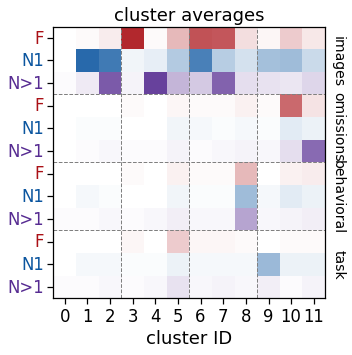

In [44]:
plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=None, folder=None, ax=None)

### fraction cells per cluster per cre

In [45]:
def get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group='mouse_id'):
    """
    counts the number of cells a given condition, and the number of cells in each cluster for that given ocndition,
    then computes the proportion of cells in each cluster for the given condition
    col_to_group: can be 'cre_line', 'mouse_id', etc
    """
    # get number of cells in each group defined by col_to_group
    n_cells_group = cluster_meta.groupby([col_to_group]).count()[['cluster_id']].reset_index().rename(columns={'cluster_id':'n_cells_group'})
    # get number of cells in each cluster for each group
    n_cells_per_cluster = cluster_meta.groupby([col_to_group, 'cluster_id']).count()[['ophys_experiment_id']].reset_index().rename(columns={'ophys_experiment_id':'n_cells_cluster'})
    # add n cells per cluster per group to total number of cells per group and compute the fraction per cluster in each group
    n_cells_per_cluster = n_cells_per_cluster.merge(n_cells_group, on=col_to_group)
    n_cells_per_cluster['fraction_per_cluster'] = n_cells_per_cluster.n_cells_cluster/n_cells_per_cluster.n_cells_group
    
    return n_cells_per_cluster

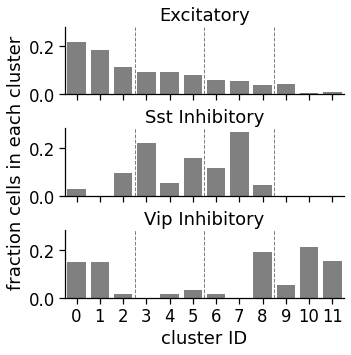

In [46]:
# sorted within cre
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (5,5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre_line]
    order = np.sort(cluster_meta.cluster_id.unique())
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x='cluster_id', order=order, y='fraction_per_cluster', 
                color='gray',  ax=ax[i]) #width=0.5,
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    # ax[i].set_ylim(0, 0.3)
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    # dotted gray lines every 3rd cluster
    for x in [2.5, 5.5, 8.5]:
        ax[i].axvline(x=x, ymin=0, color='gray', linestyle='--', linewidth=1)

ax[1].set_ylabel('fraction cells in each cluster')
ax[i].set_xlabel('cluster ID')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)

### average dropouts per cluster

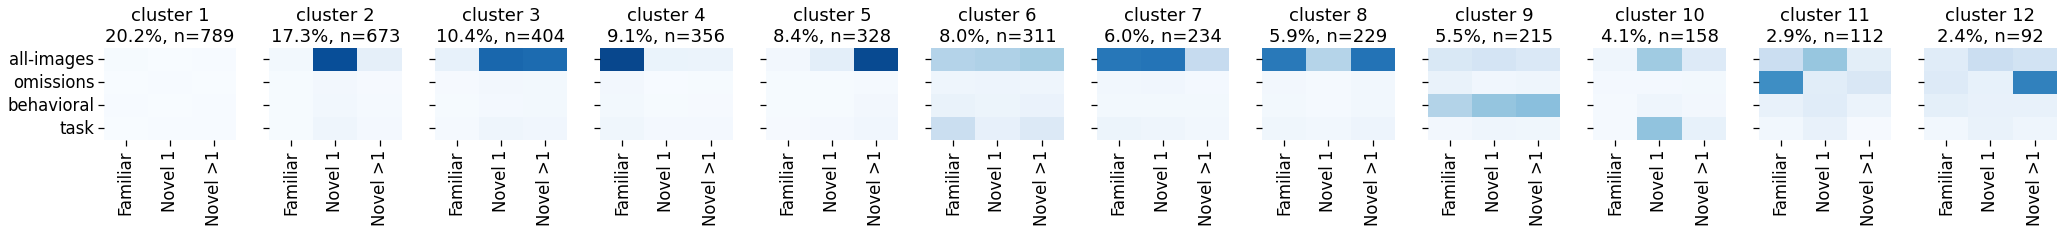

In [41]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)

figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id+1) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_'+str(n_clusters))

### how many cells per cluster per mouse

In [48]:
# cre_line = 'Vip-IRES-Cre'
# cluster_meta[cluster_meta.cre_line==cre_line].groupby(['cre_line', 'mouse_id', 'cluster_id']).count().rename(columns={'labels':'n_cells'})[['n_cells']][:50]

### heatmaps of image response per cluster

In [54]:
data_type = 'filtered_events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'platform_experiment_table'
# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']
change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria


In [50]:

# try:
#     ### load Multisession dfs from folder
#     multi_session_df_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache/multi_session_mean_response_dfs/interpolate_30Hz'
#     partial_string = 'mean_response_df_'+data_type+'_'+event_type

#     # Use os.listdir() to get the list of files in the folder
#     files_in_folder = os.listdir(multi_session_df_dir)

#     # Filter files that contain the partial string
#     matching_files = [file for file in files_in_folder if partial_string in file]
#     partial_string = conditions[1]+'_epoch.h5'
#     matching_files2 = [file for file in matching_files if partial_string in file]
#     partial_string = 'passive'
#     matching_files3 = [file for file in matching_files2 if partial_string not in file]

    
#     # Display the matching files
#     full_paths_to_files = []
#     for file in matching_files3:
#         full_paths_to_files.append(os.path.join(multi_session_df_dir, file))
# except:
#     print('could not find dfs')
    
    # change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

    # multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        # interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                        #  epoch_duration_mins=None)


In [65]:
loading.get_multi_session_df_for_conditions?

Signature:
loading.get_multi_session_df_for_conditions(
    data_type,
    event_type,
    conditions,
    inclusion_criteria='platform_experiment_table',
    interpolate=True,
    output_sampling_rate=30,
    epoch_duration_mins=None,
    exclude_passive_sessions=False,
)
Docstring: <no docstring>
File:      c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\data_access\loading.py
Type:      function


In [64]:
%%time
## This takes 3 hours to run, load pickle file to speed up 

# params for stim response df creation
event_type = 'pref_image'
data_type = 'filtered_events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'platform_experiment_table'
# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']
change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                         interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None,  exclude_passive_sessions=True)


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 752.00it/s]


no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_A
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_G
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_A
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_G
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_A
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_H
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_A
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_H


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 925.52it/s]


no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_A
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_G
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_A
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_G
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_A
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_H
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_A
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_H


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 437.53it/s]


no multi_session_df for VisualBehavior OPHYS_1_images_A
no multi_session_df for VisualBehavior OPHYS_1_images_B
no multi_session_df for VisualBehavior OPHYS_1_images_G
no multi_session_df for VisualBehavior OPHYS_3_images_A
no multi_session_df for VisualBehavior OPHYS_3_images_B
no multi_session_df for VisualBehavior OPHYS_3_images_G
no multi_session_df for VisualBehavior OPHYS_4_images_A
no multi_session_df for VisualBehavior OPHYS_4_images_B
no multi_session_df for VisualBehavior OPHYS_4_images_H
no multi_session_df for VisualBehavior OPHYS_6_images_A
no multi_session_df for VisualBehavior OPHYS_6_images_B
no multi_session_df for VisualBehavior OPHYS_6_images_H


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 925.52it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_G
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_G
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_H
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_H


AttributeError: 'DataFrame' object has no attribute 'ophys_experiment_id'

In [55]:
### Save this h5 of matched cells filtered trace responses
import pickle

load =1; save =0

filename = '111323_multisession_df'+change_suffix+'.pkl' ## all images
multi_session_df_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache/multi_session_mean_response_dfs/interpolate_30Hz'

pkl_file_path = os.path.join(multi_session_df_dir, filename)

if load:
    with open(pkl_file_path, 'rb') as file:
        multi_session_df = pickle.load(file)
        file.close()
if save:         
    with open(pkl_file_path, 'wb') as file:
        pickle.dump(multi_session_df, file)
        file.close()

In [56]:
multi_session_df.keys()

Index(['cell_specimen_id', 'is_change', 'mean_response', 'sem_response',
       'mean_trace', 'sem_trace', 'trace_timestamps', 'mean_responses',
       'mean_baseline', 'sem_baseline', 'response_window_duration',
       'fano_factor', 'peak_response', 'time_to_peak', 'p_value',
       'sd_over_baseline', 'fraction_significant_p_value_gray_screen',
       'reliability', 'ophys_experiment_id', 'equipment_name', 'donor_id',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'foraging_id', 'session_type', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_type', 'image_set', 'experience_level', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'imaging_plane_group',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_stru

In [57]:

change_mdf = multi_session_df[multi_session_df.is_change==True]

In [58]:
change_mdf

cell_specimen_id  is_change  mean_response  sem_response  \
2539          1086512525       True   1.758713e-03  8.847517e-04   
2541          1086512796       True   3.863989e-03  1.561799e-03   
2543          1086513167       True   2.551490e-03  8.480654e-04   
2545          1086513271       True   7.469098e-03  2.369749e-03   
2547          1086513679       True   4.129924e-04  2.767504e-04   
...                  ...        ...            ...           ...   
107379        1120098406       True   2.350601e-04  1.660910e-04   
107381        1120098787       True   3.816297e-04  1.929659e-04   
107383        1120099026       True   1.093864e-03  3.803950e-04   
107385        1120099220       True   3.584873e-23  3.569905e-23   
107387        1120099320       True   8.713777e-04  3.871266e-04   

                                               mean_trace  \
2539    [1.3061079420540863e-10, 1.3061079420540863e-1...   
2541    [4.57505693756388e-07, 3.9528459522240663e-07,...   
2543    [0.000523857523629394, 0.00042801869966889753,...   
2545    [0.006063883970068071, 0.006478846384812585, 0...   
2547    [1.474649215694454e-76, 1.474649215694454e-76,...   
...                                                   ...   
107379  [0.00034626398774122657, 0.0002567023625180333...   
107381  [0.0006119385594472929, 0.0005054368663744152,...   
107383  [0.00055552739798491, 0.00047852313400740577, ...   
107385  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
107387  [0.00013992539005131088, 9.640293185614005e-05...   

                                                sem_trace  \
2539    [1.3018963621866635e-10, 1.3018963621866635e-1...   
2541    [3.4670777377209973e-07, 2.907163296725296e-07...   
2543    [0.0005219524578207414, 0.00042637164159088306...   
2545    [0.003526529716231538, 0.0035295472218500553, ...   
2547    [1.4706797624224887e-76, 1.4706797624224887e-7...   
...                                                   ...   
107379  [0.0003448182027722277, 0.00025563053168845137...   
107381  [0.0006093834812337858, 0.0005033264735814803,...   
107383  [0.0003557968085187036, 0.00030642370594201194...   
107385  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
107387  [0.00011219953168528736, 7.299758389430722e-05...   

                                         trace_timestamps  \
2539    [-2.0, -1.9666666666666597, -1.933333333333335...   
2541    [-2.0, -1.9666666666666597, -1.933333333333335...   
2543    [-2.0, -1.9666666666666597, -1.933333333333335...   
2545    [-2.0, -1.9666666666666597, -1.933333333333335...   
2547    [-2.0, -1.9666666666666597, -1.933333333333335...   
...                                                   ...   
107379  [-2.0, -1.9666666666666681, -1.933333333333335...   
107381  [-2.0, -1.9666666666666681, -1.933333333333335...   
107383  [-2.0, -1.9666666666666681, -1.933333333333335...   
107385  [-2.0, -1.9666666666666681, -1.933333333333335...   
107387  [-2.0, -1.9666666666666681, -1.933333333333335...   

                                           mean_responses  mean_baseline  \
2539    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.001735   
2541    [0.0, 1.7385073872758345e-37, 0.0, 0.0, 0.0, 0...       0.007424   
2543    [0.0, 0.0, 0.0, 0.049819776918841416, 6.360962...       0.001511   
2545    [0.0, 3.7892975160038715e-37, 0.0, 0.0, 0.0, 0...       0.010263   
2547    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.000889   
...                                                   ...            ...   
107379  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.000000   
107381  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.000000   
107383  [0.007183872461418879, 0.0, 0.0, 4.04950839456...       0.000173   
107385  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.000012   
107387  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.000133   

        sem_baseline  ...              session_name  isi_experiment_id  \
2539 

In [59]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

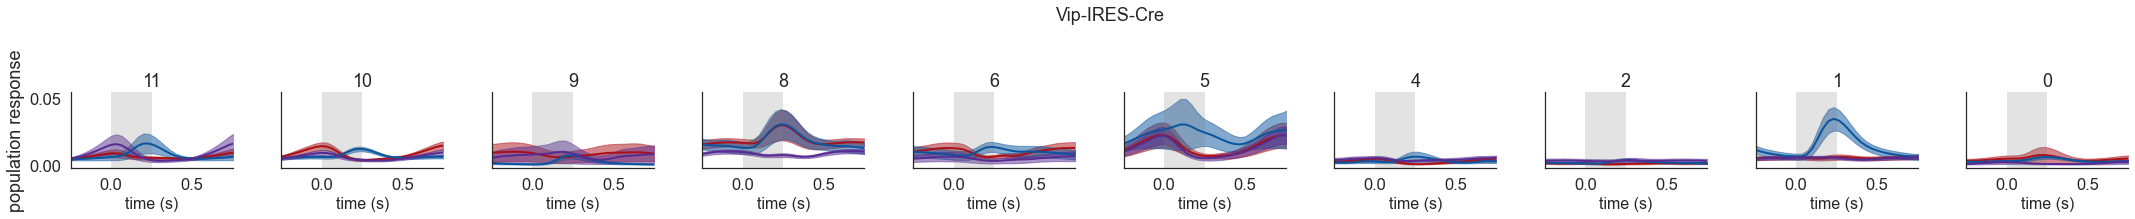

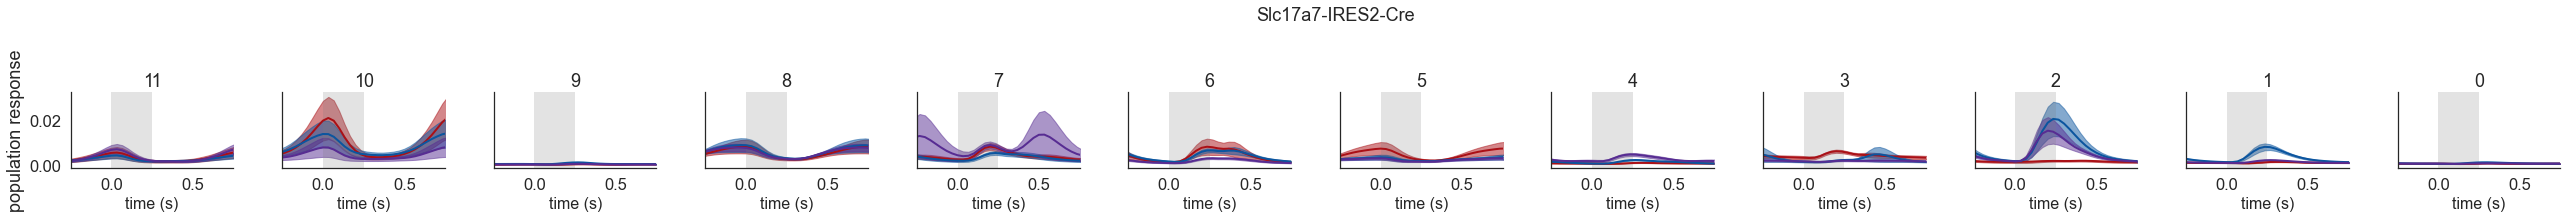

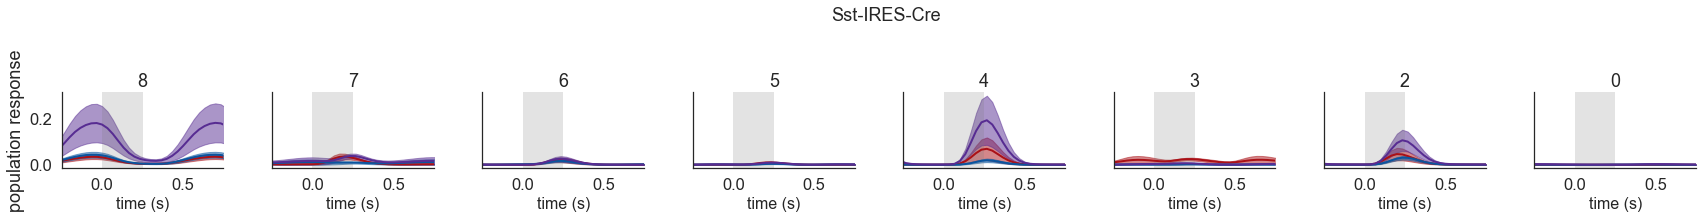

In [60]:
tmp = multi_session_df.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

tmp = tmp[tmp.is_change==False]

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    palette = utils.get_experience_level_colors()
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-0.25, 0.75]

    suffix = '_cluster_image_response'

    ax = ppf.plot_population_averages_for_conditions(df, data_type, 'all',
                                                            axes_column, hue_column, horizontal=True,
                                                            xlim_seconds=xlim_seconds, interval_sec=0.5,
                                                            palette=palette, ax=None, title=None, suptitle=cre_line,
                                                            save_dir=None, folder=folder, suffix=suffix)


In [61]:

def plot_population_averages_for_conditions_multi_row(multi_session_df, data_type, event_type, axes_column, hue_column, row_column,
                                            project_code=None, timestamps=None, palette=None, title=None, suptitle=None,
                                            horizontal=True, xlim_seconds=None, interval_sec=1,
                                            save_dir=None, folder=None, suffix='', ax=None):
    if palette is None:
        palette = utils.get_experience_level_colors()

    sdf = multi_session_df.copy()
    if 'trace_timestamps' in sdf.keys():
        timestamps = sdf.trace_timestamps.values[0]
    elif timestamps is not None:
        timestamps = timestamps
    else:
        print('provide timestamps or provide a multi_session_df with a trace_timestamps column')

    if xlim_seconds is None:
        xlim_seconds = [timestamps[0], timestamps[-1]]
    if 'dff' in data_type:
        ylabel = 'dF/F'
    elif 'events' in data_type:
        ylabel = 'population response'
    elif 'pupil' in data_type:
        ylabel = 'pupil width\n(normalized)'
    elif 'running' in data_type:
        ylabel = 'running speed (cm/s)'
    elif 'lick' in data_type:
        ylabel = 'lick rate (licks/s)'
    else:
        ylabel = 'response'
    if event_type == 'omissions':
        omitted = True
        change = False
        xlabel = 'time after omission (s)'
    elif event_type == 'changes':
        omitted = False
        change = True
        xlabel = 'time after change (s)'
    else:
        omitted = False
        change = False
        xlabel = 'time (s)'

    row_conditions = np.sort(sdf[row_column].unique())
    if hue_column == 'experience_level':
        # hue_conditions = ['Familiar', 'Novel 1', 'Novel >1']
        hue_conditions = np.sort(sdf[hue_column].unique())
    else:
        hue_conditions = np.sort(sdf[hue_column].unique())
    if axes_column == 'experience_level':
        # axes_conditions = ['Familiar', 'Novel 1', 'Novel >1']
        axes_conditions = np.sort(sdf[axes_column].unique())
    else:
        axes_conditions = np.sort(sdf[axes_column].unique())
    # if there is only one axis condition, set n conditions for plotting to 2 so it can still iterate
    if len(axes_conditions) == 1:
        n_axes_conditions = 2
    else:
        n_axes_conditions = len(axes_conditions)
    n_row_conditions = len(row_conditions)
    if ax is None:
        format_fig = True
        if horizontal:
            figsize = (4.5 * n_axes_conditions, 4 * n_row_conditions)
            fig, ax = plt.subplots(n_row_conditions, n_axes_conditions, figsize=figsize, sharey='row')
        else:
            figsize = (5* n_row_conditions, 3.5 * n_axes_conditions)
            fig, ax = plt.subplots(n_axes_conditions, n_row_conditions, figsize=figsize, sharex=True)
        ax = ax.ravel()
    else:
        format_fig = False
    i = 0
    for r, row in enumerate(row_conditions):
        for a, axis in enumerate(axes_conditions):
            try:
                for c, hue in enumerate(hue_conditions):
                    cdf = sdf[(sdf[axes_column] == axis) & (sdf[hue_column] == hue) & (sdf[row_column]==row)]
                    traces = cdf.mean_trace.values

                    ax[i] = utils.plot_mean_trace(np.asarray(traces), timestamps, ylabel=ylabel,
                                                legend_label=hue, color=palette[c], interval_sec=interval_sec,
                                                xlim_seconds=xlim_seconds, ax=ax[i])
                ax[i] = utils.plot_flashes_on_trace(ax[i], timestamps, change=change, omitted=omitted)
                if omitted:
                    omission_color = sns.color_palette()[9]
                    ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color=omission_color)
                if title == 'metadata':
                    metadata_string = utils.get_container_metadata_string(utils.get_metadata_for_row_of_multi_session_df(cdf))
                    ax[i].set_title(metadata_string)
                else:
                    if axes_column == 'experience_level':
                        title_colors = utilities.get_experience_level_colors()
                        ax[i].set_title(axis, color=title_colors[i], fontsize=20)
                    else:
                        ax[i].set_title(axis)
                if title:  # overwrite title if one is provided
                    ax[i].set_title(title)
                ax[i].set_xlim(xlim_seconds)
                ax[i].set_xlabel(xlabel, fontsize=16)
                if horizontal:
                    ax[i].set_ylabel('')
                else:
                    ax[i].set_ylabel(ylabel)
                    ax[i].set_xlabel('')
            except:
                print('no data for', axis, hue)
            i+=1
                
        if format_fig:
            if horizontal:
                ax[0].set_ylabel(row_conditions[0]+'\n'+ylabel)
                ax[len(axes_conditions)].set_ylabel(row_conditions[1]+'\n'+ylabel)
                ax[2*len(axes_conditions)].set_ylabel(row_conditions[2]+'\n'+ylabel)
            else:
                ax[i].set_xlabel(xlabel)
        # ax[0].legend(loc='upper right', fontsize='x-small') # title='passive', title_fontsize='xx-small')

    if project_code:
        if suptitle is None:
            suptitle = 'population average - ' + data_type + ' response - ' + project_code[14:]
    else:
        if suptitle is None:
            suptitle = 'population average response - ' + data_type + '_' + event_type
    if format_fig:
        plt.suptitle(suptitle, x=0.52, y=1.04, fontsize=18)
        fig.tight_layout()
        if horizontal:
            fig.subplots_adjust(wspace=0.3)

    if save_dir:
        fig_title = 'population_average_' + axes_column + '_' + row_column + '_' + hue_column + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)

    return ax

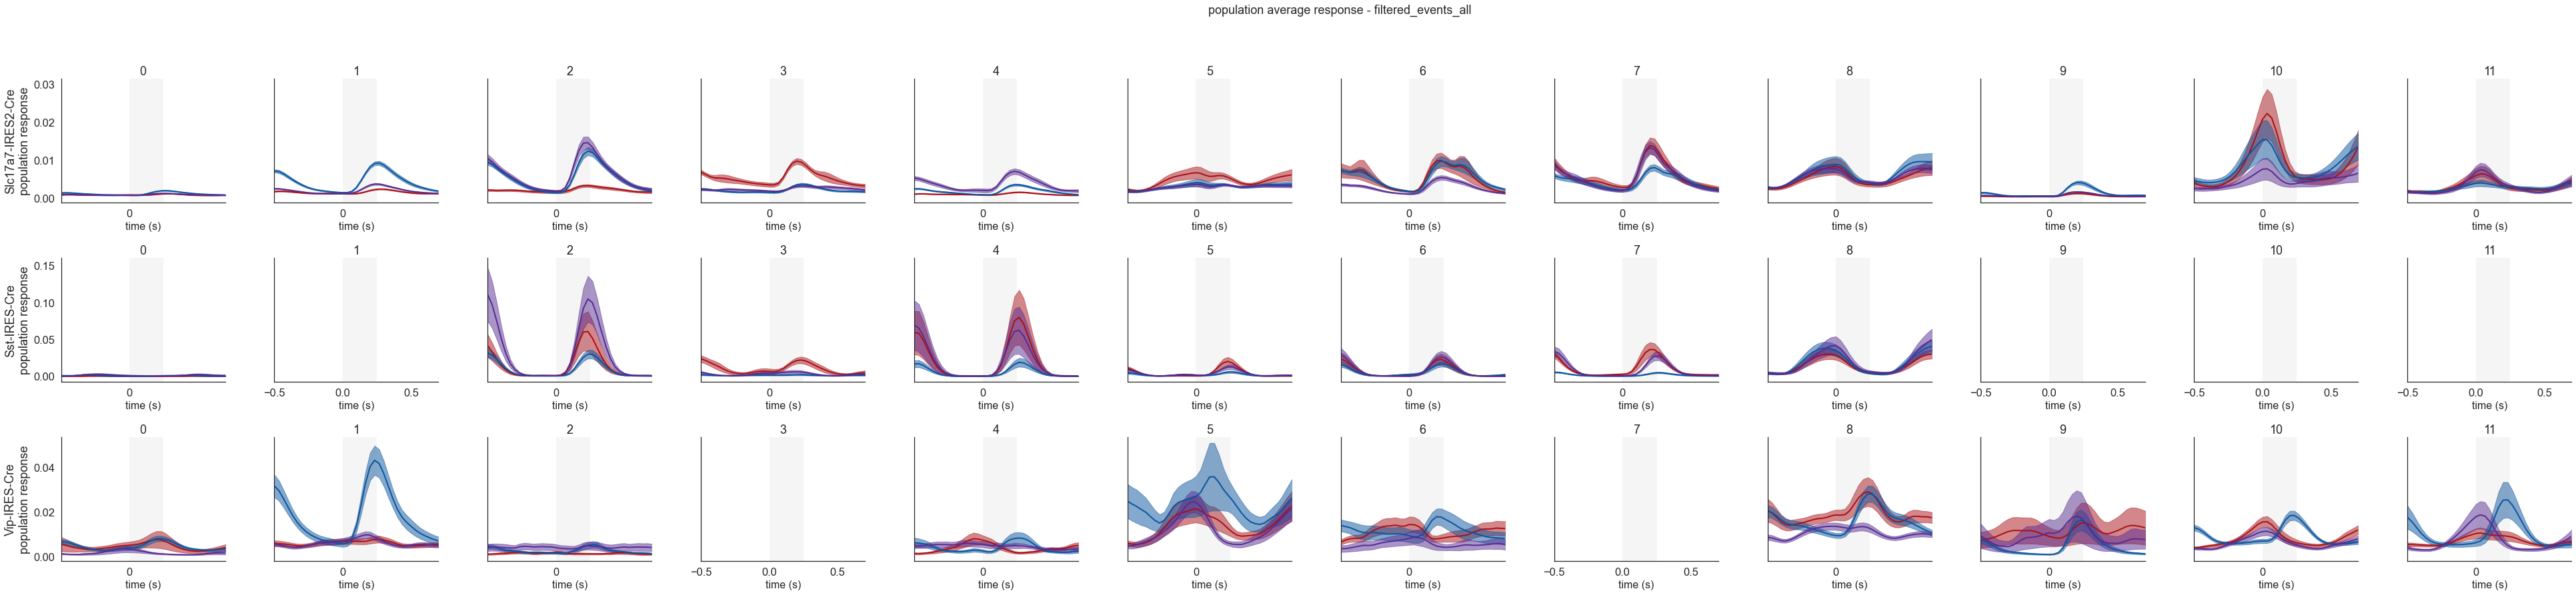

In [62]:
tmp = multi_session_df.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]


xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]


plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', axes_column='cluster_id', hue_column='experience_level', row_column='cre_line',
                                            project_code=None, timestamps=None, palette=None, title=None, suptitle=None,
                                            horizontal=True, xlim_seconds=xlim_seconds, interval_sec=1,
                                            save_dir=None, folder=None, suffix='', ax=None);

In [63]:
len(tmp)

23372

In [64]:
no_outliers = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]
len(no_outliers)

23337

In [65]:
len(tmp)-len(no_outliers)

35

In [66]:
np.percentile(tmp.mean_response.values, 99.9)

0.2180713150590499

In [67]:
tmp[tmp.mean_baseline>np.percentile(tmp[(tmp.cre_line=='Sst-IRES-Cre')].mean_baseline.values, 99.5)]

cell_specimen_id  is_change  mean_response  sem_response  \
4050         1086529704      False       0.299783      0.011690   
6270         1086533009      False       0.205369      0.007873   
6271         1086533009       True       0.285282      0.038204   
6680         1086673040      False       0.269988      0.009287   
6702         1086673279      False       0.116071      0.005810   
6703         1086673279       True       0.234438      0.034203   
6707         1086673279       True       0.281067      0.033181   
6740         1086514444      False       0.229023      0.008085   
6741         1086514444       True       0.246290      0.031447   
6742         1086514444      False       0.182345      0.007259   
6743         1086514444       True       0.218488      0.028669   
6852         1086514606      False       0.132440      0.004837   
6853         1086514606       True       0.123950      0.021241   
6854         1086514606      False       0.132160      0.004915   
6855         1086514606       True       0.153785      0.022932   
6871         1086517398       True       0.210879      0.032532   
6901         1086515279       True       0.042150      0.009894   
7800         1086560073      False       0.277161      0.010350   
7801         1086560073       True       0.334859      0.066394   
7812         1086560671      False       0.206100      0.010869   
8071         1086580238       True       0.123631      0.040903   
8248         1086575280      False       0.219823      0.008210   
8344         1086572621      False       0.245450      0.009755   
8350         1086573026      False       0.307665      0.017008   
8351         1086573026       True       0.242179      0.047992   
8364         1086619787      False       0.208838      0.007766   
10428        1120104688      False       0.307634      0.012243   
10435        1120105001       True       0.073528      0.012038   

                                              mean_trace  \
4050   [0.10599631872058037, 0.10334451544946663, 0.0...   
6270   [0.049649436019334414, 0.09019708018525903, 0....   
6271   [0.0421928360047936, 0.09311522132857974, 0.24...   
6680   [0.3288838360684007, 0.3173238243720269, 0.285...   
6702   [0.11867938403733291, 0.11766484387420947, 0.1...   
6703   [0.1507536598377855, 0.14530008174142411, 0.13...   
6707   [0.16734785765501264, 0.1659771681313887, 0.15...   
6740   [0.30977819020556935, 0.293397182889765, 0.248...   
6741   [0.3753771075599821, 0.35760065449721856, 0.32...   
6742   [0.05590971611698833, 0.05505564437741437, 0.0...   
6743   [0.09504706407129437, 0.09510958472771877, 0.0...   
6852   [0.03282627497136782, 0.032300983361927785, 0....   
6853   [0.022774462058551548, 0.02180165034574537, 0....   
6854   [0.02968182579621778, 0.02864524294749159, 0.0...   
6855   [0.007628009366306515, 0.007499091553070242, 0...   
6871   [0.07235007465588612, 0.08879121116125224, 0.1...   
6901   [0.014411487953726562, 0.015130814010873973, 0...   
7800   [0.42585915440284233, 0.41044199026833356, 0.3...   
7801   [0.45384062199383574, 0.4400162399845603, 0.42...   
7812   [0.31436724023510826, 0.3049672713558227, 0.27...   
8071   [0.2040823245088543, 0.2116449621974388, 0.211...   
8248   [0.47931598011463145, 0.4581801302178361, 0.39...   
8344   [0.5876487186517434, 0.5688724214452114, 0.506...   
8350   [0.5777081013950145, 0.5476226413634118, 0.465...   
8351   [0.9053094020024414, 0.8803858280872782, 0.745...   
8364   [0.5480425673726215, 0.5258252408648315, 0.451...   
10428  [0.6283802001744845, 0.5975059217694391, 0.505...   
10435  [0.0009634537291808243, 0.0023347652243947254,...   

                                               sem_trace  \
4050   [0.010104450837428055, 0.009945568712626876, 0...   
6270   [0.005777557073441148, 0.006403930646854574, 0...   
6271   [0.019468011053464664, 0.02331727460017509, 0....   
6680   [0.013070793189540224, 0.01257755450721328, 0....   
6702   [0.008788516192

In [68]:
data = tmp[(tmp.cre_line=='Sst-IRES-Cre') & (tmp.cluster_id==8)]
data[data.mean_baseline>0.4]

Empty DataFrame
Columns: [cell_specimen_id, is_change, mean_response, sem_response, mean_trace, sem_trace, trace_timestamps, mean_responses, mean_baseline, sem_baseline, response_window_duration, fano_factor, peak_response, time_to_peak, p_value, sd_over_baseline, fraction_significant_p_value_gray_screen, reliability, ophys_experiment_id, equipment_name, donor_id, full_genotype, mouse_id, reporter_line, driver_line, sex, age_in_days, foraging_id, session_type, cre_line, indicator, session_number, prior_exposures_to_session_type, prior_exposures_to_image_set, prior_exposures_to_omissions, behavior_type, image_set, experience_level, ophys_session_id, behavior_session_id, ophys_container_id, imaging_plane_group, container_workflow_state, experiment_workflow_state, session_name, isi_experiment_id, imaging_depth, targeted_structure, published_at, targeted_imaging_depth, date_of_acquisition, project_code, passive, cell_type, cluster_id]
Index: []

[0 rows x 55 columns]

In [69]:
np.percentile(tmp[(tmp.cre_line=='Sst-IRES-Cre') & (tmp.cluster_id==8)].mean_response.values, 99)

0.04664811948599566

In [70]:
tmp.columns

Index(['cell_specimen_id', 'is_change', 'mean_response', 'sem_response',
       'mean_trace', 'sem_trace', 'trace_timestamps', 'mean_responses',
       'mean_baseline', 'sem_baseline', 'response_window_duration',
       'fano_factor', 'peak_response', 'time_to_peak', 'p_value',
       'sd_over_baseline', 'fraction_significant_p_value_gray_screen',
       'reliability', 'ophys_experiment_id', 'equipment_name', 'donor_id',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'foraging_id', 'session_type', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_type', 'image_set', 'experience_level', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'imaging_plane_group',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_stru

In [71]:
np.shape(timestamps)

(123,)

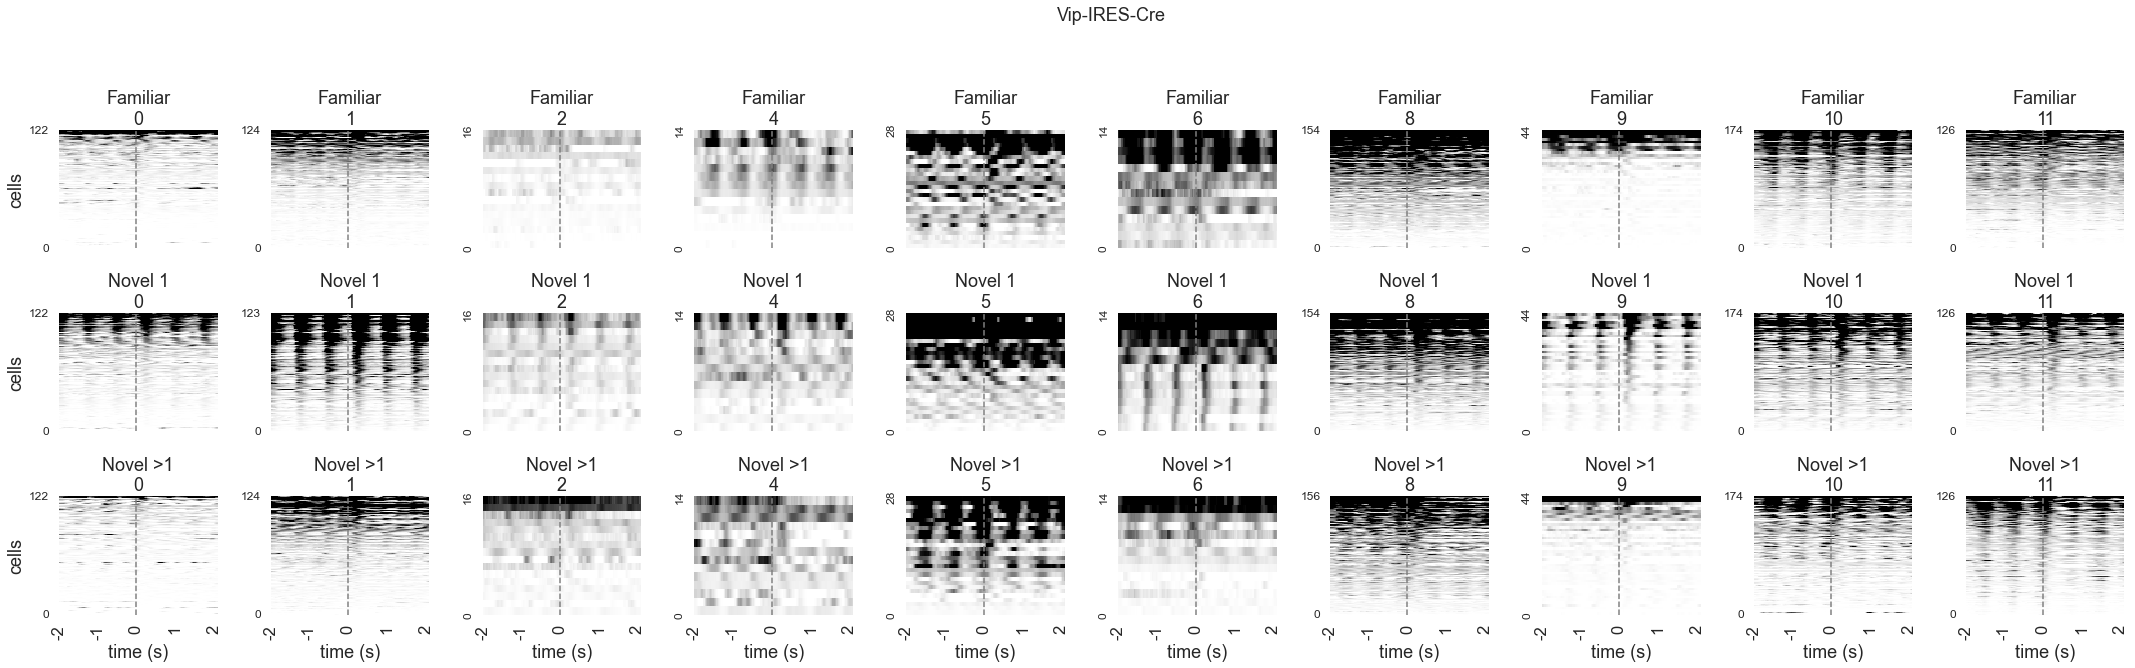

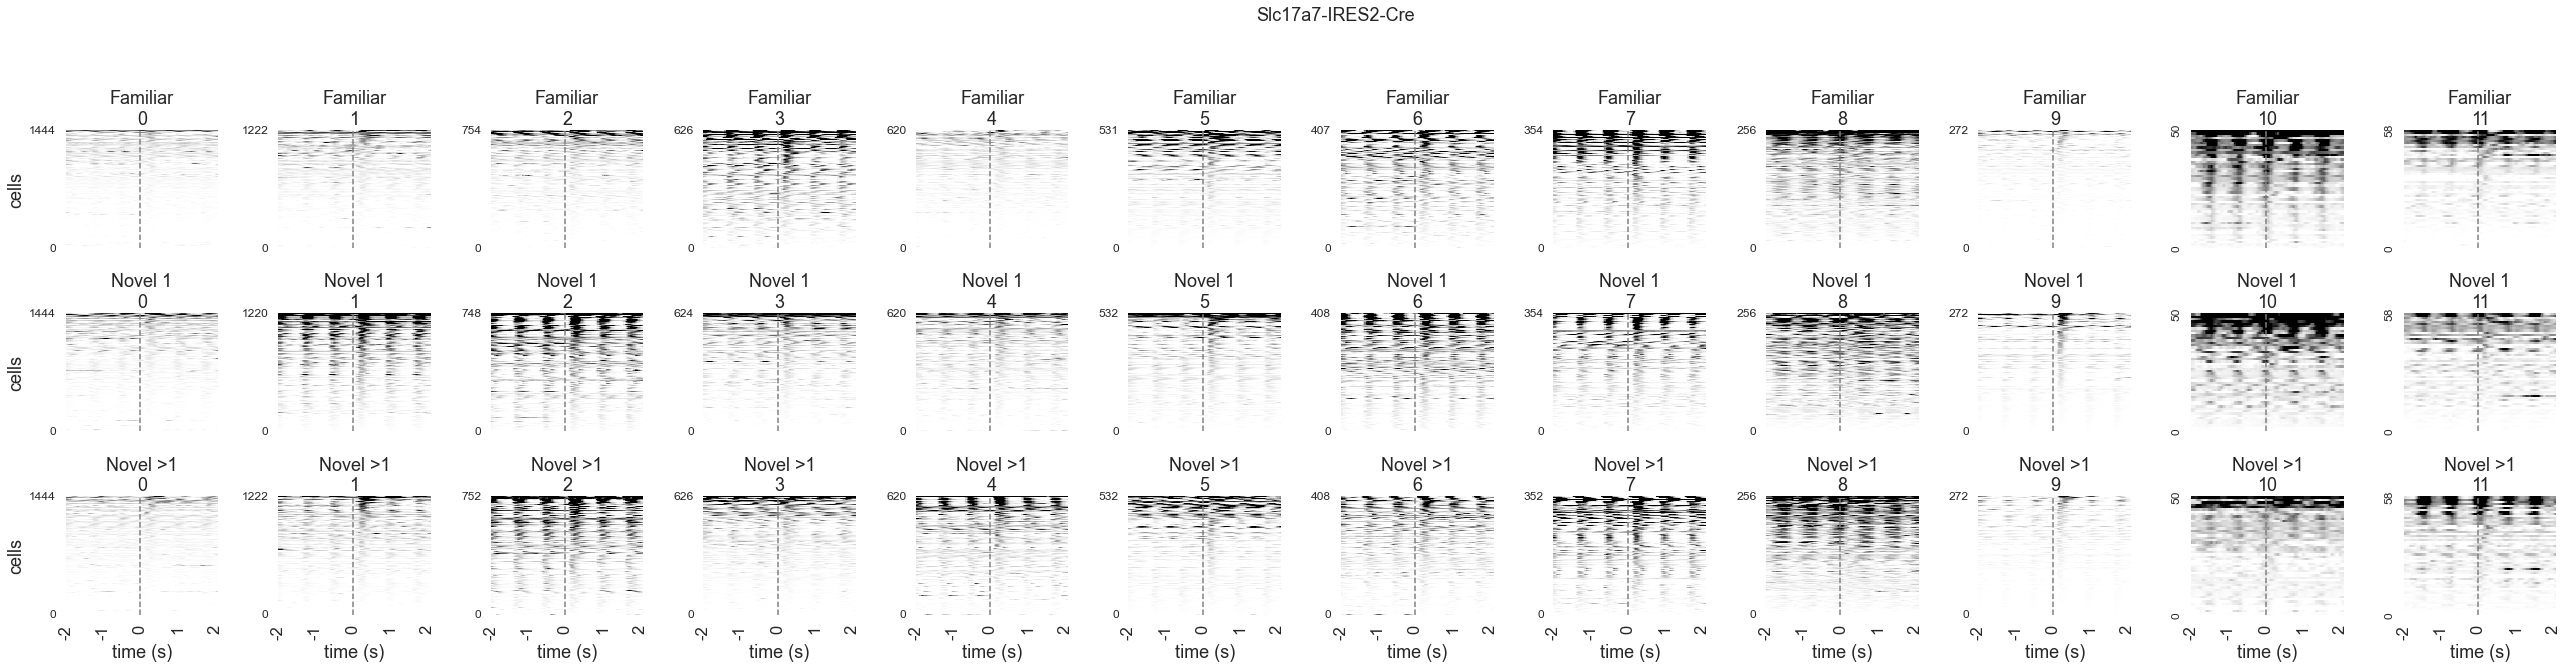

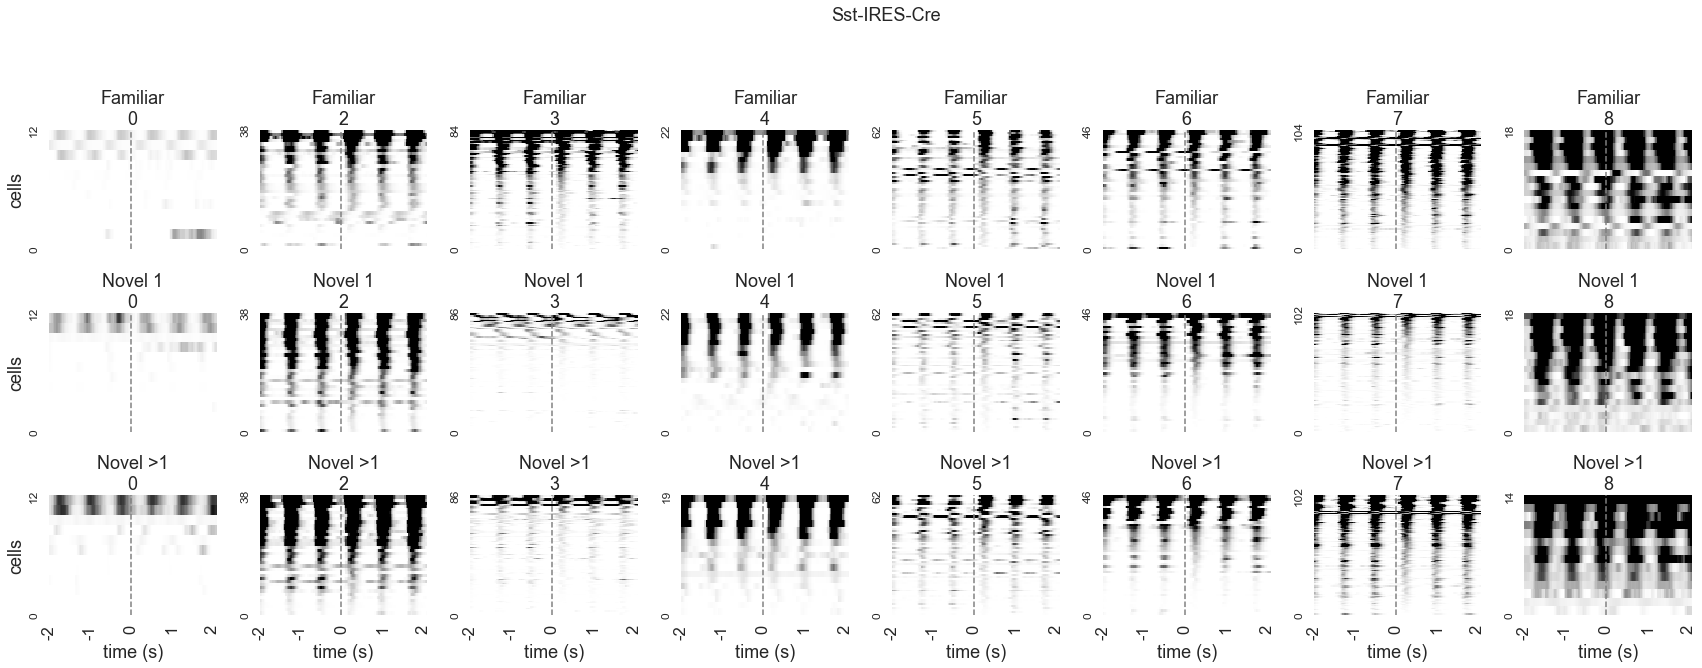

In [72]:
df = tmp[tmp.is_change==False]

xlim_seconds = [-0.5, 0.7]

event_type = 'all'

timestamps = tmp.trace_timestamps.values[0]
row_condition = 'experience_level'
col_condition = 'cluster_id'
cols_to_sort_by = ['mean_response']

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]


    ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
                                          row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
                                          microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
                                          save_dir=None, folder=folder, suffix='', ax=None)


# ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle='',
#                                           microscope=None, vmax=None, xlim_seconds=[-2, 2], match_cells=False, cbar=True,
#                                           save_dir=save_dir, folder=folder, suffix='_cbar', ax=None)

#### omissions

In [73]:
%%time

# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']

inclusion_criteria = 'platform_experiment_table'
omission_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

omission_mdf = omission_mdf[omission_mdf.omitted==True]

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)
  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_1_images_A_omitted.h5


  6%|████▌                                                                              | 1/18 [00:06<01:44,  6.13s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_1_images_B_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_1_images_G_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_2_images_A_passive_omitted.h5


 22%|██████████████████▍                                                                | 4/18 [00:11<00:36,  2.59s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_2_images_B_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_B_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_2_images_G_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_G_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_3_images_A_omitted.h5


 39%|████████████████████████████████▎                                                  | 7/18 [00:17<00:25,  2.36s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_3_images_B_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_3_images_G_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_4_images_A_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_respon

 61%|██████████████████████████████████████████████████                                | 11/18 [00:24<00:14,  2.05s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_4_images_H_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_H
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_5_images_A_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_5_images_B_passive_omitted.h5


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:30<00:07,  1.96s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_5_images_H_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_H_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_6_images_A_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_6_images_B_omitted.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:34<00:00,  1.93s/it]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope_OPHYS_6_images_H_omitted.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_H


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_1_images_A_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_1_images_B_omitted.h5


 11%|█████████▏                                                                         | 2/18 [00:02<00:17,  1.09s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_1_images_G_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_2_images_A_passive_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_2_images_B_passive_omitted.h5


 28%|███████████████████████                                                            | 5/18 [00:03<00:09,  1.38it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_2_images_G_passive_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_G_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_3_images_A_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_3_images_B_omitted.h5


 44%|████████████████████████████████████▉                                              | 8/18 [00:05<00:07,  1.40it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_3_images_G_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_4_images_A_omitted.h5


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:08<00:07,  1.07it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_4_images_B_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_4_images_H_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_H
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_5_images_A_passive_omitted.h5


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:10<00:04,  1.20it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_5_images_B_passive_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_B_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_5_images_H_passive_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_H_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_6_images_A_omitted.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_6_images_B_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorTask1B_OPHYS_6_images_H_omitted.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_H


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_1_images_A_omitted.h5


  6%|████▌                                                                              | 1/18 [00:02<00:47,  2.77s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_1_images_B_omitted.h5
no multi_session_df for VisualBehavior OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_1_images_G_omitted.h5
no multi_session_df for VisualBehavior OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_2_images_A_passive_omitted.h5


 22%|██████████████████▍                                                                | 4/18 [00:05<00:16,  1.20s/it]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_2_images_B_passive_omitted.h5
no multi_session_df for VisualBehavior OPHYS_2_images_B_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_2_images_G_passive_omitted.h5
no multi_session_df for VisualBehavior OPHYS_2_images_G_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_3_images_A_omitted.h5


 39%|████████████████████████████████▎                                                  | 7/18 [00:07<00:10,  1.06it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_3_images_B_omitted.h5
no multi_session_df for VisualBehavior OPHYS_3_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_3_images_G_omitted.h5
no multi_session_df for VisualBehavior OPHYS_3_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_4_images_A_omitted.h5
no multi_session_df for VisualBehavior OPHYS_4_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all

 61%|██████████████████████████████████████████████████                                | 11/18 [00:10<00:05,  1.23it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_4_images_H_omitted.h5
no multi_session_df for VisualBehavior OPHYS_4_images_H
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_5_images_A_passive_omitted.h5
no multi_session_df for VisualBehavior OPHYS_5_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_5_images_B_passive_omitted.h5


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:12<00:03,  1.23it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_5_images_H_passive_omitted.h5
no multi_session_df for VisualBehavior OPHYS_5_images_H_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_6_images_A_omitted.h5
no multi_session_df for VisualBehavior OPHYS_6_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_6_images_B_omitted.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.20it/s]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehavior_OPHYS_6_images_H_omitted.h5
no multi_session_df for VisualBehavior OPHYS_6_images_H


 17%|█████████████▊                                                                     | 3/18 [00:00<00:00, 19.12it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_A_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_B_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_G_omitted.h5
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30

 50%|█████████████████████████████████████████▌                                         | 9/18 [00:00<00:00, 19.47it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_3_images_A_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_3_images_B_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_3_images_G_omitted.h5
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:00<00:00, 21.35it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_A_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_B_passive_omitted.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_B_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_all_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_H_passive_omitted.h5
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 21.53it/s]


there are 1249 experiments in the full multi_session_df
getting experiment table for March and August releases from lims
excluding Ai94 data


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [75]:
### Save this h5 of matched cells filtered trace responses

load =1; save =0

filename = '111623_omission_df'+change_suffix+'.pkl'
omission_mdf_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache/multi_session_mean_response_dfs/interpolate_30Hz'

pkl_file_path = os.path.join(omission_mdf_dir, filename)

if load:
    with open(pkl_file_path, 'rb') as file:
        omission_mdf = pickle.load(file)
        file.close()
if save:         
    with open(pkl_file_path, 'wb') as file:
        pickle.dump(omission_mdf, file)
        file.close()

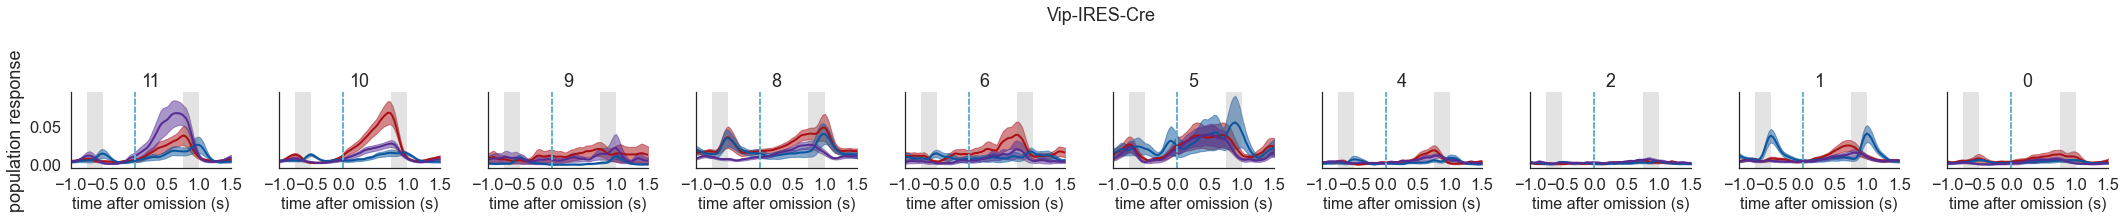

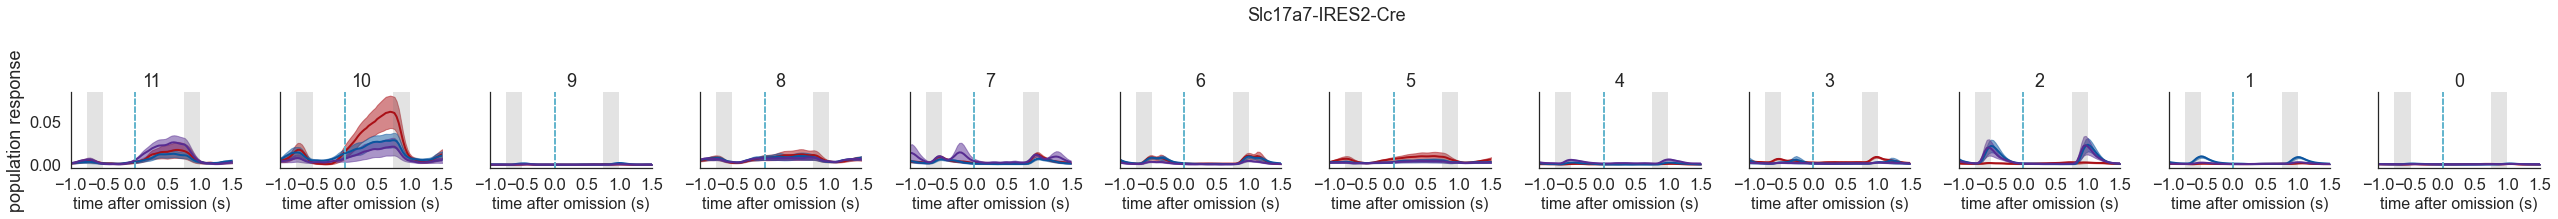

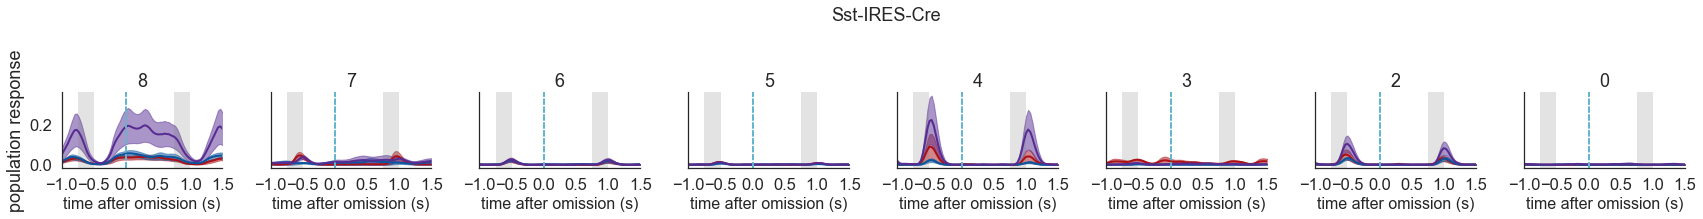

In [76]:
tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    palette = utils.get_experience_level_colors()
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-1, 1.5]

    suffix = '_cluster_omission_response'

    ax = ppf.plot_population_averages_for_conditions(df, data_type, 'omissions',
                                                            axes_column, hue_column, horizontal=True,
                                                            xlim_seconds=xlim_seconds, interval_sec=0.5,
                                                            palette=palette, ax=None, title=None, suptitle=cre_line,
                                                            save_dir=None, folder=folder, suffix=suffix)


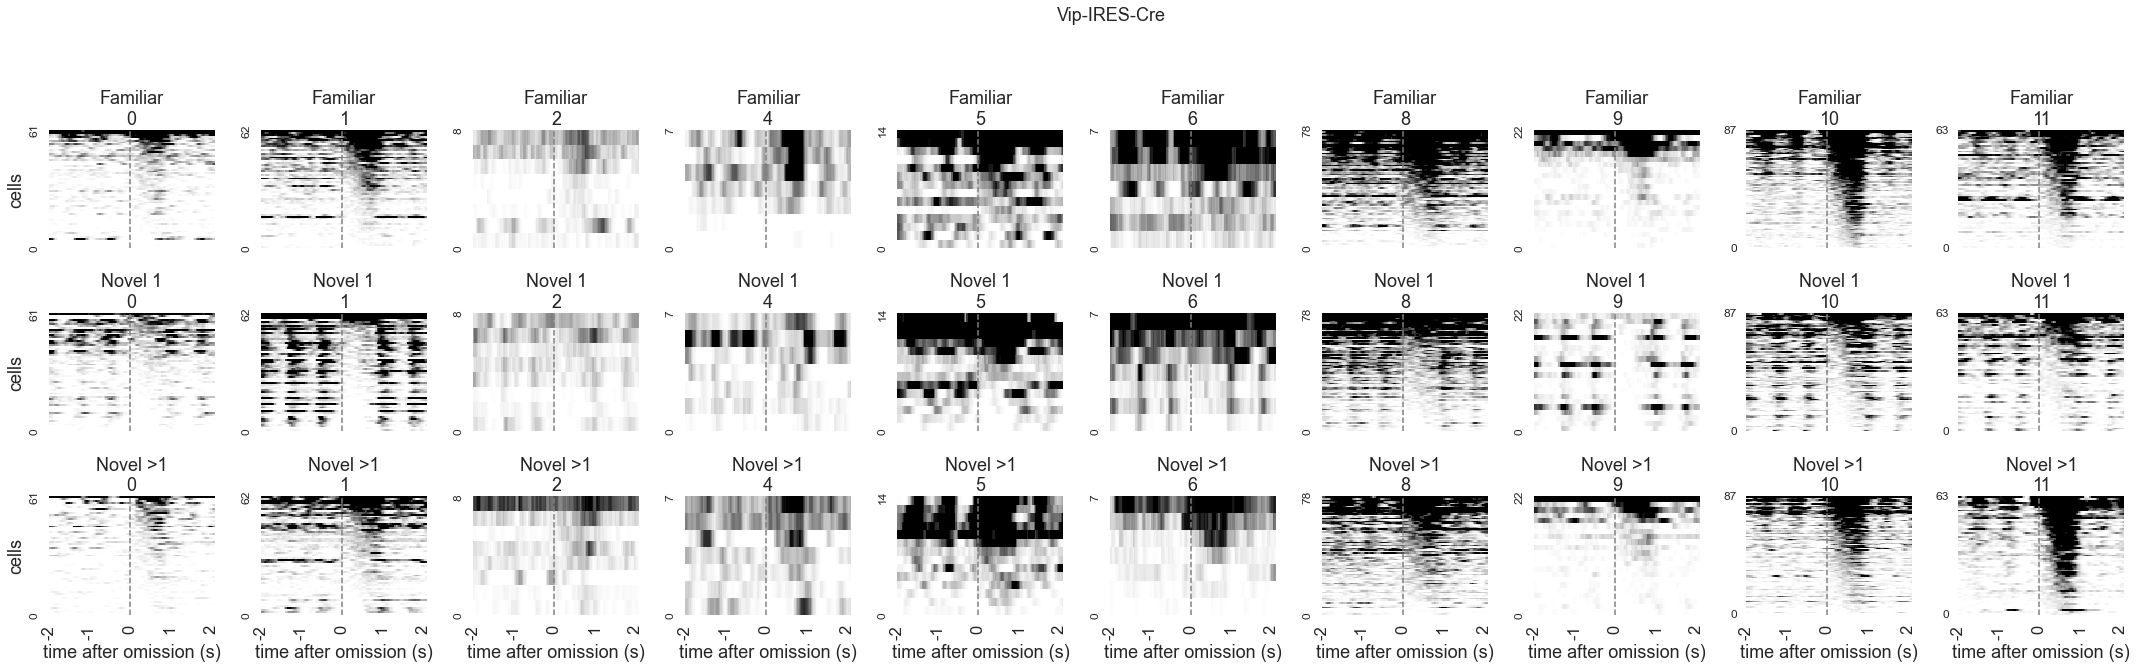

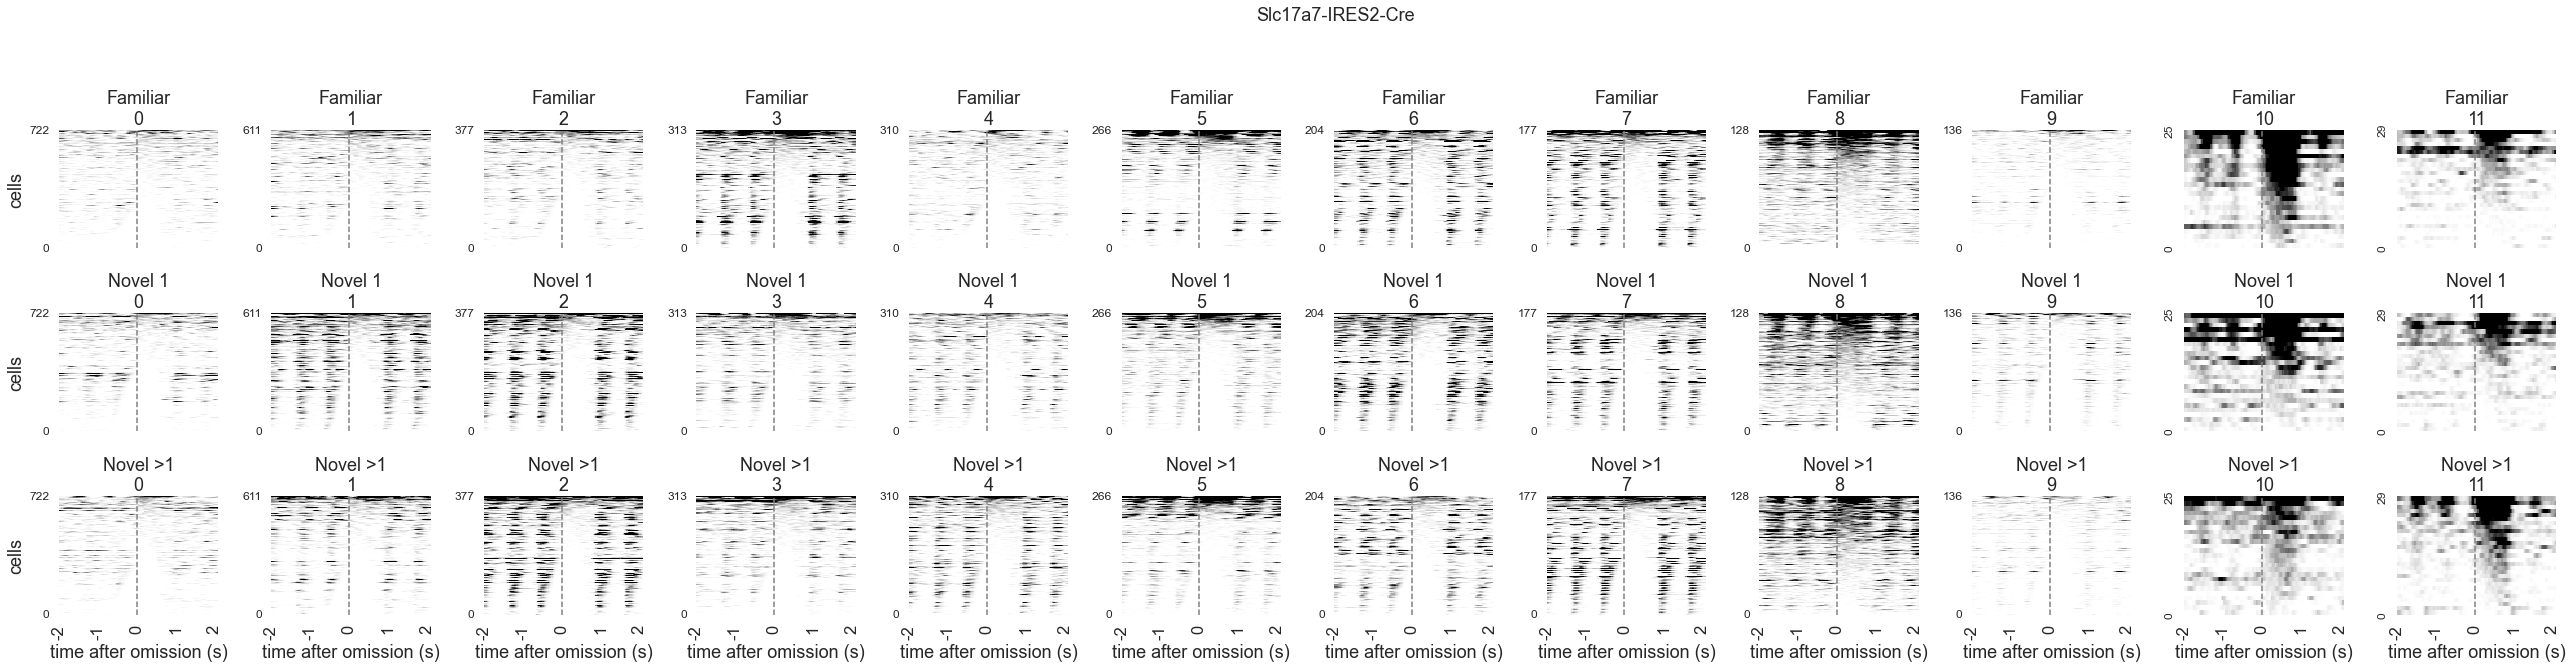

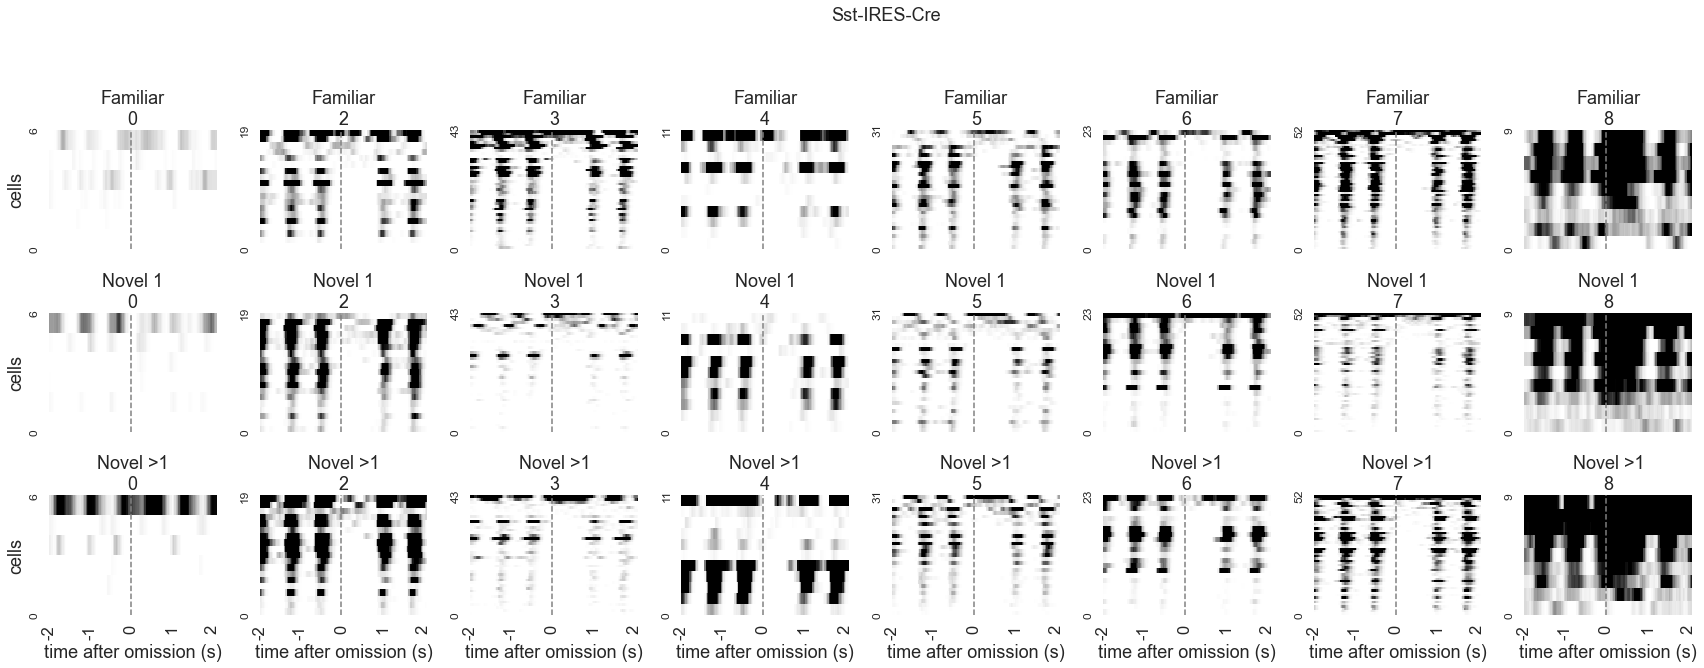

In [77]:
tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


xlim_seconds = xlim_seconds=[-1, 1.5]

event_type = 'all'

timestamps = tmp.trace_timestamps.values[0]
row_condition = 'experience_level'
col_condition = 'cluster_id'
cols_to_sort_by = ['mean_response']

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]


    ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'omissions',
                                          row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
                                          microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
                                          save_dir=None, folder=folder, suffix='', ax=None)


# ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle='',
#                                           microscope=None, vmax=None, xlim_seconds=[-2, 2], match_cells=False, cbar=True,
#                                           save_dir=save_dir, folder=folder, suffix='_cbar', ax=None)

### within session changes

In [ ]:
# %%time
# # params for stim response df creation
# event_type = 'changes'

# # params for mean response df creation
# conditions = ['cell_specimen_id', 'is_change', 'epoch']


# suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

# epoch_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
#                                                         interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
#                                                          epoch_duration_mins=None)

# epoch_mdf = epoch_mdf[epoch_mdf.is_change==False]

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)
  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_1_images_A_is_change_epoch.h5


  6%|████▌                                                                              | 1/18 [00:00<00:03,  4.55it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_1_images_B_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_1_images_G_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_2_images_A_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_beh

 39%|████████████████████████████████▎                                                  | 7/18 [00:00<00:00, 12.36it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_3_images_B_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_3_images_G_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_4_images_A_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_p

 61%|██████████████████████████████████████████████████                                | 11/18 [00:03<00:02,  2.62it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_4_images_H_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_H
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_5_images_A_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_5_images_B_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_B_passive
loading //allen/programs/braintv/workgroups/nc-

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.27it/s]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope_OPHYS_6_images_H_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_H


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 501.34it/s]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorTask1B_OPHYS_1_images_A_is_change_epoch.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorTask1B_OPHYS_1_images_B_is_change_epoch.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorTask1B_OPHYS_1_images_G_is_change_epoch.h5
no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 180.48it/s]


loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehavior_OPHYS_1_images_A_is_change_epoch.h5
no multi_session_df for VisualBehavior OPHYS_1_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehavior_OPHYS_1_images_B_is_change_epoch.h5
no multi_session_df for VisualBehavior OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehavior_OPHYS_1_images_G_is_change_epoch.h5
no multi_session_df for VisualBehavior OPHYS_1_images_G
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz 

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_A_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_A
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_B_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_B
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_1_images_G_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_G
loading //allen/programs/

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 262.32it/s]

loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_A_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_A_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_B_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_B_passive
loading //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz mean_response_df_filtered_events_changes_VisualBehaviorMultiscope4areasx2d_OPHYS_5_images_H_passive_is_change_epoch.h5
no multi_session_df for VisualBehaviorMultiscope4areasx2d OP

there are 48 experiments in the full multi_session_df
getting experiment table for March and August releases from lims


In [ ]:
original_epoch_mdf = epoch_mdf.copy()
# remove truncated last epoch
epoch_mdf = epoch_mdf[epoch_mdf.epoch!=6]
# add cluster IDs
epoch_mdf = epoch_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
# plot for all cells within each cre line
ppf.plot_mean_response_by_epoch(epoch_mdf, metric='mean_response', horizontal=True, ymin=0, ylabel='mean response', estimator=np.mean,
                                save_dir=None, folder='epochs', max_epoch=6, suptitle=None, suffix='', ax=None)

In [72]:

def plot_mean_response_by_epoch_overlay(df, metric='mean_response',ymin=0, ymax=None, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                        title='', legend=True, save_dir=None, folder=folder, suffix='', ax=None):
    """
    Plots the mean metric value across epochs within a session, colored by experience level
    :param df: dataframe of cell activity with one row per cell_specimen_id / ophys_experiment_id
                must include columns 'cell_type', 'experience_level', 'epoch', and a column for the metric provided (ex: 'mean_response')
    :param metric: metric value to average over epochs; must be a column of df
    :param save_dir: top level directory to save figure to
    :param folder: folder within save_dir to save figure to; will create folder if it doesnt exist
    :param suffix: string to append at end of saved filename
    :return:
    """

    experience_levels = np.sort(df.experience_level.unique())

    df = df[df.epoch <= max_epoch]
    epochs = np.sort(df.epoch.unique())

    palette = utils.get_experience_level_colors()
    if ax is None:
        figsize = (6, 3.5)
        fig, ax = plt.subplots(figsize=figsize)

    ax = sns.pointplot(data=df, x='epoch', y=metric, hue='experience_level', hue_order=experience_levels,
                                  order=epochs, palette=palette, ax=ax, estimator=estimator)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if ymax is not None: 
        ax.set_ylim(ymax=ymax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlim((epochs[0] - 1, epochs[-1] + 1))
    ax.set_xticks(epochs)
    ax.set_xticklabels(epochs+1)
    ax.set_xlabel('epoch within session')
    if not legend: 
        ax.get_legend().remove()

    
    if save_dir:
        fig_title = metric + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)
    return ax

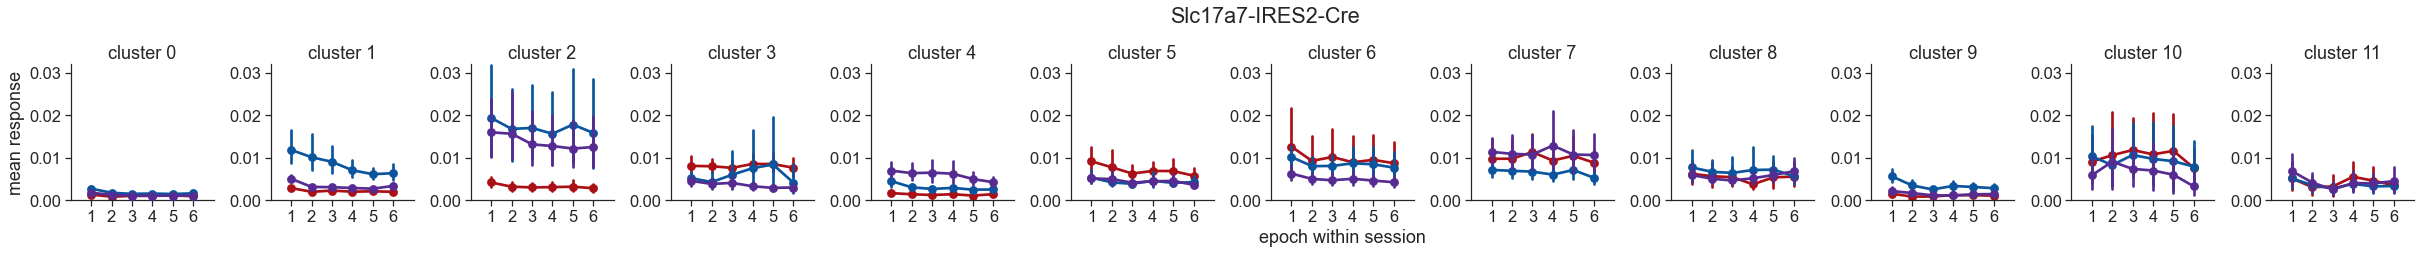

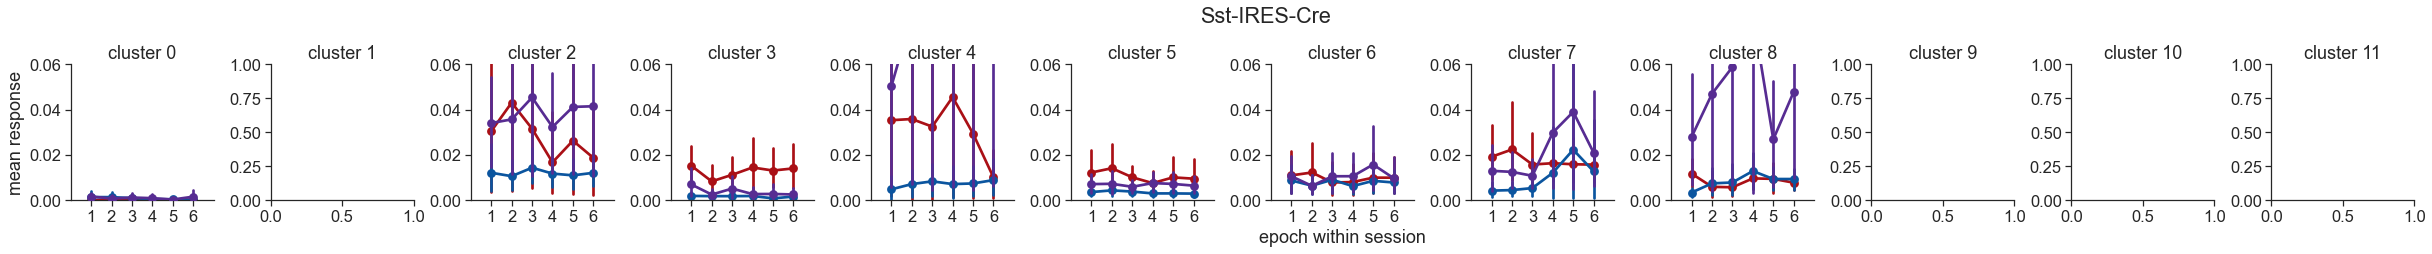

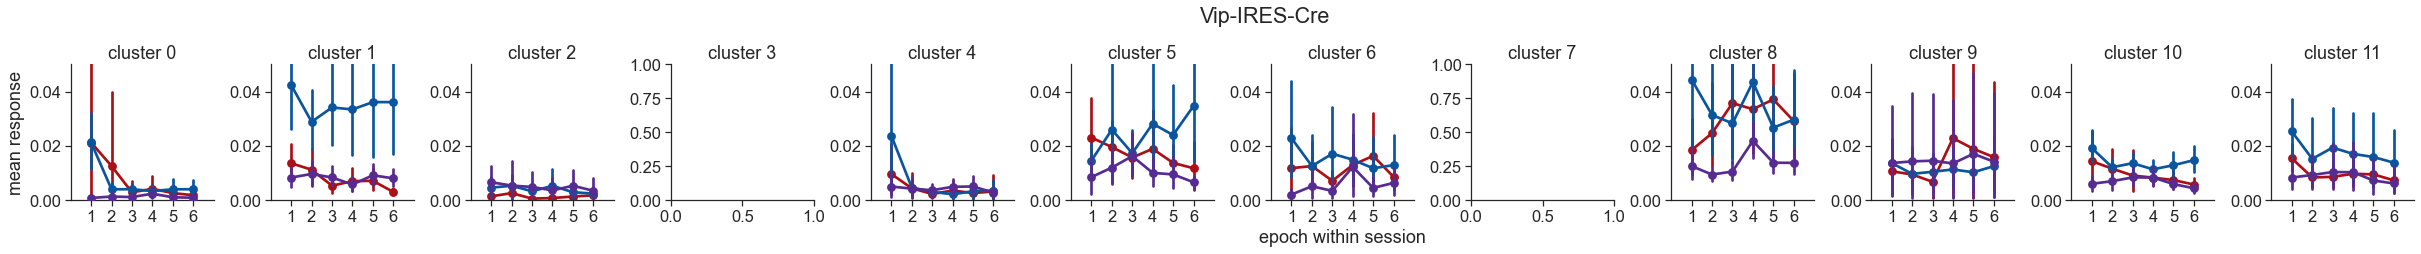

In [73]:
cre_lines = np.sort(epoch_mdf.cre_line.unique())
i = 0
cre_line = cre_lines[i]

cluster_ids = np.sort(epoch_mdf.cluster_id.unique())

for cre_line in cre_lines: 
    if cre_line == 'Slc17a7-IRES2-Cre':
        ymax = 0.032
    elif cre_line == 'Sst-IRES-Cre':
        ymax = 0.06
    elif cre_line == 'Vip-IRES-Cre':
        ymax = 0.05

    figsize=(3.5*len(cluster_ids), 2.5)
    fig, ax = plt.subplots(1, len(cluster_ids), figsize=figsize, sharey=False)
    for i, cluster_id in enumerate(cluster_ids): 
        try: # not all clusters exist in all cre lines
            df = epoch_mdf[(epoch_mdf.cre_line==cre_line) & (epoch_mdf.cluster_id==cluster_id)].copy()

            ax[i] = plot_mean_response_by_epoch_overlay(df, metric='mean_response', ymin=0, ymax=ymax, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                                    title='cluster '+str(cluster_id), legend=False, save_dir=None, folder=folder, suffix='', ax=ax[i])
            ax[i].set_ylabel('')
            ax[i].set_xlabel('')
        except: 
            pass
        ax[i].set_title('cluster '+str(cluster_id))

    ax[0].set_ylabel('mean response')
    ax[int(len(cluster_ids)/2.)].set_xlabel('epoch within session')

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(cre_line, x=0.52, y=1.2)

### cluster metrics

In [74]:
# coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

In [42]:
def get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted):
    """
    computes metrics for each cluster, including experience modulation, feature selectivity, etc
    """
    # cell_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)
    cluster_metrics = pd.DataFrame()
    # get cell specimen ids 
    cell_specimen_ids = cluster_meta.index.values
    # get unique cluster labels
    cluster_labels = np.sort(cluster_meta.cluster_id.unique())
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster 
        this_cluster_csids = cluster_meta[cluster_meta['cluster_id'] == cluster_id].index.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(feature_matrix.loc[this_cluster_csids].mean().unstack())
        stats = processing.get_coding_metrics(index_dropouts=mean_dropout_df.T, index_value=cluster_id,
                                    index_name='cluster_id')
        fraction_cells = len(this_cluster_csids) / float(len(cell_specimen_ids))
        stats['fraction_cells'] = fraction_cells
        stats['F_max'] = mean_dropout_df['Familiar'].max()
        stats['N1_max'] = mean_dropout_df['Novel 1'].max()
        stats['N2_max'] = mean_dropout_df['Novel >1'].max()
        stats['abs_max'] = mean_dropout_df.max().max()
        cluster_metrics = pd.concat([cluster_metrics, stats])
    cluster_metrics = cluster_metrics.reset_index()
    print(cluster_metrics.keys())
    n_cells = cluster_meta.groupby(['cluster_id']).count()[['labels']].rename(columns={'labels': 'n_cells_cluster'})
    cluster_metrics = cluster_metrics.merge(n_cells, on=['cluster_id'])

    return cluster_metrics

In [43]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

['Familiar' 'Novel 1' 'Novel >1']
Index(['cluster_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'fraction_cre', 'cre_line', 'F_max',
       'N1_max', 'N2_max', 'abs_max'],
      dtype='object')


cluster_id dominant_feature dominant_experience_level  \
0           0       all-images                  Familiar   
1           1       all-images                   Novel 1   
2           2       all-images                   Novel 1   
3           3       all-images                  Familiar   
4           4       all-images                  Novel >1   

  next_highest_conditions  feature_selectivity  experience_selectivity  \
0        (Novel >1, task)             0.309183                0.401407   
1        (Novel >1, task)             0.922669                0.876256   
2        (Novel >1, task)             0.922338                0.297526   
3        (Novel >1, task)             0.934836                0.870847   
4         (Novel 1, task)             0.938404                0.869475   

   experience_modulation  exp_mod_direction  exp_mod_persistence  \
0              -0.321158          -0.450314             0.112669   
1               0.876256           0.942157            -0.814679   
2               0.297526           0.814709            -0.009751   
3              -0.768587          -0.869362            -0.012306   
4              -0.650395           0.563265             0.803190   

   feature_sel_within_session  feature_sel_across_sessions  fraction_cre  \
0                    0.048044                     0.057148      0.202256   
1                    0.903212                     0.948598      0.172520   
2                    0.893442                     0.912121      0.103563   
3                    0.913996                     0.950799      0.091259   
4                    0.920379                     0.953239      0.084081   

            cre_line     F_max    N1_max    N2_max   abs_max  n_cells_cluster  
0  Slc17a7-IRES2-Cre  0.008245  0.006699  0.007353  0.008245              722  
1  Slc17a7-IRES2-Cre  0.026374  0.885535  0.090434  0.885535              611  
2  Slc17a7-IRES2-Cre  0.080408  0.787501  0.772291  0.787501              377  
3  Slc17a7-IRES2-Cre  0.912700  0.063783  0.062232  0.912700              313  
4  Slc17a7-IRES2-Cre  0.027436  0.098206  0.899775  0.899775              310

#### fraction clusters & cells per feature

In [44]:
def get_cluster_counts(cluster_metrics, groupby='dominant_feature'):
    cluster_counts = pd.DataFrame()

    for cre_line in cluster_metrics.cre_line.unique():
        cre_clusters = cluster_metrics[cluster_metrics.cre_line==cre_line]
        total = len(cre_clusters)
        count = cre_clusters.groupby(groupby).count()[['cluster_id']].rename(columns={'cluster_id':'n_clusters'})
        count['fraction'] = count.n_clusters / total
        count['cre_line'] = cre_line
        count = count.reset_index()
        cluster_counts = pd.concat([cluster_counts, count])

    return cluster_counts

Text(0.5, 1.05, 'preferred feature category')

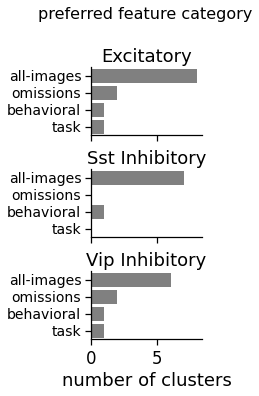

In [46]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cluster_counts = get_cluster_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='n_clusters', 
                color='gray',  ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_yticklabels(order, fontsize=14, va='center')

ax[2].set_xlabel('number of clusters')
# ax[i].set_ylabel('preferred feature')
ax[i].set_yticklabels(order, fontsize=14, va='center')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)


Text(0.5, 1.05, 'preferred feature category')

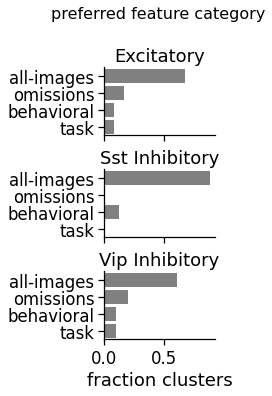

In [47]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cluster_counts = get_cluster_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='fraction', 
                color='gray',ax=ax[i]) # width=0.6, 
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[2].set_xlabel('fraction clusters')
# ax[i].set_ylabel('preferred feature')
# ax[i].set_yticklabels(order, rotation=90)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)


In [48]:
cluster_counts 

dominant_feature  n_clusters  fraction           cre_line
0       all-images           8  0.666667  Slc17a7-IRES2-Cre
1       behavioral           1  0.083333  Slc17a7-IRES2-Cre
2        omissions           2  0.166667  Slc17a7-IRES2-Cre
3             task           1  0.083333  Slc17a7-IRES2-Cre
0       all-images           7  0.875000       Sst-IRES-Cre
1       behavioral           1  0.125000       Sst-IRES-Cre
0       all-images           6  0.600000       Vip-IRES-Cre
1       behavioral           1  0.100000       Vip-IRES-Cre
2        omissions           2  0.200000       Vip-IRES-Cre
3             task           1  0.100000       Vip-IRES-Cre

In [49]:
def get_cell_counts(cluster_metrics, groupby='dominant_feature'):
    cell_counts = pd.DataFrame()

    for cre_line in cluster_metrics.cre_line.unique():
        cre_clusters = cluster_metrics[cluster_metrics.cre_line==cre_line]
        total = cre_clusters.n_cells_cluster.sum()
        count = cre_clusters.groupby(groupby).sum()[['n_cells_cluster']]
        count['fraction'] = count.n_cells_cluster / total
        count['cre_line'] = cre_line
        count = count.reset_index()
        cell_counts = pd.concat([cell_counts, count])

    return cell_counts

Text(0.5, 1.05, 'preferred feature category')

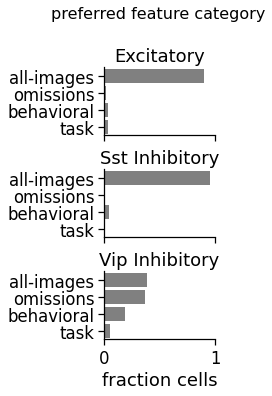

In [51]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cell_counts = get_cell_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cell_counts[cell_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='fraction', 
                color='gray',  ax=ax[i])#width=0.6,
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[2].set_xlabel('fraction cells')
# ax[i].set_ylabel('preferred feature')
# ax[i].set_xticklabels(order, rotation=90)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)

#### cluster and cell counts by pref experience level

Text(0.5, 1.05, 'preferred\nexperience level')

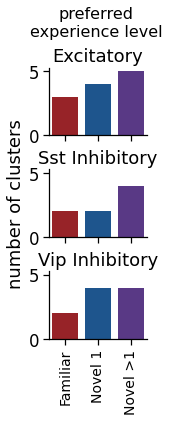

In [53]:

groupby = 'dominant_experience_level'
order = ['Familiar', 'Novel 1', 'Novel >1']

cluster_counts = get_cluster_counts(cluster_metrics, groupby)

figsize = (1.75, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='n_clusters', 
                color='gray', palette=experience_level_colors,  ax=ax[i])#width=0.5,
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[1].set_ylabel('number of clusters')
# ax[i].set_xlabel('preferred\nexperience level')
ax[i].set_xticklabels(order, rotation=90, fontsize=14)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred\nexperience level', x=0.5, y=1.05, fontsize=16)

In [84]:

# groupby = 'dominant_experience_level'
# order = ['Familiar', 'Novel 1', 'Novel >1']

# cluster_counts = get_cluster_counts(cluster_metrics, groupby)

# figsize = (2, 5)
# fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
# for i, cre_line in enumerate(cre_lines):
#     cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
#     # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
#     ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='fraction', 
#                 color='gray', width=0.5, ax=ax[i])
#     ax[i].set_ylabel('')
#     ax[i].set_xlabel('')
#     ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

# ax[1].set_ylabel('fraction clusters')
# ax[i].set_xlabel('preferred\nexperience level')
# ax[i].set_xticklabels(order, rotation=90)
# sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

# plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.05, 'preferred experience level')

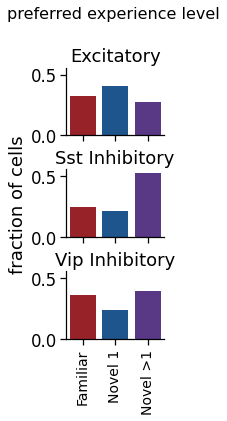

In [54]:

groupby = 'dominant_experience_level'
order = ['Familiar', 'Novel 1', 'Novel >1']

cell_counts = get_cell_counts(cluster_metrics, groupby=groupby)

figsize = (1.75, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cell_counts[cell_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='fraction', 
                color='gray', palette=experience_level_colors,  ax=ax[i]) #width=0.5,
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[1].set_ylabel('fraction of cells')
# ax[i].set_xlabel('preferred\nexperience level')
ax[i].set_xticklabels(order, rotation=90, fontsize=14)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred experience level', x=0.5, y=1.05, fontsize=16)

### sort by pref coding score then exp level

In [55]:
def sort_cluster_meta_by_feature_exp(cluster_meta, cluster_metrics):
    """
    sorts and replaces cluster_ids in cluster_meta with new cluster IDs that are orderd
    by the dominant feature then the dominant experience level of each cluster. 
    dominant feature is the coding score category (ex: images, omissions) with the strongest average coding score
    dominant experience level is the exp level with the strongest coding score for the preferred feature
    
    cluster_meta: table of metadata for each cell_specimen_id (the index) including a column 'cluster_id'
    cluster_metrics: table of metrics computed on the average coding scores for each cluster, 
                    produced by the function get_cluster_metrics_all_cre
    """
    metrics = cluster_metrics.copy()

    # get cluster IDs for all image clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='all-images'].sort_values(by='dominant_experience_level').cluster_id.unique()
    print(sorted_cluster_ids)
    n_clusters = len(sorted_cluster_ids)
    cluster_id_remap_df = pd.DataFrame(sorted_cluster_ids, np.arange(0, n_clusters))

    # get cluster IDs for omissions clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='omissions'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # get cluster IDs for behavior clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='behavioral'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # get cluster IDs for task clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='task'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # reformat column names
    cluster_id_remap_df.index.name = 'new_cluster_id'
    cluster_id_remap_df = cluster_id_remap_df.rename(columns={0: 'cluster_id'})
    cluster_id_remap_df = cluster_id_remap_df.reset_index()
    # set cluster ids to ints
    cluster_id_remap_df['cluster_id'] = [int(cluster_id) for cluster_id in cluster_id_remap_df.cluster_id.values]

    # merge remapped IDs into cluster meta
    cluster_meta_tmp = cluster_meta.reset_index().merge(cluster_id_remap_df, on='cluster_id').copy()
    cluster_meta_tmp = cluster_meta_tmp.set_index('cell_specimen_id')
    cluster_meta = cluster_meta_tmp.copy()

    return cluster_meta

In [87]:
# cluster_meta = sort_cluster_meta_by_feature_exp(cluster_meta, cluster_metrics)

In [88]:
# cluster_meta_tmp = cluster_meta.reset_index().merge(cluster_id_remap_df, on='cluster_id').copy()
# cluster_meta_tmp = cluster_meta_tmp.set_index('cell_specimen_id')

# plot_all_cre_clustering_heatmap(cluster_meta, feature_matrix, sort_by='new_cluster_id', orient='horiz', session_colors=True,
#                                     save_dir=save_dir, folder=folder, ax=None)

### split by cre line and plot heatmaps

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_meta_cre.cluster_id.values]


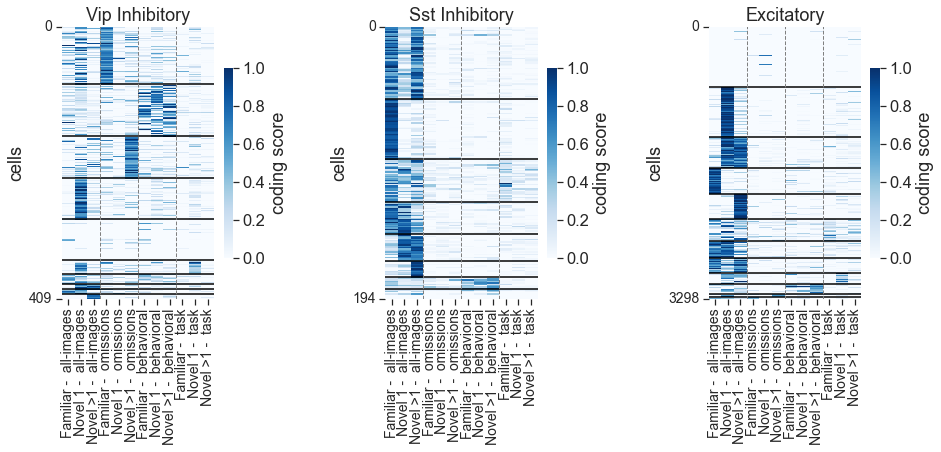

In [89]:
# plot feature matrix sorted by cluster ID
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    save_dir=None, folder=folder)

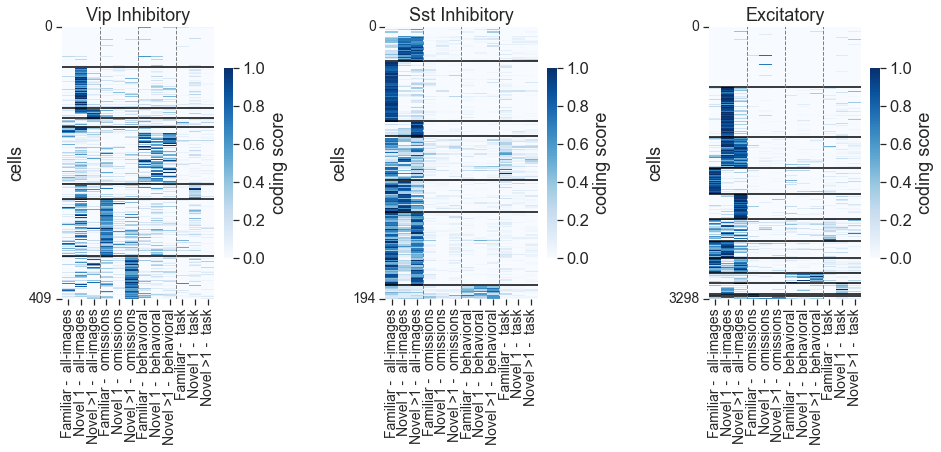

In [90]:
# plot feature matrix sorted by cluster ID
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', resort_by_size=False,
                                save_dir=save_dir, folder=folder)

### average dropouts per cluster

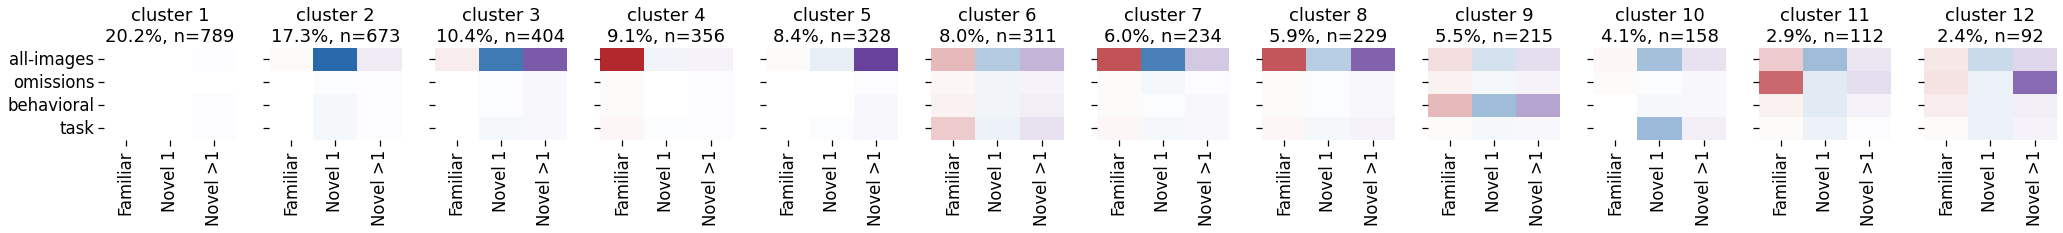

In [57]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)


feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id+1) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+str(n_clusters))

#### averages per cre line

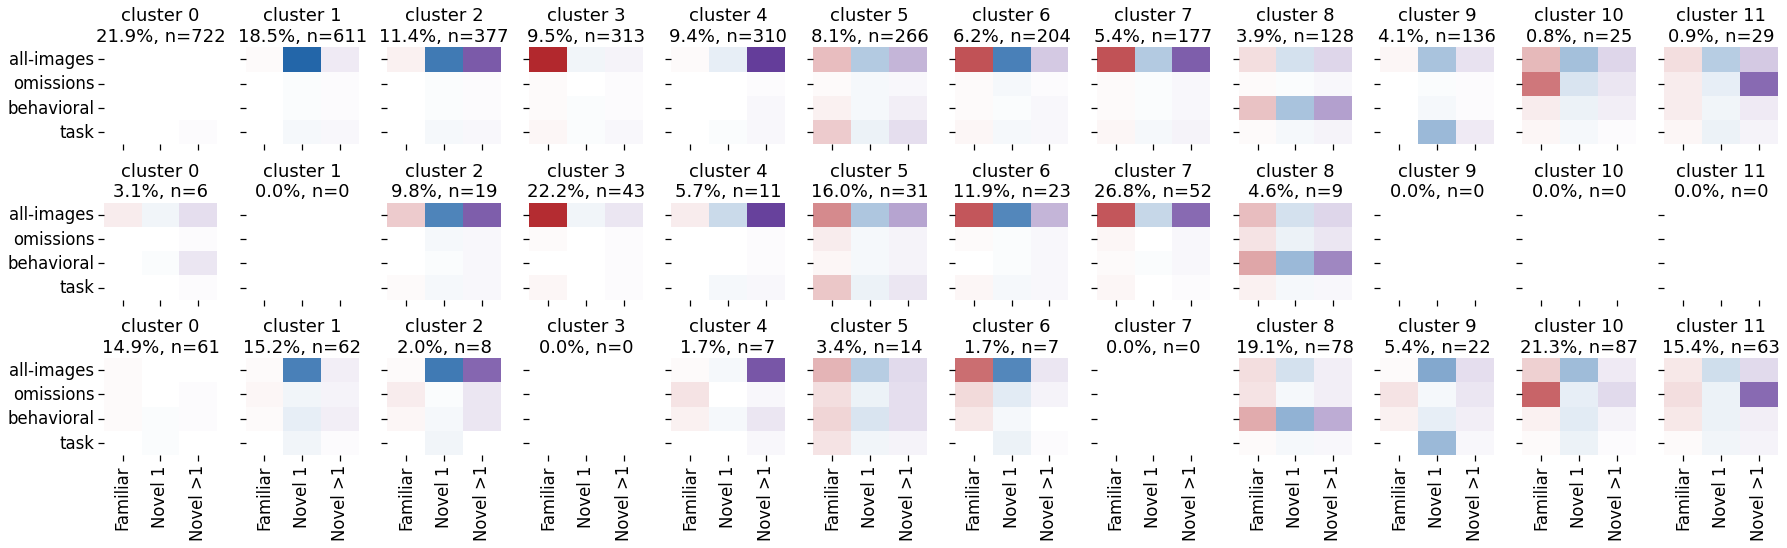

In [58]:
# all cre lines on one plot

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)

clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

figsize = (2.5*n_clusters, 2.5*3)
fig, ax = plt.subplots(3, n_clusters, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

i=0
for c, cre_line in enumerate(np.sort(cluster_meta.cre_line.unique())):
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    # loop through clusters in sorted order
    for x, cluster_id in enumerate(clusters):
        try:
            this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
            mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
            ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
            # fraction is number of cells in this cluster vs all cells in this cre line
            fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
            fraction = np.round(fraction_cluster * 100, 1)
            # set title and labels
            ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
            ax[i].set_xlabel('')
        except:
            pass
        i+=1
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    # plt.suptitle(cre_line, x=0.46, y=1.)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped')

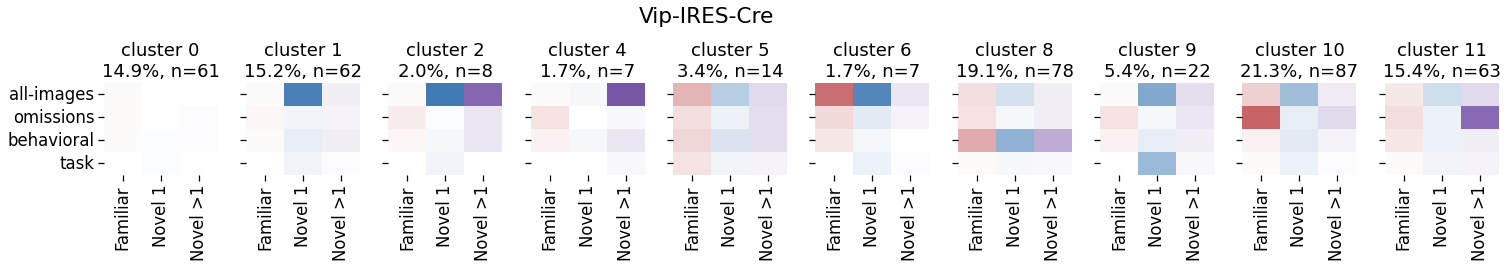

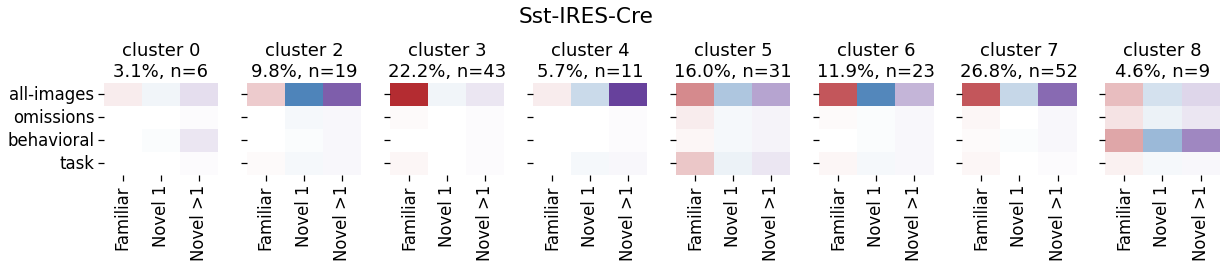

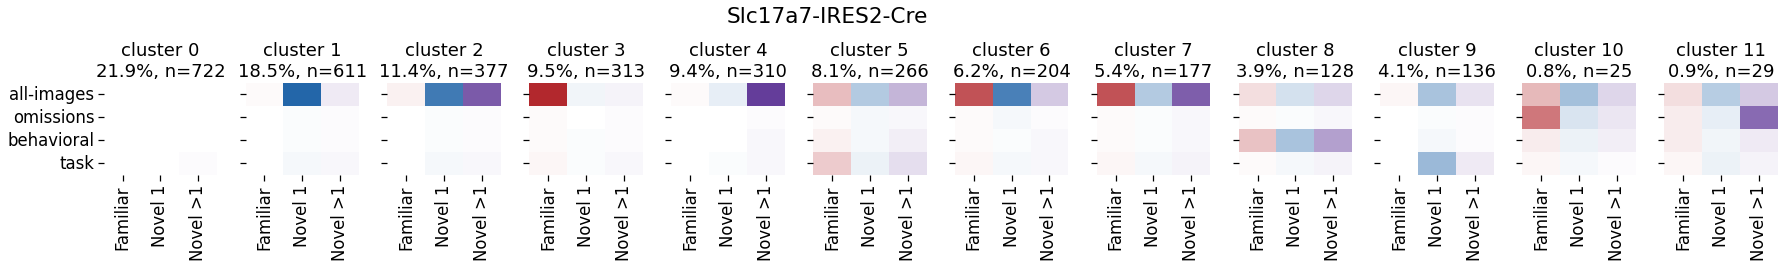

In [59]:
# plot each cre line separately

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    clusters = np.sort(cre_cluster_meta['cluster_id'].unique())
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+cre_line.split('-')[0])

#### sort by cluster size within cre, exclude clusters with <10% cells

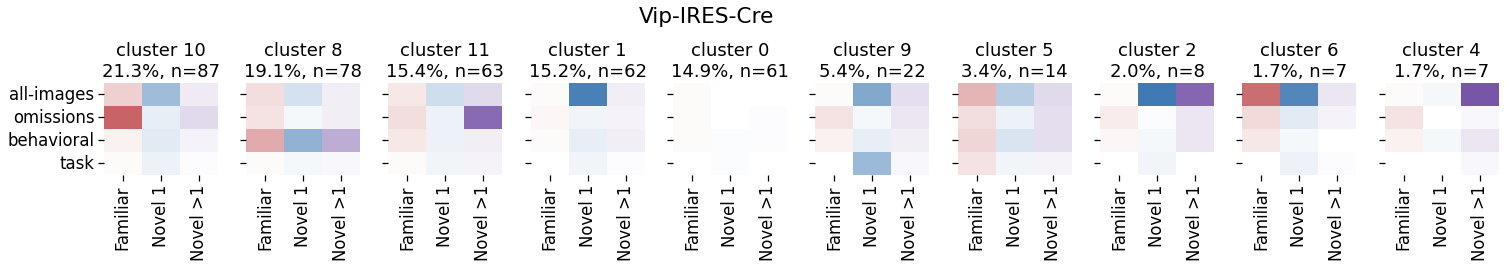

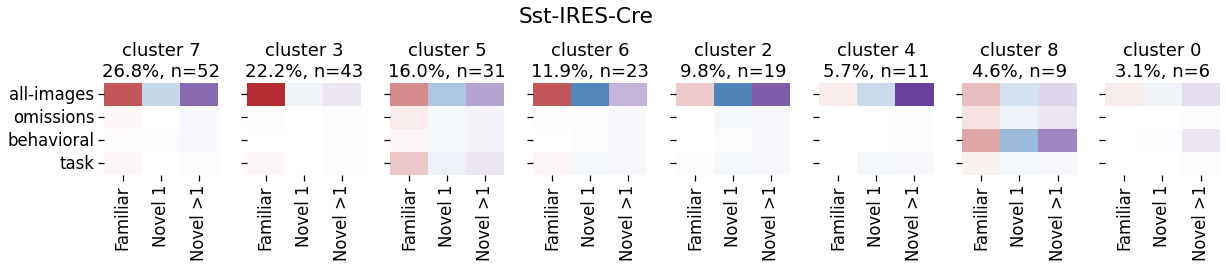

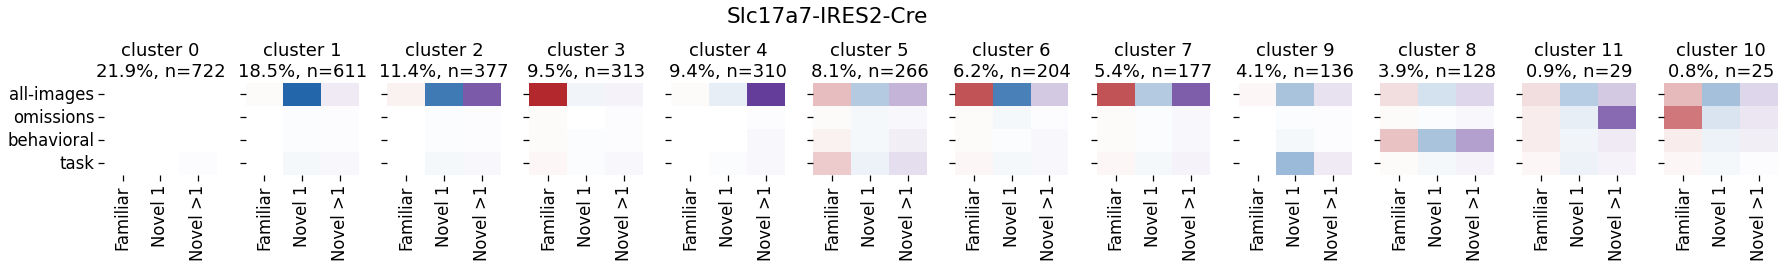

In [60]:
# plot clusters in order of sort_col

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    clusters = cre_cluster_meta['cluster_id'].value_counts().index.values    
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_sorted_'+cre_line.split('-')[0])

In [95]:
# plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col='cluster_id', 
#                                             save_dir=save_dir, folder=folder)

In [96]:
# # plot each separately
# clusters = np.sort(cluster_meta['cluster_id'].unique())
# n_clusters_to_plot = len(clusters)

# abbreviate_features = True
# abbreviate_experience = True

# # loop through clusters and plot each one with abbreviated labels
# for i, cluster_id in enumerate(clusters):
#     figsize=(2,1.7)
#     fig, ax = plt.subplots(figsize=figsize)
#     this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
#     mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
#     ax = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax, cbar=False, cbar_kws={'label': 'coding score'})
#     # fraction is number of cells in this cluster vs all cells in this cre line
#     fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
#     fraction = np.round(fraction_cluster * 100, 1)
#     # set title and labels
#     ax.set_title('cluster ' + str(cluster_id))
# #     ax.set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
#     ax.set_xlabel('')
#     if abbreviate_features:
#         # set yticks to abbreviated feature labels
#         feature_abbreviations = plotting.get_abbreviated_features(mean_dropout_df.index.values)
#         ax.set_yticklabels(feature_abbreviations, rotation=0)
#     else:
#         ax.set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
#     if abbreviate_experience:
#         # set xticks to abbreviated experience level labels
#         exp_level_abbreviations = plotting.get_abbreviated_experience_levels(mean_dropout_df.columns.values)
#         ax.set_xticklabels(exp_level_abbreviations, rotation=90)
#     else:
#         ax.set_xticklabels(mean_dropout_df.columns.values, rotation=90, fontsize=14)
    
#     if test_save_dir:
#         utils.save_figure(fig, figsize, save_dir, 'folder,
#                           'mean_cluster_heatmap_cluster_'+str(i))

### within cluster correlation

NameError: name 'plot_within_cluster_correlations_for_cre_line' is not defined

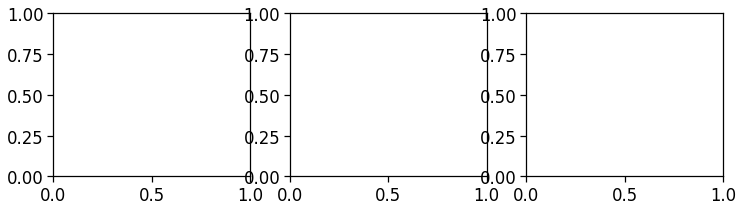

In [61]:
n_clusters_cre = {}
for cre in cre_lines: 
    n_clusters_cre[cre] = len(cluster_meta.cluster_id.unique())
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, suffix='', save_dir=save_dir, folder=folder)

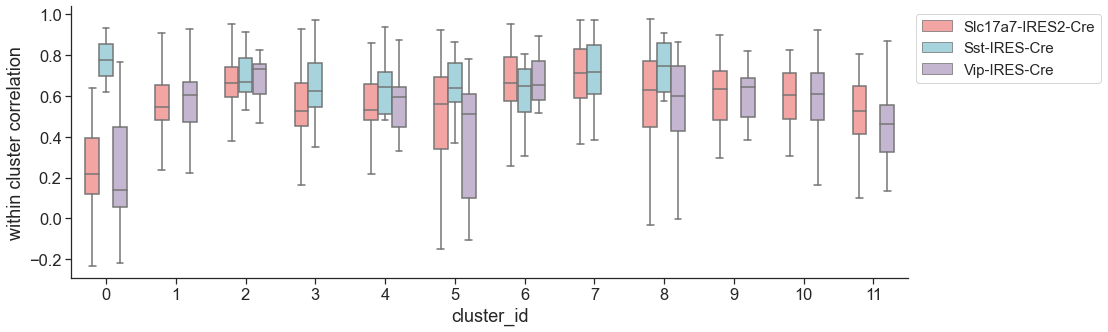

In [98]:
figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=cluster_meta, x='cluster_id', y='within_cluster_correlation', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, width=0.6, showfliers=False, ax=ax)
ax.set_ylabel('within cluster correlation')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

### cre line proportions per cluster

In [99]:
def get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group='mouse_id'):
    """
    counts the number of cells a given condition, and the number of cells in each cluster for that given ocndition,
    then computes the proportion of cells in each cluster for the given condition
    col_to_group: can be 'cre_line', 'mouse_id', etc
    """
    # get number of cells in each group defined by col_to_group
    n_cells_group = cluster_meta.groupby([col_to_group]).count()[['cluster_id']].reset_index().rename(columns={'cluster_id':'n_cells_group'})
    # get number of cells in each cluster for each group
    n_cells_per_cluster = cluster_meta.groupby([col_to_group, 'cluster_id']).count()[['ophys_experiment_id']].reset_index().rename(columns={'ophys_experiment_id':'n_cells_cluster'})
    # add n cells per cluster per group to total number of cells per group and compute the fraction per cluster in each group
    n_cells_per_cluster = n_cells_per_cluster.merge(n_cells_group, on=col_to_group)
    n_cells_per_cluster['fraction_per_cluster'] = n_cells_per_cluster.n_cells_cluster/n_cells_per_cluster.n_cells_group
    
    return n_cells_per_cluster

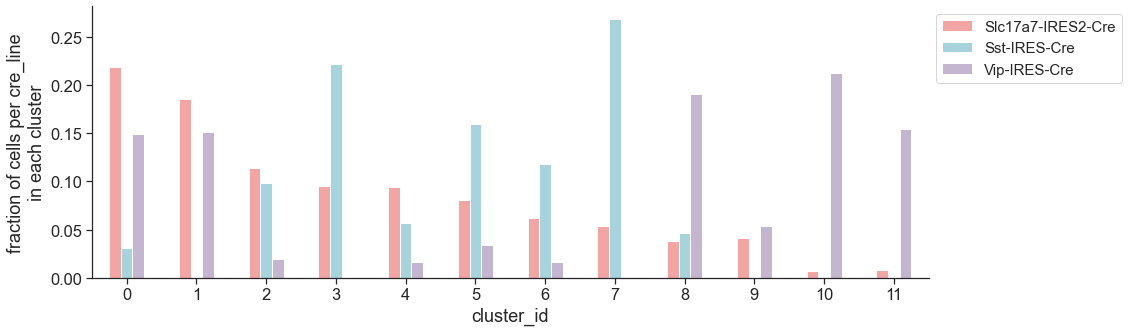

In [133]:
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue=col_to_group, hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

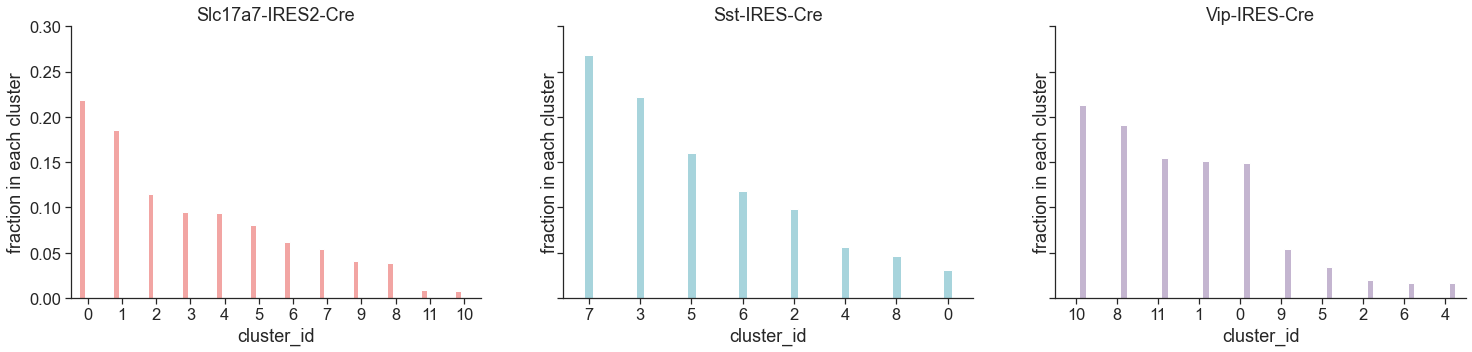

In [101]:
# sorted within cre
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (25,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre in enumerate(cre_lines):
    cre_data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre]
    order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x='cluster_id', order=order, y='fraction_per_cluster', 
                hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax[i])
    ax[i].set_ylabel('fraction in each cluster')
    ax[i].get_legend().remove()
    ax[i].set_ylim(0, 0.3)
#     ax[i].legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')
    ax[i].set_title(cre)

### per mouse

In [102]:
col_to_group = 'mouse_id'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)
n_cells_per_cluster = n_cells_per_cluster.merge(experiments_table[['mouse_id', 'cre_line']], on='mouse_id')
n_cells_per_cluster = n_cells_per_cluster.drop_duplicates(subset=['mouse_id', 'cluster_id'])
n_cells_per_cluster

mouse_id  cluster_id  n_cells_cluster  n_cells_group  \
0      412036           0                2             28   
3      412036           1                4             28   
6      412036           2                1             28   
9      412036           6                2             28   
12     412036           8                1             28   
...       ...         ...              ...            ...   
3270   549976           0                2              8   
3273   549976           3                1              8   
3276   549976           4                1              8   
3279   549976           7                3              8   
3282   549976           8                1              8   

      fraction_per_cluster      cre_line  
0                 0.071429  Vip-IRES-Cre  
3                 0.142857  Vip-IRES-Cre  
6                 0.035714  Vip-IRES-Cre  
9                 0.071429  Vip-IRES-Cre  
12                0.035714  Vip-IRES-Cre  
...                    ...           ...  
3270              0.250000  Sst-IRES-Cre  
3273              0.125000  Sst-IRES-Cre  
3276              0.125000  Sst-IRES-Cre  
3279              0.375000  Sst-IRES-Cre  
3282              0.125000  Sst-IRES-Cre  

[492 rows x 6 columns]

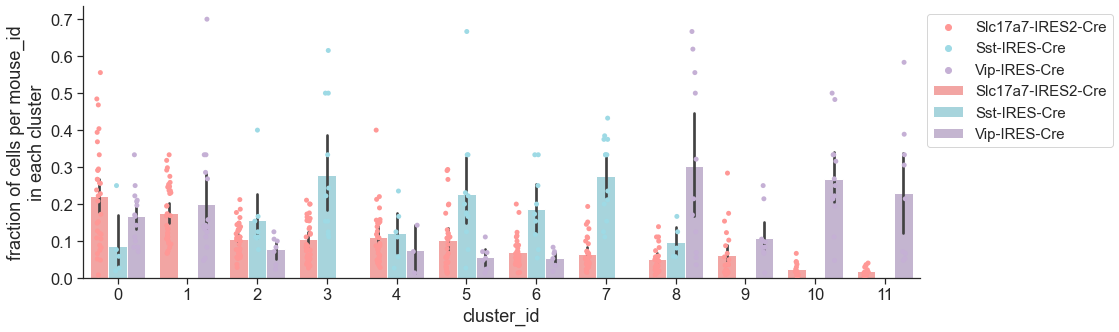

In [103]:
figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

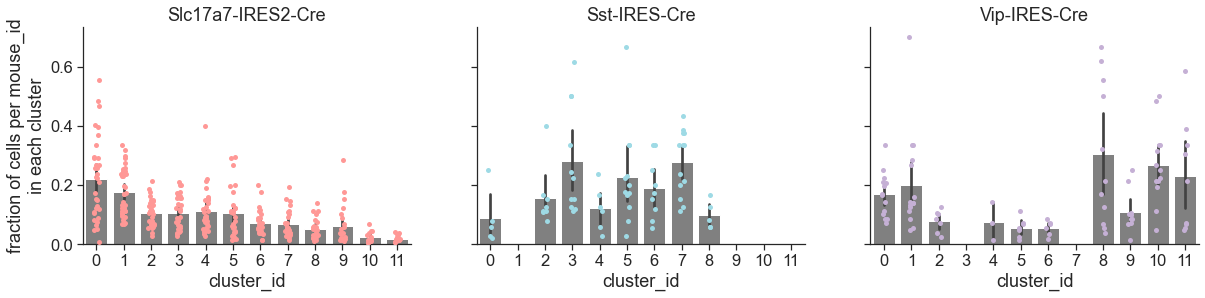

In [104]:
figsize = (20,4)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre_line]
    ax[i] = sns.stripplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                          order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color=cre_line_colors[i], ax=ax[i])
    ax[i] = sns.barplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                        order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color='gray', ax=ax[i])
    ax[i].set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
    ax[i].set_title(cre_line)

### is 15 clusters reasonable?

### eigengap

In [105]:
# k_max=25
# X = feature_matrix.values
# sc = SpectralClustering(n_clusters)  # N of clusters does not impact affinity matrix
# # but you can obtain affinity matrix only after fitting, thus some N of clusters must be provided.
# sc.fit(X)
# A = sc.affinity_matrix_
# eigenvalues, eigenvectors, nb_clusters = processing.get_eigenDecomposition(A, max_n_clusters=k_max)

In [106]:
# figsize = (10, 4)
# fig, ax = plt.subplots(figsize=figsize)
# # ax.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, '-o')
# # ax.set_ylabel('Eigen values \n(sorted)')
# # ax.set_xlabel('Eigen number')
# # ax.set_xlim([0, 20])
# # ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

# ax.plot(np.arange(2, len(eigenvalues) + 1), np.diff(eigenvalues), '-o')
# ax.set_ylabel('Eigengap value \n(difference)')
# ax.set_xlabel('Eigen number')
# ax.set_xlim([0, 20])
# # ax.set_ylim([0, 0.20])
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')
# plt.tight_layout()

# if test_save_dir:
#     utils.save_figure(fig, figsize, test_save_dir, 'figs', 'eigengap')

### gap statistic

In [107]:
# X = feature_matrix.values
# feature_matrix_shuffled = processing.shuffle_dropout_score(feature_matrix, shuffle_type='all')
# reference = feature_matrix_shuffled.values
# sc = SpectralClustering()
# gap_statistic, reference_inertia, ondata_inertia = processing.compute_gap(sc, X, k_max=25, reference_shuffle=reference, 
#                                                                 metric='euclidean', n_boots=20)

In [108]:
# figsize = (10, 4)
# fig, ax = plt.subplots(figsize=figsize)

# ax.plot(np.arange(1, x + 1), gap_statistic['reference_inertia'], 'o-')
# ax.plot(np.arange(1, x + 1), gap_statistic['ondata_inertia'], 'o-')
# ax.legend(['reference inertia', 'ondata intertia'])
# ax.set_ylabel('Natural log of euclidean \ndistance values')
# ax.set_xlabel('Number of clusters')
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

# ax.plot(np.arange(1, x + 1), gap_statistic['gap'], 'o-')
# ax.set_ylabel('Gap statistic')
# ax.set_xlabel('Number of clusters')
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

### compute metrics on dropout scores for each cell

In [109]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1434: RuntimeWarning: invalid value encountered in double_scalars
  exp_mod_persistence = (row['Novel >1']-row['Novel 1'])/(row['Novel >1']+row['Novel 1'])
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1415: RuntimeWarning: invalid value encountered in double_scalars
  feature_selectivity = (values[0] - (np.mean(values[1:]))) / (values[0] + (np.mean(values[1:])))
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1419: RuntimeWarning: invalid value encountered in double_scalars
  experience_selectivity = (values[0] - (np.mean(values[1:]))) / (values[0] + (np.mean(values[1:])))
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1427: RuntimeWarning:

metrics: 
* exp_mod_direction = N - F / N + F
* exp_mod_persistence = N+ - N / N+ + N

In [110]:
print(len(coding_score_metrics.mouse_id.unique()), 'mice')
print(len(coding_score_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(coding_score_metrics.index.unique()), 'cells')

65 mice
131 experiments
3901 cells


In [111]:
cluster_meta

ophys_experiment_id           cre_line  cluster_id  labels  \
cell_specimen_id                                                               
1086489847                 1003771765       Vip-IRES-Cre           8       1   
1086489860                 1003771765       Vip-IRES-Cre           1       5   
1086489891                 1003771765       Vip-IRES-Cre           8       1   
1086489976                  962471831       Sst-IRES-Cre           3       9   
1086490002                  962471831       Sst-IRES-Cre           3       9   
...                               ...                ...         ...     ...   
1120133342                 1086707474  Slc17a7-IRES2-Cre           0       4   
1120133375                 1086707474  Slc17a7-IRES2-Cre           1       5   
1120133471                 1086707474  Slc17a7-IRES2-Cre           3       9   
1120133515                 1086707474  Slc17a7-IRES2-Cre           2       7   
1120133649                 1086707474  Slc17a7-IRES2-Cre           1       5   

                  within_cluster_correlation equipment_name  \
cell_specimen_id                                              
1086489847                          0.477738        CAM2P.3   
1086489860                          0.532181        CAM2P.3   
1086489891                          0.638229        CAM2P.3   
1086489976                          0.480384        CAM2P.5   
1086490002                          0.761853        CAM2P.5   
...                                      ...            ...   
1120133342                               NaN         MESO.1   
1120133375                          0.541558         MESO.1   
1120133471                          0.550737         MESO.1   
1120133515                          0.532379         MESO.1   
1120133649                          0.650350         MESO.1   

                                                      full_genotype mouse_id  \
cell_specimen_id                                                               
1086489847            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   486737   
1086489860            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   486737   
1086489891            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   486737   
1086489976            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   467302   
1086490002            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   467302   
...                                                             ...      ...   
1120133342        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
1120133375        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
1120133471        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
1120133515        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   
1120133649        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...   547486   

                               reporter_line                      driver_line  \
cell_specimen_id                                                                
1086489847        Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
1086489860        Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
1086489891        Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   
1086489976        Ai148(TIT2L-GC6f-ICL-tTA2)                   [Sst-IRES-Cre]   
1086490002        Ai148(TIT2L-GC6f-ICL-tTA2)                   [Sst-IRES-Cre]   
...                                      ...                              ...   
1120133342                Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1120133375                Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1120133471                Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1120133515                Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   
1120133649                Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   

                  ...  layer  area_layer      date  first_nove

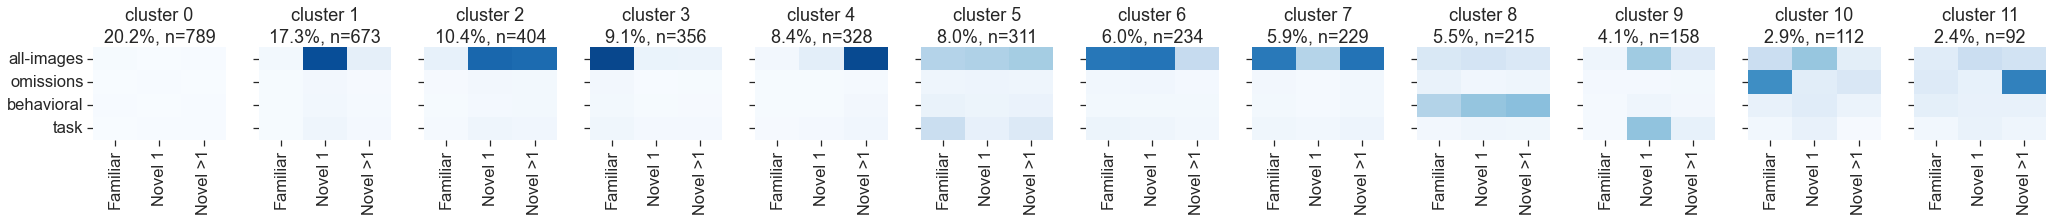

In [112]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)

figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_'+str(n_clusters))

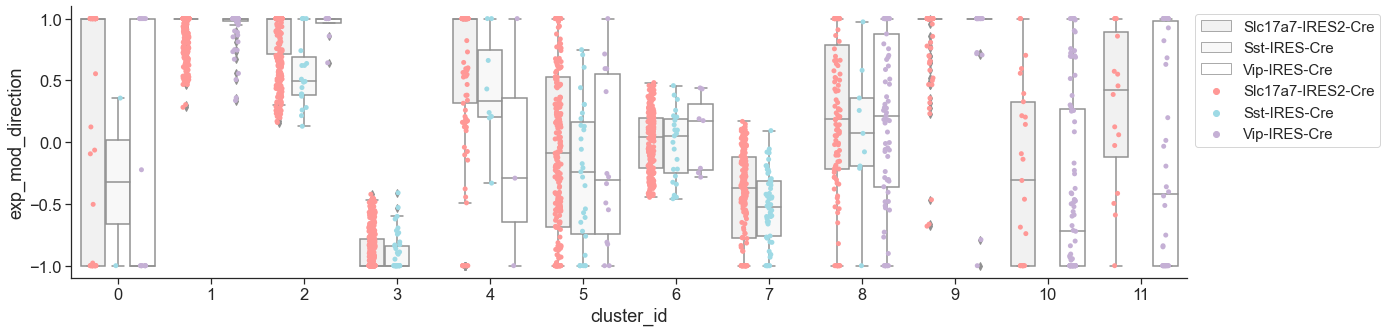

In [113]:
metric = 'exp_mod_direction'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [114]:
n_clusters = len(coding_score_metrics.cluster_id.unique())

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


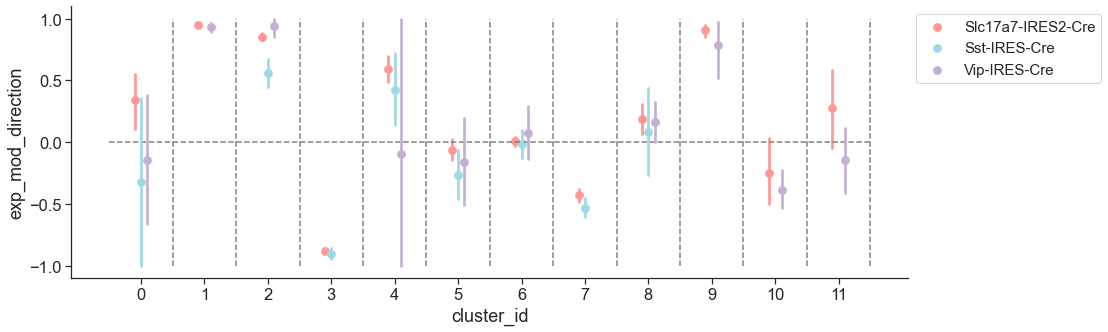

In [115]:
metric = 'exp_mod_direction'

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

for x in np.arange(0.5, n_clusters, 1):
    ax.vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
ax.hlines(y=0, xmin=-0.5, xmax=n_clusters-0.5, color='gray', linestyle='--')

#### persistence of coding

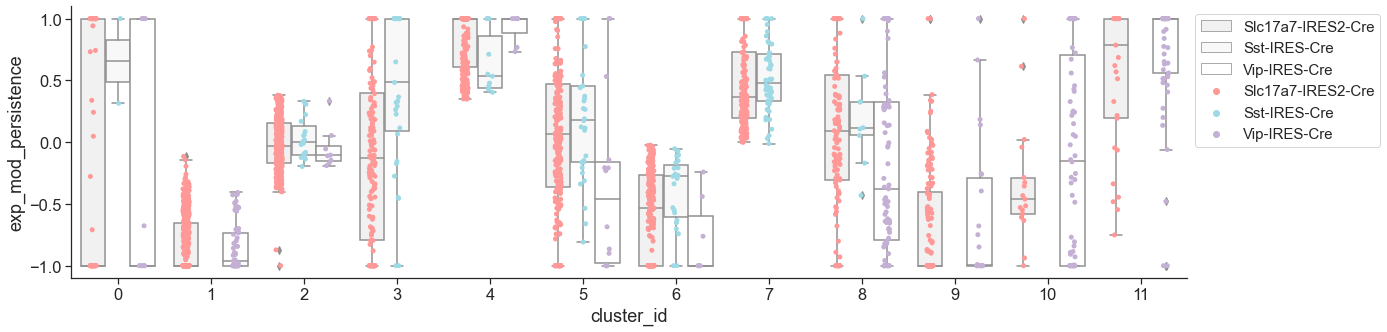

In [116]:
metric = 'exp_mod_persistence'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [117]:
# take absolute value so its just whether it is transient or not, regardless of direction
coding_score_metrics['transience'] = np.abs(coding_score_metrics.exp_mod_persistence.values)

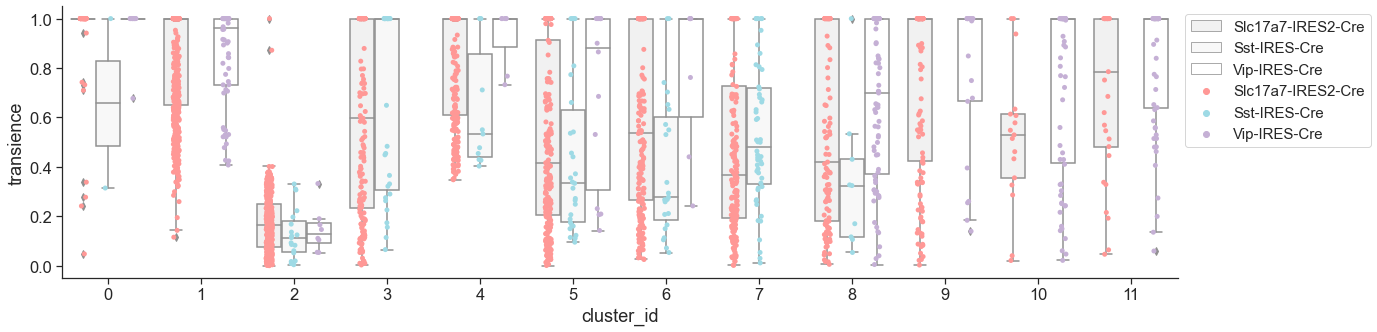

In [118]:
metric = 'transience'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


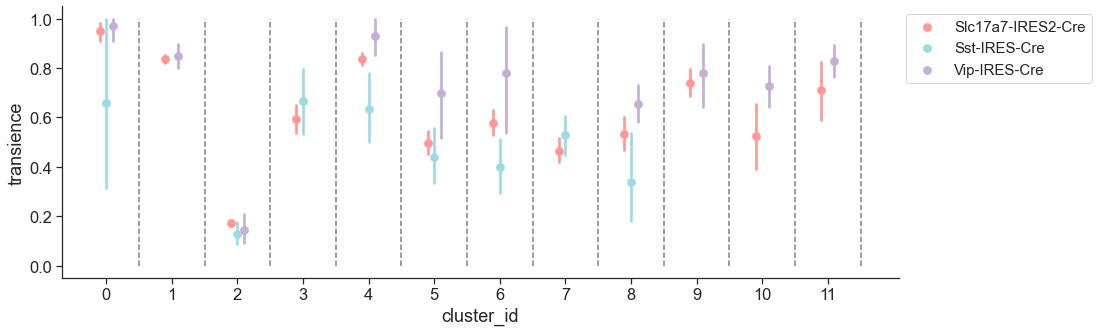

In [134]:
metric = 'transience'

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

for x in np.arange(0.5, n_clusters, 1):
    ax.vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')

In [120]:
# # vertical plot
# metric = 'persistence'

# figsize = (5, 10)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.pointplot(data=coding_score_metrics, y='cluster_id', x=metric, orient='h',
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.3, ax=ax)
# # ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
# #             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_xlabel(metric)
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

# for y in np.arange(0.5, len(coding_score_metrics.cluster_id.unique()), 1):
#     ax.hlines(y=y, xmin=0, xmax=1, color='gray', linestyle='--')

### model free metrics

In [121]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

Response metrics table contains one row per cell per experiment

In [122]:
data_type = 'events'

condition = 'images'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|██████████| 402/402 [01:22<00:00,  4.88it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 402 experiments in the returned cell_metrics table


In [123]:
# convert experience level

response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in response_metrics.experience_level.values]

In [124]:
# limit to matched cells
response_metrics = response_metrics[response_metrics.cell_specimen_id.isin(matched_cells)]
len(response_metrics)

11763

In [125]:
print(len(response_metrics.mouse_id.unique()), 'mice')
print(len(response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(response_metrics.cell_specimen_id.unique()), 'cells')

65 mice
393 experiments
3921 cells


In [126]:
print(len(cluster_meta.mouse_id.unique()), 'mice')
print(len(cluster_meta.index.unique()), 'cells')

65 mice
3901 cells


In [127]:
response_metrics = response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [128]:
response_metrics.head()

cell_specimen_id pref_image non_pref_image  image_selectivity_index  \
0        1086490397      im085          im066                 0.893696   
1        1086490397      im045          im031                 0.994874   
2        1086490397      im045          im031                 0.883652   
3        1086490441      im062          im069                 0.967718   
4        1086490441      im000          im106                 0.987817   

   image_selectivity_index_one_vs_all  lifetime_sparseness  mean_response  \
0                            0.586110             0.445412       0.000368   
1                            0.537612             0.425973       0.002768   
2                            0.605973             0.476856       0.000142   
3                            0.836564             0.822807       0.003083   
4                            0.677912             0.619362       0.010966   

   fraction_significant_p_value_gray_screen  fano_factor  reliability  ...  \
0                                  0.000000    15.966643     0.098696  ...   
1                                  0.119145     6.548325     0.131608  ...   
2                                  0.015451    19.134805     0.020160  ...   
3                                  0.072696     9.607842     0.012195  ...   
4                                  0.224477     4.760831     0.118330  ...   

   area_layer      date first_novel n_relative_to_first_novel last_familiar  \
0  VISp_upper  20181213       False                      -1.0          True   
1  VISp_upper  20181214        True                       0.0         False   
2  VISp_upper  20181216       False                       2.0         False   
3  VISp_upper  20181213       False                      -1.0          True   
4  VISp_upper  20181214        True                       0.0         False   

  last_familiar_active  second_novel  second_novel_active  \
0                 True         False                False   
1                False         False                False   
2                False         False                 True   
3                 True         False                False   
4                False         False                False   

   experience_exposure cluster_id  
0           Familiar 3         10  
1              Novel 0         10  
2              Novel 2         10  
3           Familiar 3          1  
4              Novel 0          1  

[5 rows x 60 columns]

In [129]:
metrics = ['image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index',]

In [130]:
cluster_ids = cluster_meta.cluster_id.unique()
n_clusters = len(cluster_ids)


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


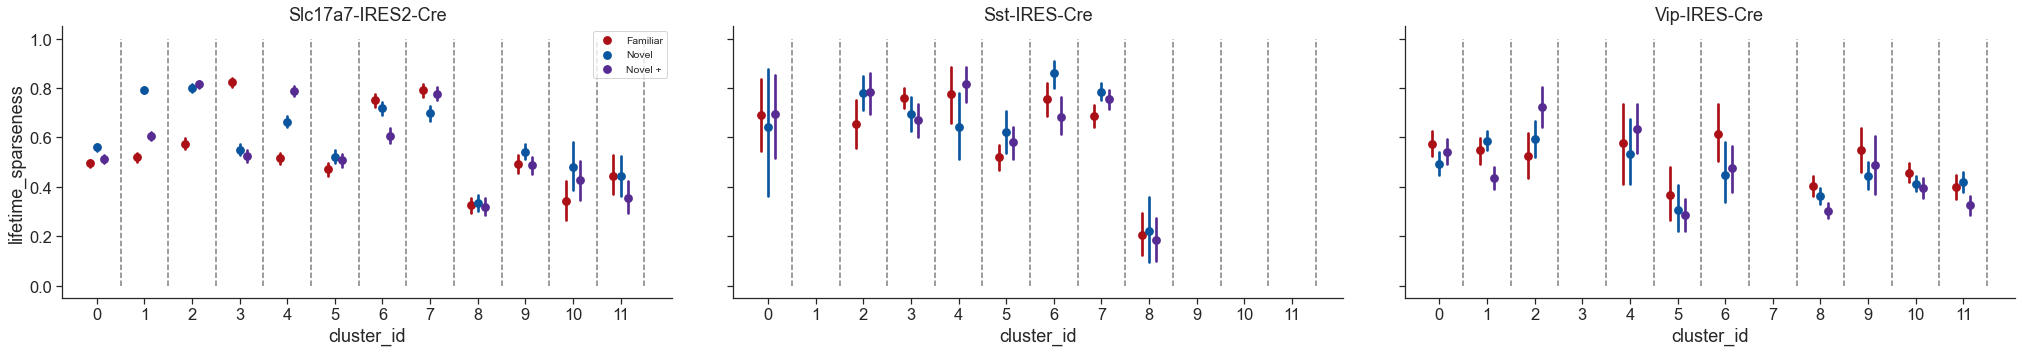

In [135]:
metric = 'lifetime_sparseness'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
# metric = 'reliability'

# order = np.arange(0, n_clusters, 1)

# figsize = (35,5)
# fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
# for i, cre_line in enumerate(cre_lines):
#     data = response_metrics[response_metrics.cre_line==cre_line]
#     ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
#                 hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
#                           join=False, dodge=0.3, ax=ax[i])
#     ax[i].set_title(cre_line)
#     ax[i].get_legend().remove()
#     ax[i].set_ylabel('')
#     for x in np.arange(0.5, n_clusters, 1):
#         ax[i].vlines(x=x, ymin=0, ymax=0.5, color='gray', linestyle='--')
    
# ax[0].set_ylabel(metric)
# ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

# plt.subplots_adjust(wspace=0.1)

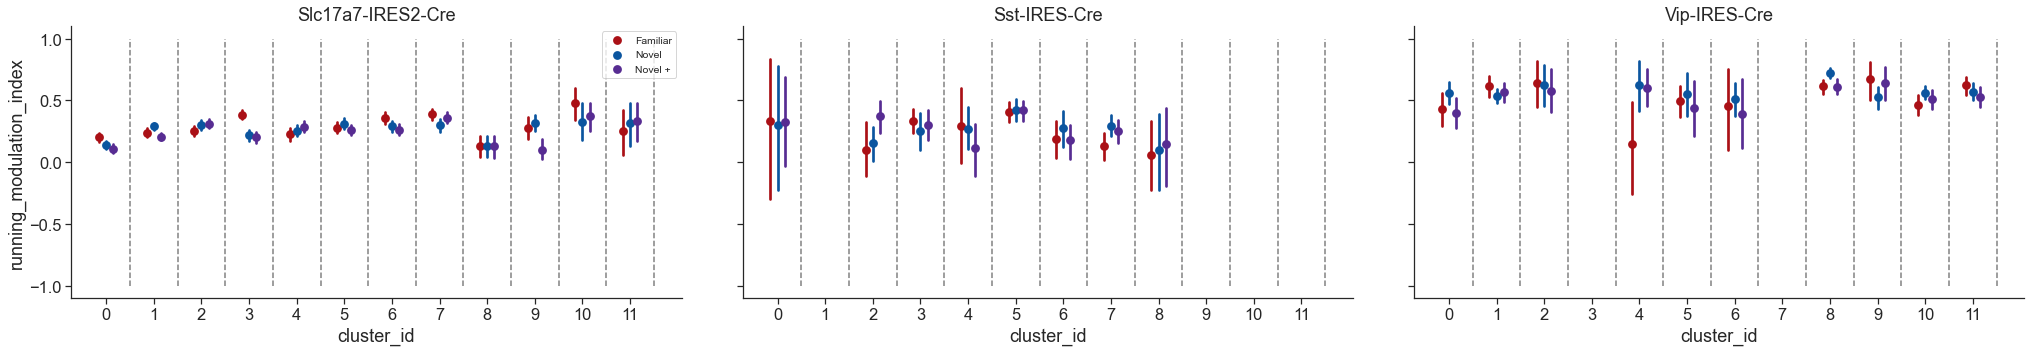

In [138]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

### preferred stimulus response reliability

In [139]:
data_type = 'events'

condition = 'images'
stimuli = 'pref_image'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
pref_stim_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|██████████| 402/402 [01:24<00:00,  4.76it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 402 experiments in the returned cell_metrics table


In [140]:
# convert experience level
pref_stim_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in pref_stim_response_metrics.experience_level.values]
# limit to matched cells
pref_stim_response_metrics = pref_stim_response_metrics[pref_stim_response_metrics.cell_specimen_id.isin(matched_cells)]
# add cluster ID
pref_stim_response_metrics = pref_stim_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


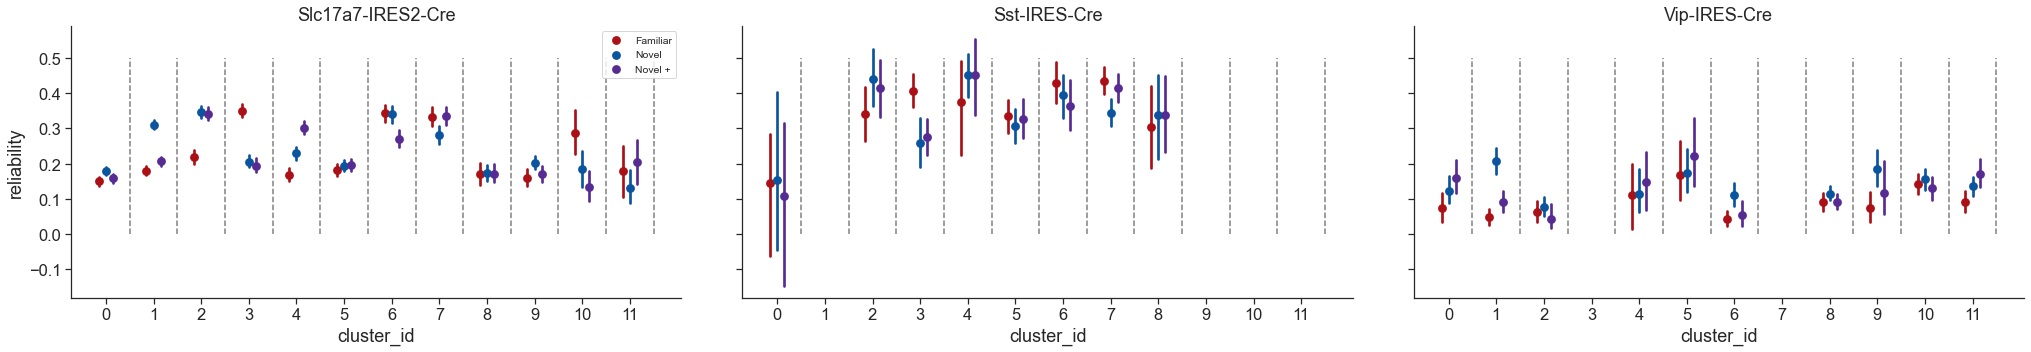

In [141]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=0.5, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

### omission responses per cluster 

In [142]:
data_type = 'events'

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
omission_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|██████████| 402/402 [01:29<00:00,  4.49it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 402 experiments in the returned cell_metrics table


In [143]:
omission_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in omission_response_metrics.experience_level.values]

In [144]:
# limit to matched cells
omission_response_metrics = omission_response_metrics[omission_response_metrics.cell_specimen_id.isin(matched_cells)]
len(omission_response_metrics)

print(len(omission_response_metrics.mouse_id.unique()), 'mice')
print(len(omission_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(omission_response_metrics.cell_specimen_id.unique()), 'cells')

omission_response_metrics = omission_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

65 mice
393 experiments
3921 cells


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


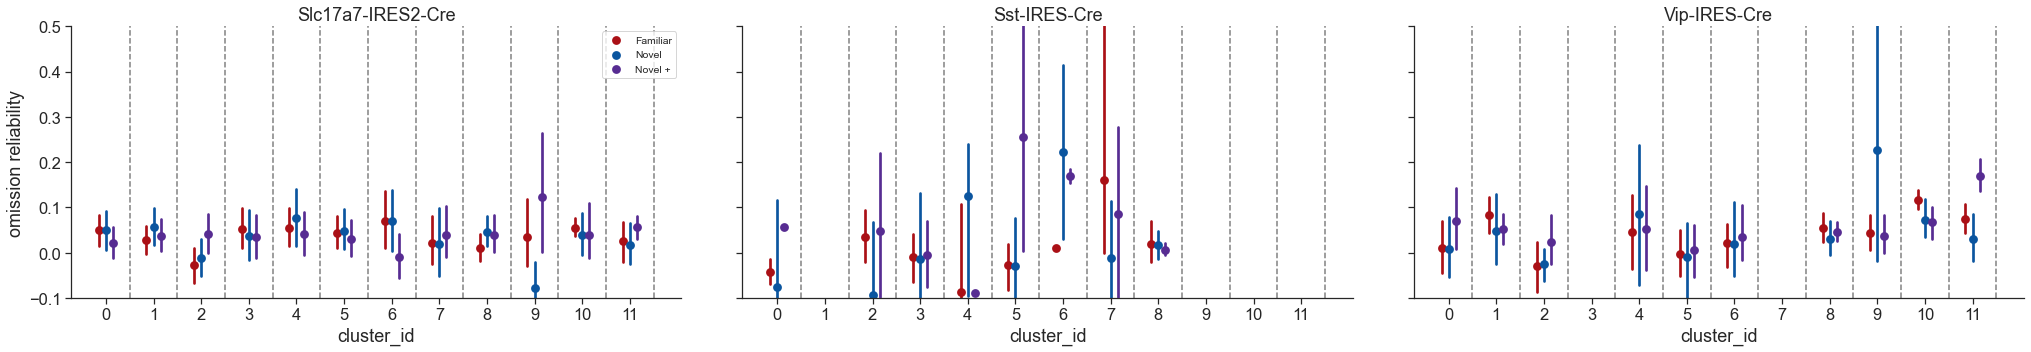

In [145]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-0.1, ymax=0.5, color='gray', linestyle='--')
    ax[i].set_ylim(-0.1, 0.5)
    
ax[0].set_ylabel('omission reliability')
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

#### change response metrics

In [146]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [147]:
data_type = 'events'

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
change_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|██████████| 402/402 [01:25<00:00,  4.68it/s]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 402 experiments in the returned cell_metrics table


In [148]:
# convert experience level 
change_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in change_response_metrics.experience_level.values]

In [149]:
# limit to matched cells
change_response_metrics = change_response_metrics[change_response_metrics.cell_specimen_id.isin(matched_cells)]
len(change_response_metrics)

print(len(change_response_metrics.mouse_id.unique()), 'mice')
print(len(change_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(change_response_metrics.cell_specimen_id.unique()), 'cells')

change_response_metrics = change_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

65 mice
393 experiments
3921 cells


In [150]:
change_response_metrics.keys()

Index(['cell_specimen_id', 'pref_image', 'non_pref_image',
       'image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index', 'hit_miss_index',
       'is_change', 'change_response', 'pre_change', 'pre_change_response',
       'change_modulation_index', 'ophys_experiment_id', 'condition',
       'session_subset', 'stimuli', 'data_type', 'interpolate',
       'output_sampling_rate', 'response_window', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


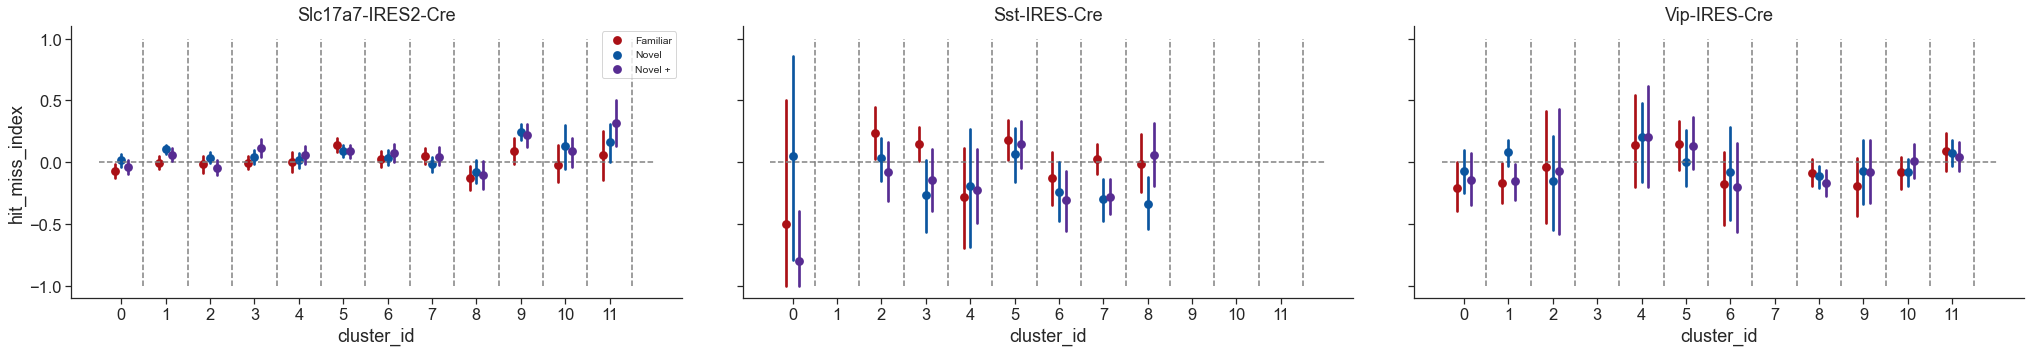

In [151]:
metric = 'hit_miss_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


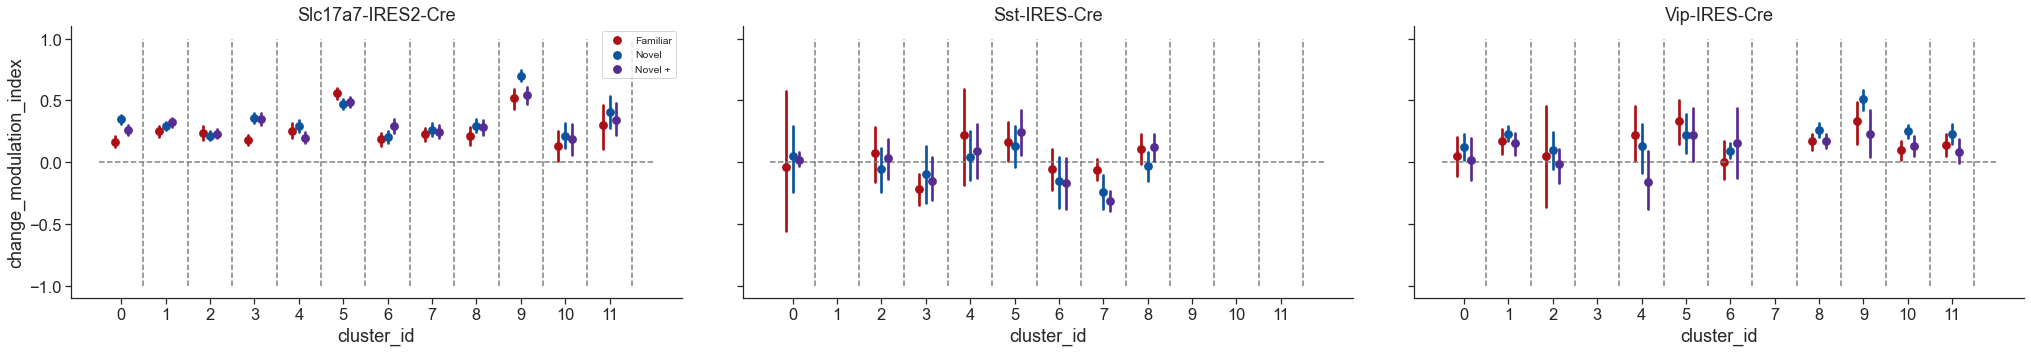

In [152]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


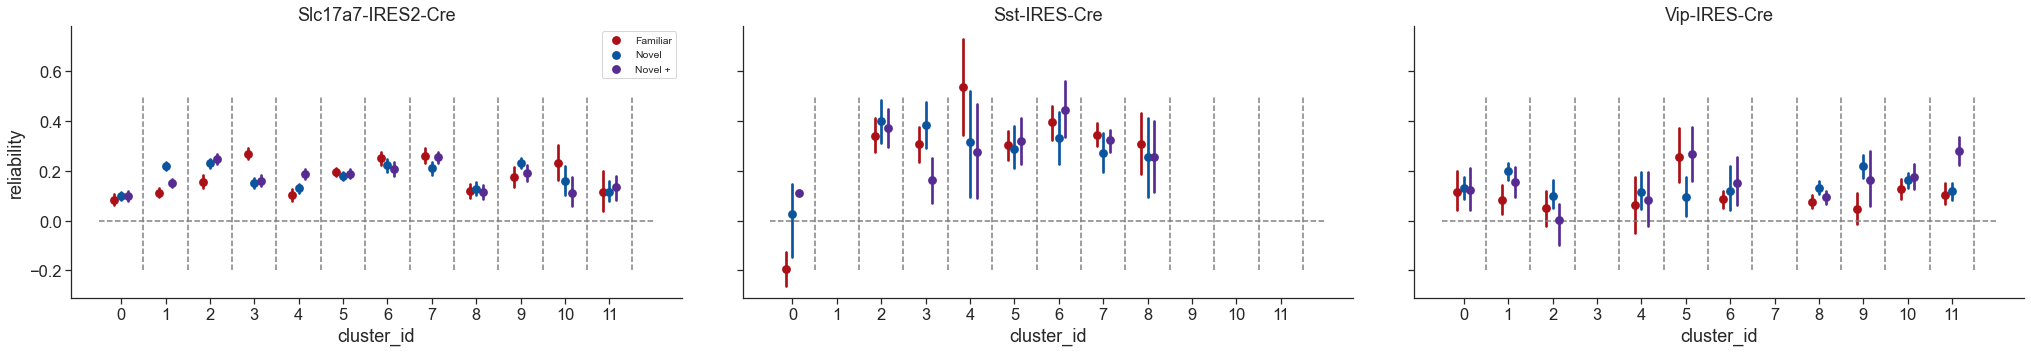

In [153]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-0.2, ymax=0.5, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

# plot clusters individually with metric values

What is available?
* coding_score_metrics
* response_metrics
* omission_response_metrics
* change_response_metrics
* fraction cells per cluster

In [154]:
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)


## test each plot

### dropout heatmaps

<AxesSubplot:title={'center':'cluster 1\n17.3%, n=673'}>

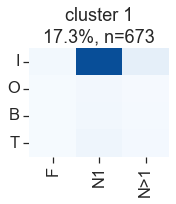

In [155]:
cluster_id = 1

plotting.plot_dropout_heatmap(cluster_meta, feature_matrix, cluster_id, cre_line=None, 
                            abbreviate_features=True, abbreviate_experience=True, small_fontsize=False, ax=None)

### pie chart fraction cells per cluster

In [156]:

def plot_fraction_per_cluster_pie(n_cells_per_cluster, cluster_id, cre_line=None, ax=None):
       if cre_line is not None: 
              fractions_this_cre = n_cells_per_cluster[(n_cells_per_cluster.cre_line==cre_line)].fraction_per_cluster.values
              fractions_this_cluster = n_cells_per_cluster[(n_cells_per_cluster.cre_line==cre_line)&(n_cells_per_cluster.cluster_id==cluster_id)].fraction_per_cluster.values[0]
              fraction = np.round(fractions_this_cluster*100, 2)
       else: 
              fractions_this_cluster = n_cells_per_cluster[(n_cells_per_cluster.cluster_id==cluster_id)].fraction_per_cluster.values[0]
              fraction = np.round(fractions_this_cluster*100, 2)   

       colors = utils.get_cre_line_color_dict()
       colors = [colors[cre_line], [0.8, 0.8, 0.8]]

       if ax is None:
              fig, ax = plt.subplots(figsize=(2,2.5))
       ax.pie(x=[fraction, 100 - fraction], colors=colors, wedgeprops=dict(edgecolor='w'),
              startangle=90, radius=1, center=(-1, 0), labels=[str(fraction) + '%', ''])
       ax.set_title(utils.get_abbreviated_cell_type(cre_line))

       return ax

<AxesSubplot:title={'center':'Vip'}>

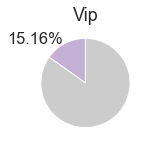

In [157]:
cluster_id = 1
cre_line = 'Vip-IRES-Cre'

col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

plot_fraction_per_cluster_pie(n_cells_per_cluster, cluster_id, cre_line, ax=None)


In [158]:

def plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=None):
    """
    Plots a stacked barplot of the proportion of cells in each cluster, split by each cre line
    x axis is cre line, y axis is proportion
    each cre line is sorted by its own fraction per cluster in ascending order
    the cluster_id provided will be colored according to the cre line and the size of that cluster will be plotted
    at the top of the stacked barplot
    """
    this_cluster = cluster_id
    if ax is None: 
        fig, ax = plt.subplots(figsize=(3,3))
    for x_pos, cre_line in enumerate(cre_lines):
        data = n_cells_per_cluster[(n_cells_per_cluster.cre_line == cre_line)]
        data['fraction'] = data.fraction_per_cluster
        data = data.sort_values(by=['fraction'], ascending=True)
        cluster_ids = data.cluster_id.values
        len_this_cluster = len(data[data.cluster_id == this_cluster])
        if len_this_cluster>0:
            cluster_is_present = True
        next_bar_start = 0
        for c, cluster_id in enumerate(cluster_ids):
            this_value = data[data.cluster_id == cluster_id].fraction.values[0]
            if (cluster_id == this_cluster) and (cluster_is_present==True): # only plot a color and label if its the cluster of interest
                color = cre_line_colors[x_pos]
                label = str(np.round(this_value*100, 1))+'%'
                ax.text(x_pos-0.4, 1.05, label, fontsize='x-small')
            else:
                color = 'gray'
            if c == 0:
                ax.bar(x_pos, this_value, bottom=next_bar_start, color=color, edgecolor='w')
            else:
                ax.bar(x_pos, this_value, bottom=next_bar_start, color=color, edgecolor='w')
            next_bar_start = next_bar_start + this_value
            # ax.axis('off')
            sns.despine(left=True, bottom=True)
            ax.tick_params(left=False, bottom=False)
    ax.set_xticks(np.arange(0,3))
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_yticklabels('')
    ax.set_ylabel('cluster proportion\nper cell type')
    return ax

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:ylabel='cluster proportion\nper cell type'>

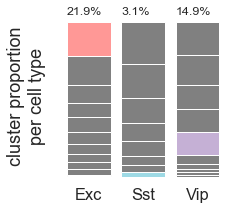

In [159]:
cluster_id = 0
plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=None)


### coding score metrics per cluster

In [160]:
coding_score_metrics.keys()

Index(['dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'ophys_experiment_id', 'cre_line',
       'cluster_id', 'labels', 'within_cluster_correlation', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'date', 'f

In [163]:
def plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-1, ymax=1, ylabel=None, ax=None):
    """
    plots distribution of a given coding score metric for a given cluster, for each cre line
    shows boxplot and individual data points
    cre line is on x axis, metric value on y axis
    """
    cluster_data = coding_score_metrics[coding_score_metrics.cluster_id==cluster_id]

    if ax is None: 
        figsize=(2,2.5)
        fig, ax = plt.subplots(figsize=figsize)

    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                     palette=cre_line_colors, ax=ax)

    ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
                color='white', width=0.5, ax=ax)
    ax = sns.stripplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
                palette=cre_line_colors, size=3, alpha=0.5, ax=ax)

    # ax.legend([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines], fontsize='xx-small')
    # ax.get_legend().remove()
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_xlabel('')
    if ylabel is not None:
        ax.set_title(ylabel)
        ax.set_ylabel('')
    # ax.set_ylabel('')
    # ax.set_title(metric)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.5, len(cre_lines)-0.5)
    ax.hlines(y=0, xmin=-0.5, xmax=len(cre_lines)-0.5, color='gray', linestyle='--')

    return ax


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


<AxesSubplot:ylabel='experience_selectivity'>

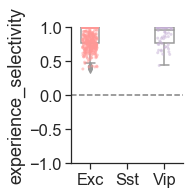

In [164]:
cluster_id = 1
metric = 'experience_selectivity'

plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ax=None)


In [165]:
# take absolute value so its just whether it is transient or not, regardless of direction
coding_score_metrics['persistence'] = 1-np.abs(coding_score_metrics.exp_mod_persistence.values)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


<AxesSubplot:ylabel='persistence'>

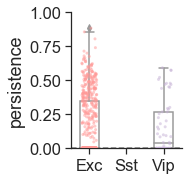

In [166]:
cluster_id = 1
metric = 'persistence'

plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=0, ax=None)


### response metrics per cluster

In [167]:
def plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1, ymax=1, ylabel=None, ax=None):
    """
    plots distribution of a given response metric (computed on cell traces directly) for a given cluster, for each cre line
    shows boxplot and individual data points
    cre line is on x axis, metric value on y axis
    """
    cluster_data = response_metrics[response_metrics.cluster_id==cluster_id]

    if ax is None: 
        figsize=(2,2.5)
        fig, ax = plt.subplots(figsize=figsize)

    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                     palette=cre_line_colors, ax=ax)

    ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, width=0.7,
                    hue='experience_level',hue_order=experience_levels, boxprops=dict(alpha=.6), 
                    palette=experience_level_colors, ax=ax)

    # ax = sns.pointplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',hue_order=experience_levels, join=False, dodge=True, 
    #                 palette=experience_level_colors, ax=ax)
                    
    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',hue_order=experience_levels, dodge=True,
    #                 color='white', width=0.5, ax=ax)
    # ax = sns.stripplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',  hue_order=experience_levels,
    #                 palette=experience_level_colors, dodge=True, size=3, alpha=0.5, ax=ax)

    # ax.legend([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines], fontsize='xx-small')
    ax.get_legend().remove()
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_xlabel('')
    if ylabel is not None: 
        ax.set_title(ylabel)
        ax.set_ylabel('')
    # ax.set_ylabel('')
    # ax.set_title(metric)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.5, len(cre_lines)-0.5)
    if ymin < -0.05: 
        ax.hlines(y=0, xmin=-0.5, xmax=len(cre_lines)-0.5, color='gray', linestyle='--')

    return ax


<AxesSubplot:ylabel='lifetime_sparseness'>

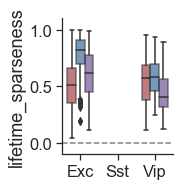

In [168]:
cluster_id = 1
metric = 'lifetime_sparseness'
plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ax=None)

<AxesSubplot:ylabel='running_modulation_index'>

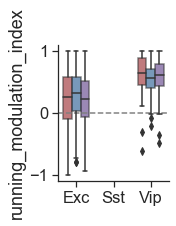

In [169]:
cluster_id = 1
metric = 'running_modulation_index'
plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ax=None)

<AxesSubplot:ylabel='reliability'>

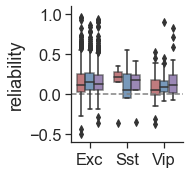

In [171]:
cluster_id = 0
metric = 'reliability'

plot_response_metric_for_cluster(pref_stim_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ax=None)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


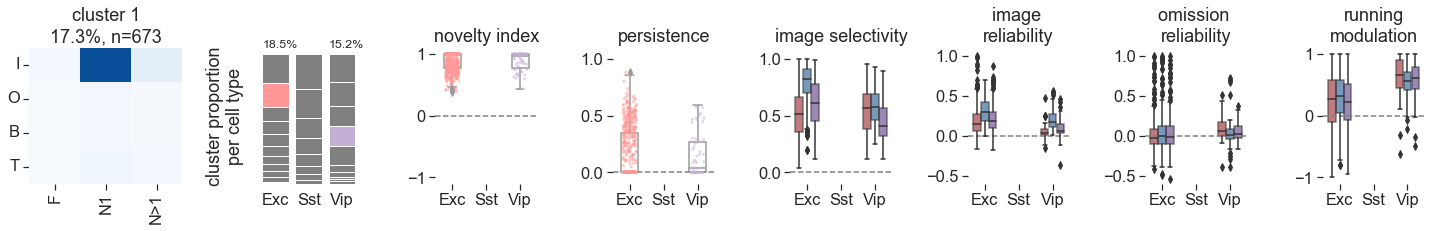

In [172]:
cluster_id = 1

def plot_cluster_properties(cluster_id): 
    figsize = (25,2.5)
    width_ratios = [1.5] + [int(x) for x in list(np.ones(7))]
    fig, ax = plt.subplots(1, 8, figsize=figsize, gridspec_kw={'width_ratios':width_ratios})

    i = 0
    ax[i] = plotting.plot_dropout_heatmap(cluster_meta, feature_matrix, cluster_id, cre_line=None, 
                                abbreviate_features=True, abbreviate_experience=True, small_fontsize=False, ax=ax[i])
    i+=1
    ax[i] = plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=ax[i])
    i+=1
    metric = 'experience_selectivity'
    ax[i] = plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ylabel='novelty index', ax=ax[i])
    i+=1
    metric = 'persistence'
    ax[i] = plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ylabel='persistence', ax=ax[i])
    i+=1
    metric = 'lifetime_sparseness'
    ax[i] = plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ylabel='image selectivity', ax=ax[i])
    i+=1
    metric = 'reliability'
    ax[i] = plot_response_metric_for_cluster(pref_stim_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ylabel='image \nreliability', ax=ax[i])
    i+=1
    metric = 'reliability'
    ax[i] = plot_response_metric_for_cluster(omission_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ylabel='omission \nreliability', ax=ax[i])
    i+=1
    metric = 'running_modulation_index'
    ax[i] = plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ylabel='running\nmodulation', ax=ax[i])

    plt.subplots_adjust(wspace=0.7)
    # plt.tight_layout()

    utils.save_figure(fig, figsize, save_dir, folder, 'cluster_properties_cluster_'+str(cluster_id))

plot_cluster_properties(cluster_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

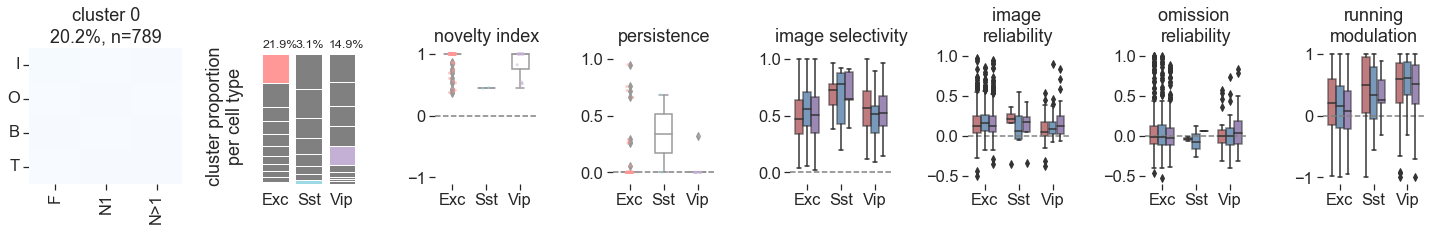

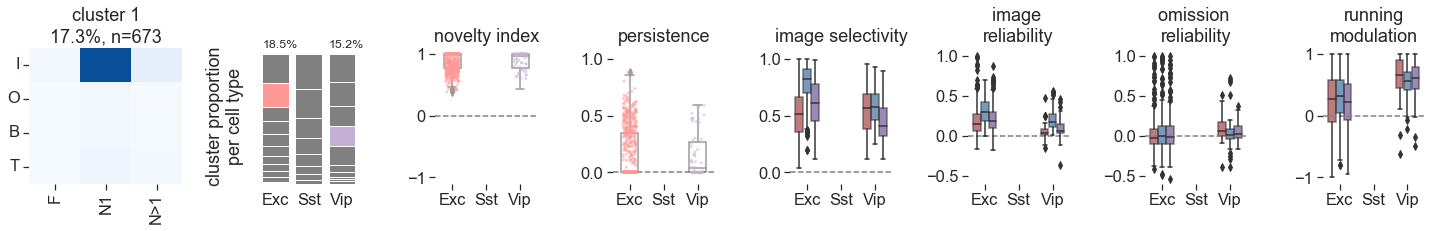

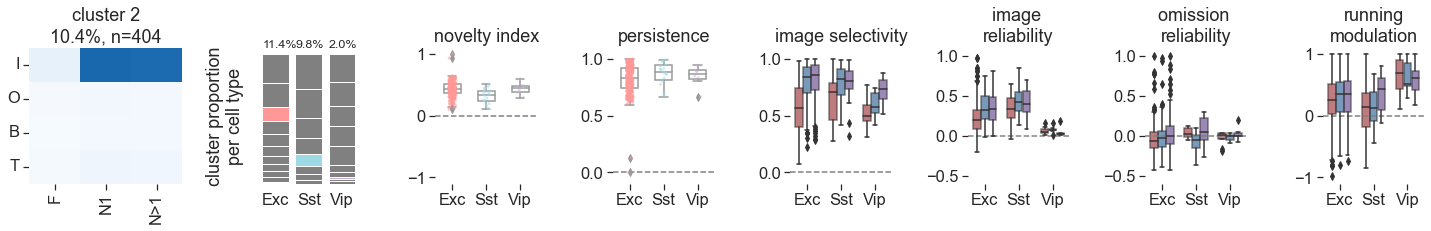

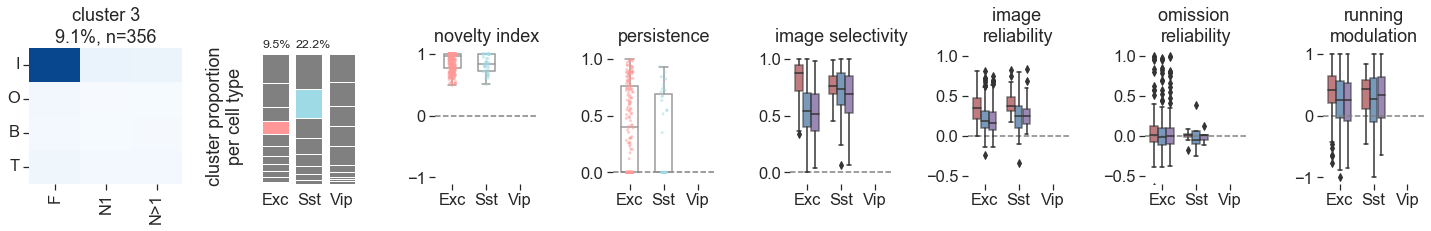

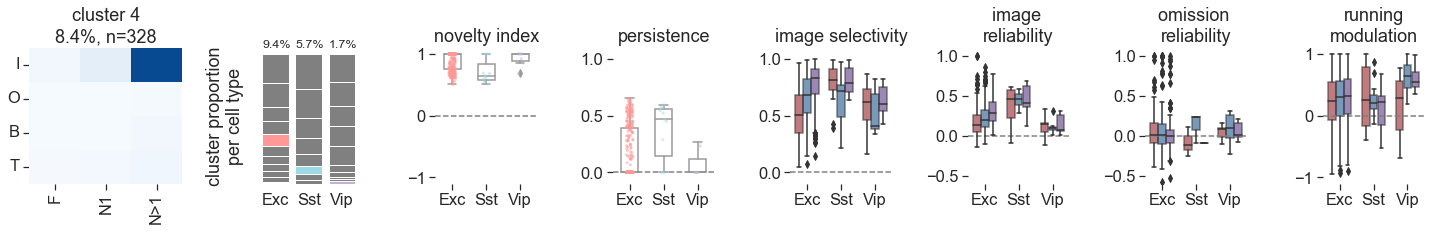

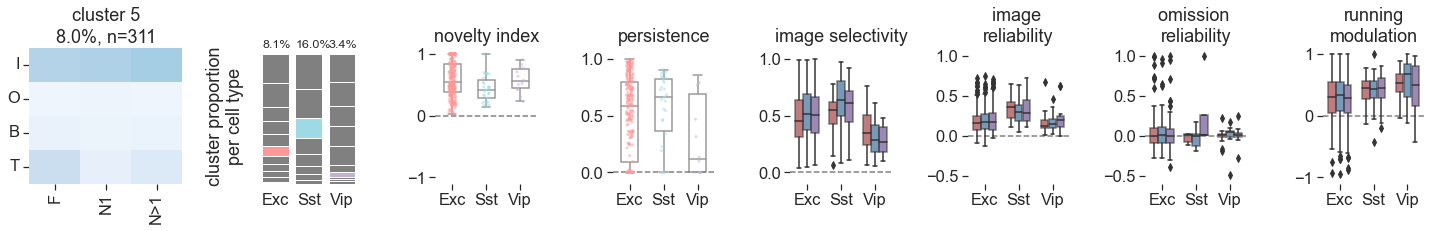

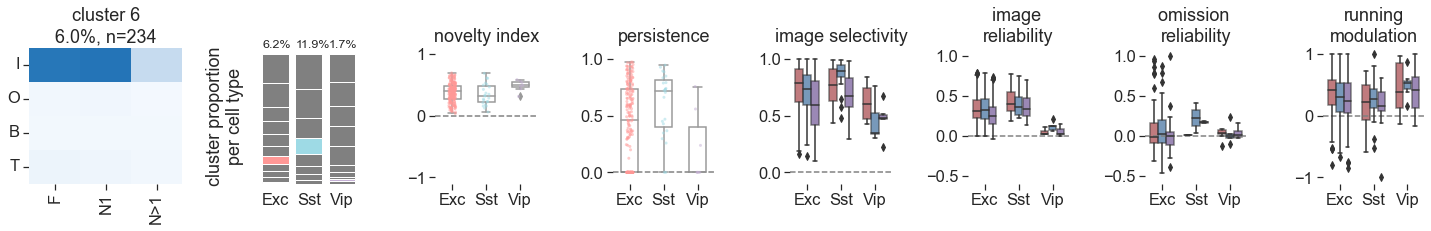

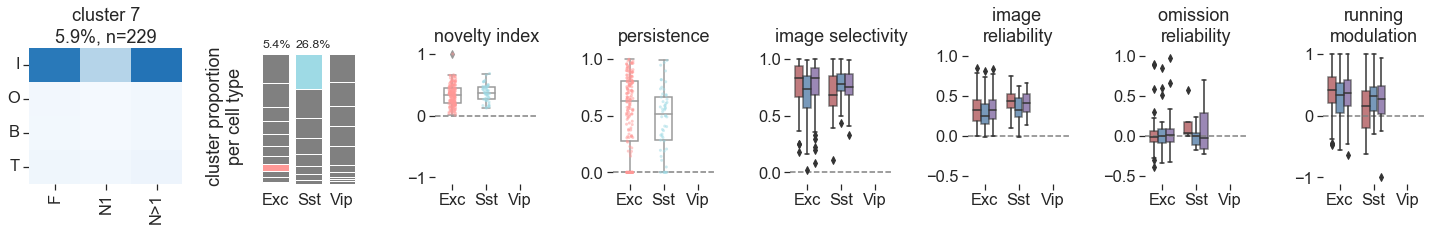

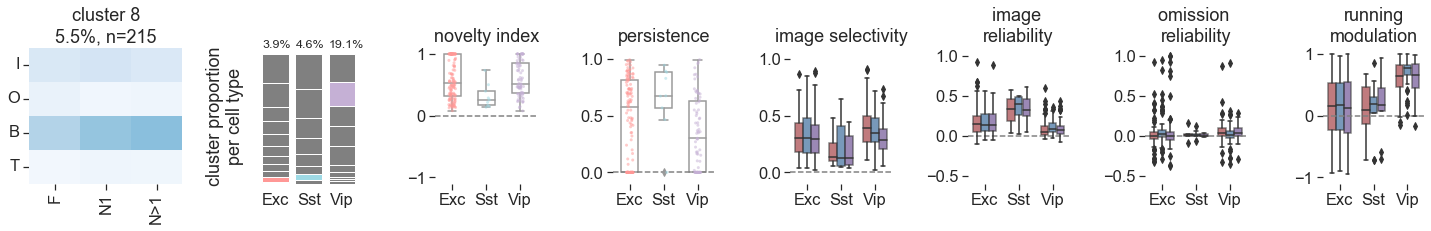

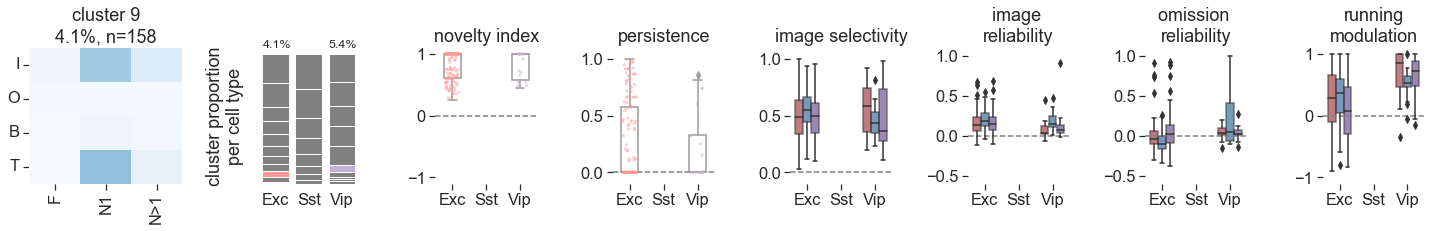

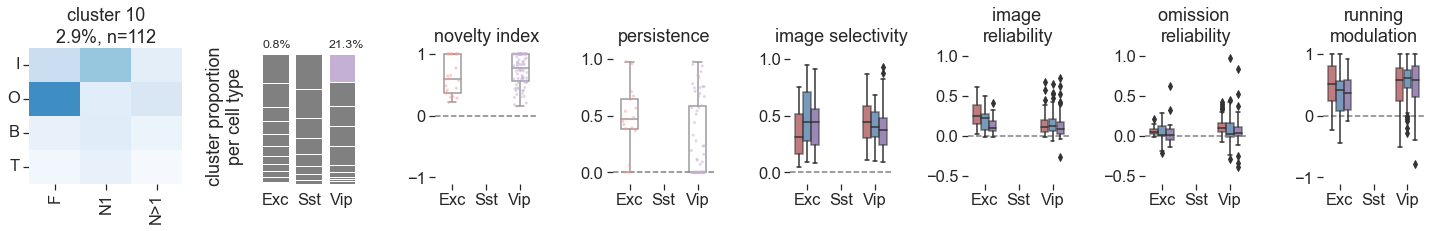

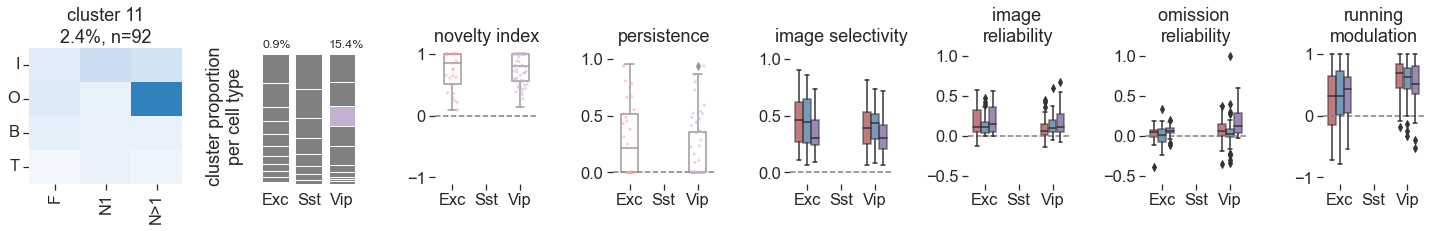

In [173]:
for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
    plot_cluster_properties(cluster_id)